## Importar Librerias

In [1]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd
import collections
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import os
import wave
import audioread
import warnings
import tensorflow as tf
import keras
warnings.filterwarnings('ignore')

## Procesamiento de Audio para extraccion de MFCC para genero y locutor

In [2]:
def cargamosDatosAudios(sr, pathM, pathH):
    DirMujeres = os.listdir(pathM)
    DirHombres = os.listdir(pathH)
    Mujeres = []
    Mujeres_canales = []
    Hombres = []
    Hombres_canales = []
    nombre_locutor = []
    audio_name = []
    Aux = 0
    
    for DirMujer in DirMujeres:
        tempDirMujeres = os.listdir(pathM+'/'+str(DirMujer))
        for mujer in tempDirMujeres:
            #print(pathM+'/'+str(DirMujer)+'/'+mujer)
            f = wave.open(pathM+'/'+str(DirMujer)+'/'+mujer,"rb")
            #print(f)
            if(f.getnchannels()==1):
                #print(f.getnchannels())
                audio_name.append(pathM+'/'+str(DirMujer)+'/'+mujer)
                
                y, sr = librosa.load(pathM+'/'+str(DirMujer)+'/'+mujer, sr=16000)
                nombre_locutor.append(str(Aux))
                Mujeres.append(librosa.effects.trim(y))
                
                #Mujeres.append(librosa.load('corpus_voz/GENERO/Entrenamiento_Genero/Mujer/'+str(DirMujer)+'/'+mujer, sr=sr))
                with audioread.audio_open(pathM+'/'+str(DirMujer)+'/'+mujer) as input_file:
                    Mujeres_canales.append(input_file.channels)
                #print('corpus_voz/GENERO/Entrenamiento_Genero/Mujer/'+str(DirMujer)+'/'+mujer)
            else:
                print(pathH+'/'+str(DirMujer)+'/'+mujer)
        Aux += 1
    for DirHombre in DirHombres:
        #corpus_voz\GENERO\Entrenamiento_Genero\Mujer
        tempDirHombres = os.listdir(pathH+'/'+str(DirHombre))
        for hombre in tempDirHombres:
            f = wave.open(pathH+'/'+str(DirHombre)+'/'+hombre,"rb")
            if(f.getnchannels()==1):
                #print(f.getnchannels())
                audio_name.append(pathH+'/'+str(DirHombre)+'/'+hombre)
                y, sr = librosa.load(pathH+'/'+str(DirHombre)+'/'+hombre, sr=16000)
                #yt, index = librosa.effects.trim(y)
                nombre_locutor.append(str(Aux))
                Hombres.append(librosa.effects.trim(y))
                with audioread.audio_open(pathH+'/'+str(DirHombre)+'/'+hombre) as input_file:
                    Hombres_canales.append(input_file.channels)
            else:
                print(pathH+'/'+str(DirHombre)+'/'+hombre)
        Aux += 1   
    Hombres_canales = list(set(Hombres_canales))
    Mujeres_canales = list(set(Mujeres_canales))
    totalHombres = len(Hombres)
    totalMujeres = len(Mujeres)
    print('Audios cargados de hombre: ' + str(len(Hombres)) + ' muestras')
    print('Audios cargados de mujer: ' + str(len(Mujeres)) + ' muestras')
    if len(Hombres_canales)==1 and Hombres_canales[0]== 1:
        print("Solo un canal para archivos de Hombres")
    else:
        print("Atención ! Algunos archivos de Hombres de audio tienen varios canales")
    if len(Mujeres_canales)==1 and Mujeres_canales[0]== 1:
        print("Solo un canal para archivos de Mujeres")
    else:
        print("Atención ! Algunos archivos de Mujeres de audio tienen varios canales")
    return Mujeres, Hombres, totalMujeres, totalHombres, nombre_locutor, audio_name

In [3]:
def kill_desktop_ini(root_dir):
    for (root, dirs, files) in os.walk(root_dir):
        if len(files) > 0:
            for file_name in files:
                if file_name.endswith('.ini'):
                    os.remove(f'{root}/{file_name}')

In [4]:
kill_desktop_ini(r'C:\Users\iemma\Documents\Articulo\corpus_voz\Corpus_80_20')
mujeres, hombres, Tmujeres, Thombres, etiquetas, audio_name = cargamosDatosAudios(16000, 'corpus_voz/Corpus_80_20/Entrenamiento/Mujer', 'corpus_voz/Corpus_80_20/Entrenamiento/Hombre')
mujeresP, hombresP, TmujeresP, ThombresP, etiquetasP, audio_nameP = cargamosDatosAudios(16000, 'corpus_voz/Corpus_80_20/Pruebas/Mujer', 'corpus_voz/Corpus_80_20/Pruebas/Hombre')
mujeresV, hombresV, TmujeresV, ThombresV, etiquetasV, audio_nameV = cargamosDatosAudios(16000, 'corpus_voz/Corpus_80_20/Validacion/Mujer', 'corpus_voz/Corpus_80_20/Validacion/Hombre')

Audios cargados de hombre: 700 muestras
Audios cargados de mujer: 700 muestras
Solo un canal para archivos de Hombres
Solo un canal para archivos de Mujeres
Audios cargados de hombre: 140 muestras
Audios cargados de mujer: 140 muestras
Solo un canal para archivos de Hombres
Solo un canal para archivos de Mujeres
Audios cargados de hombre: 140 muestras
Audios cargados de mujer: 140 muestras
Solo un canal para archivos de Hombres
Solo un canal para archivos de Mujeres


In [5]:
print(len(etiquetas))
print(len(etiquetasP))
print(len(etiquetasV))

1400
280
280


In [6]:
print(len(audio_name))
print(len(audio_nameP))
print(len(audio_nameV))

1400
280
280


In [7]:
#Ejemplo de audio para mujer
print(len(mujeres))
m1 = mujeres[1][0]
ipd.Audio(m1, rate=16000)

700


In [8]:
#Ejemplo de audio para hombre
print(len(hombres))
h1 = hombres[1][0]
ipd.Audio(h1,rate=16000)

700


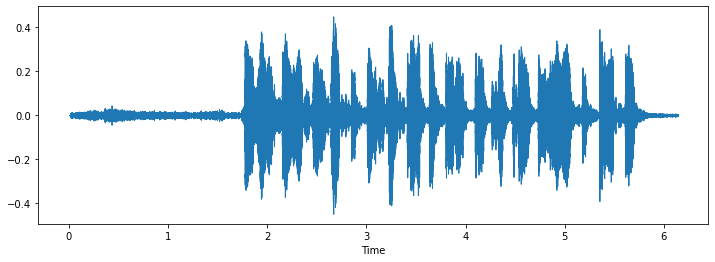

In [9]:
#Graficamos archivo de audio Amplitud vs. Tiempo
plt.figure(figsize=(12, 4))
librosa.display.waveshow(m1, sr=16000)
plt.show()

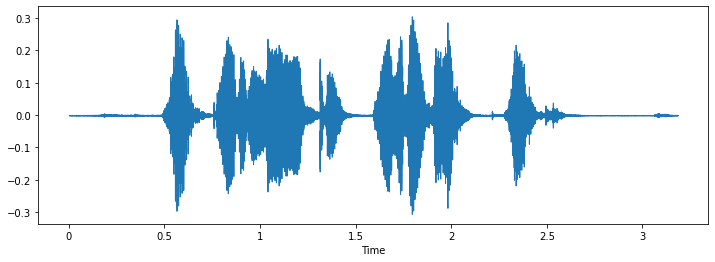

In [10]:
#Graficamos archivo de audio Amplitud vs. Tiempo
plt.figure(figsize=(12, 4))
librosa.display.waveshow(h1, sr=16000)
plt.show()

In [11]:
def audio_mfcc(Mujeres, Hombres, numMFCCs):
    mujeres_mfccs = []
    hombres_mfccs = []
    for i in range(len(Mujeres)):
        mujeres_mfccs.append(librosa.feature.mfcc(y=Mujeres[i][0], n_mfcc=numMFCCs, sr=16000, hop_length=int(0.035*16000), n_fft=int(0.88*16000), htk=True))
    for i in range(len(Hombres)):
        hombres_mfccs.append(librosa.feature.mfcc(y=Hombres[i][0], n_mfcc=numMFCCs, sr=16000, hop_length=int(0.035*16000), n_fft=int(0.88*16000), htk=True))
    return mujeres_mfccs, hombres_mfccs

In [12]:
#Calcular MFCC para cada audio 13 MFCCs + 13 Deltas + 13 Doble Deltas
mujeres_mfccs, hombres_mfccs = audio_mfcc(mujeres, hombres, 13)
mujeres_mfccsP, hombres_mfccsP = audio_mfcc(mujeresP, hombresP, 13)
mujeres_mfccsV, hombres_mfccsV = audio_mfcc(mujeresV, hombresV, 13)

In [13]:
#Calcular MFCC para cada audio 39 MFCCs
mujeres_mfccs39, hombres_mfccs39 = audio_mfcc(mujeres, hombres, 39)
mujeres_mfccsP39, hombres_mfccsP39 = audio_mfcc(mujeresP, hombresP, 39)
mujeres_mfccsV39, hombres_mfccsV39 = audio_mfcc(mujeresV, hombresV, 39)

In [14]:
#Calcular MFCC para cada audio 20 MFCCs
mujeres_mfccs20, hombres_mfccs20 = audio_mfcc(mujeres, hombres, 20)
mujeres_mfccsP20, hombres_mfccsP20 = audio_mfcc(mujeresP, hombresP, 20)
mujeres_mfccsV20, hombres_mfccsV20 = audio_mfcc(mujeresV, hombresV, 20)

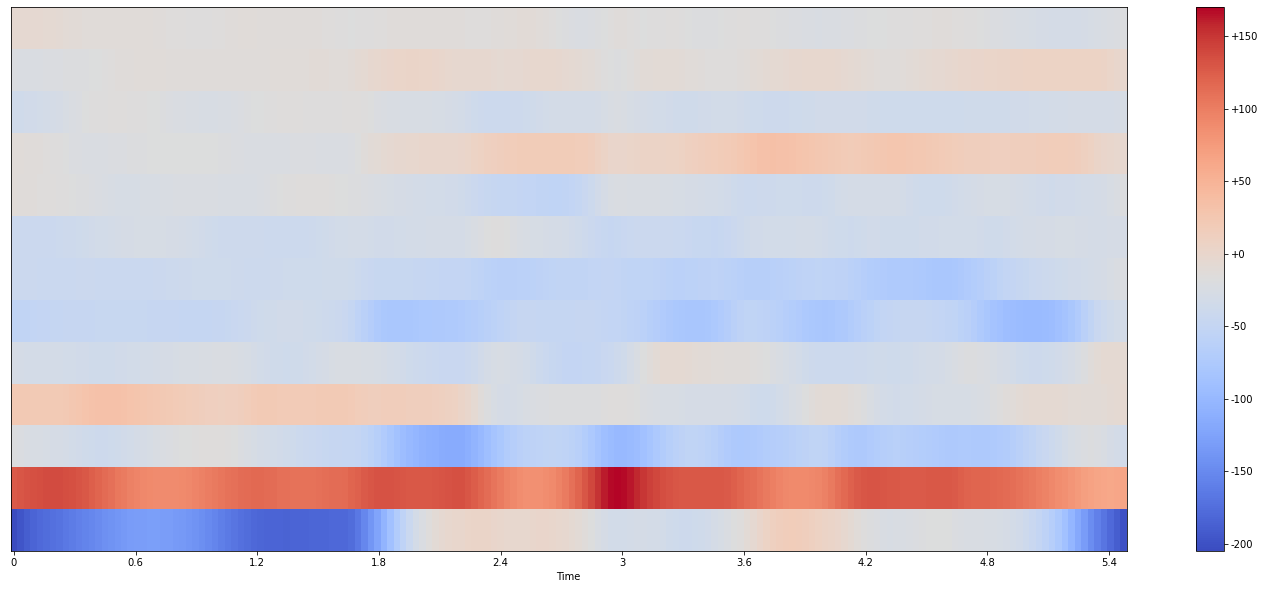

In [15]:
#MFFC audio mujer
plt.figure(figsize=(25, 10))
librosa.display.specshow(mujeres_mfccs[2], x_axis="time", sr=16000)
plt.colorbar(format="%+2.f")
plt.show()

In [16]:
def calculoDeltas(mfccsMujer, mfccsHombres, Tmujeres, Thombres):
    delta1M = []
    delta2M = []
    delta1H = []
    delta2H = []
    for i in range(Tmujeres):
        delta1_mfccs = librosa.feature.delta(mfccsMujer[i])
        delta1M.append(delta1_mfccs)
        delta2_mfccs = librosa.feature.delta(mfccsMujer[i], order=2)
        delta2M.append(delta2_mfccs)
    for i in range(Thombres):
        delta1_mfccs = librosa.feature.delta(mfccsHombres[i])
        delta1H.append(delta1_mfccs)
        delta2_mfccs = librosa.feature.delta(mfccsHombres[i], order=2)
        delta2H.append(delta2_mfccs)
    return delta1M, delta2M, delta1H, delta2H

In [17]:
delta1M, delta2M, delta1H, delta2H = calculoDeltas(mujeres_mfccs, hombres_mfccs, Tmujeres, Thombres)
delta1MV, delta2MV, delta1HV, delta2HV = calculoDeltas(mujeres_mfccsV, hombres_mfccsV, TmujeresV, ThombresV)
delta1MP, delta2MP, delta1HP, delta2HP = calculoDeltas(mujeres_mfccsP, hombres_mfccsP, TmujeresP, ThombresP)

In [18]:
def concatenaMFCCs(m_mfccs, h_mfccs, delta1M, delta2M, delta1H, delta2H, ctrl):
    mffccMCDDD = []
    mffccHCDDD = []
    if(ctrl==1):
        for i in range(len(m_mfccs)):
            mffccMCDDD.append(np.concatenate((m_mfccs[i], delta1M[i], delta2M[i])))
        for i in range(len(h_mfccs)):
            mffccHCDDD.append(np.concatenate((h_mfccs[i], delta1H[i], delta2H[i])))
    if(ctrl==2):
        for i in range(len(m_mfccs)):
            mffccMCDDD.append(m_mfccs[i])
        for i in range(len(h_mfccs)):
            mffccHCDDD.append(h_mfccs[i])
    return mffccMCDDD, mffccHCDDD

In [19]:
MFCCSM, MFCCSH = concatenaMFCCs(mujeres_mfccs, hombres_mfccs, delta1M, delta2M, delta1H, delta2H, 1)
MFCCSMV, MFCCSHV = concatenaMFCCs(mujeres_mfccsV, hombres_mfccsV, delta1MV, delta2MV, delta1HV, delta2HV, 1)
MFCCSMP, MFCCSHP = concatenaMFCCs(mujeres_mfccsP, hombres_mfccsP, delta1MP, delta2MP, delta1HP, delta2HP, 1)

In [20]:
MFCCSM39, MFCCSH39 = concatenaMFCCs(mujeres_mfccs39, hombres_mfccs39, [], [], [], [], 2)
MFCCSMV39, MFCCSHV39 = concatenaMFCCs(mujeres_mfccsV39, hombres_mfccsV39, [], [], [], [], 2)
MFCCSMP39, MFCCSHP39 = concatenaMFCCs(mujeres_mfccsP39, hombres_mfccsP39, [], [], [], [], 2)

In [21]:
MFCCSM20, MFCCSH20 = concatenaMFCCs(mujeres_mfccs20, hombres_mfccs20, [], [], [], [], 2)
MFCCSMV20, MFCCSHV20 = concatenaMFCCs(mujeres_mfccsV20, hombres_mfccsV20, [], [], [], [], 2)
MFCCSMP20, MFCCSHP20 = concatenaMFCCs(mujeres_mfccsP20, hombres_mfccsP20, [], [], [], [], 2)

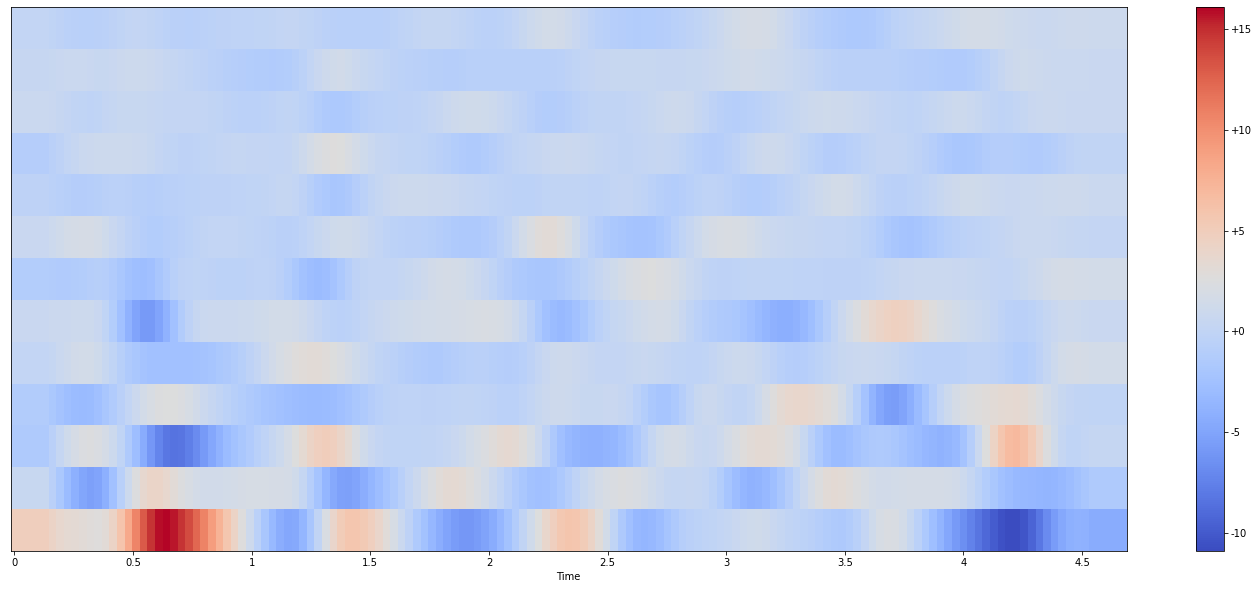

In [22]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta1M[0], x_axis="time", sr=16000)
plt.colorbar(format="%+2.f")
plt.show()

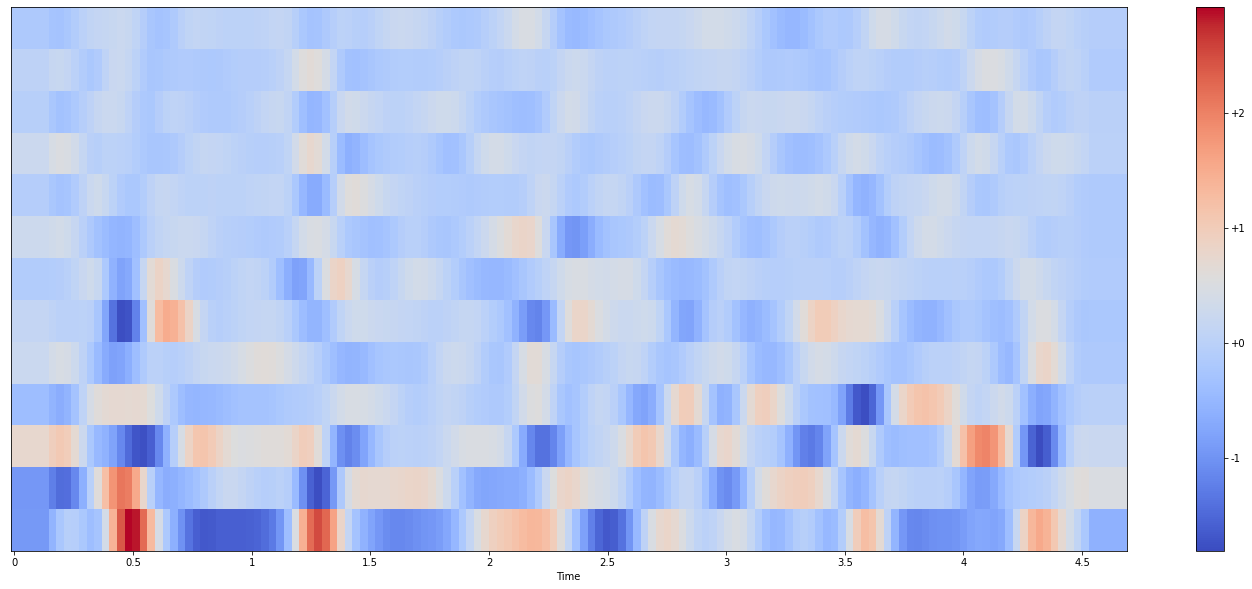

In [23]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2M[0], x_axis="time", sr=16000)
plt.colorbar(format="%+2.f")
plt.show()

In [24]:
#Generamos los conjuntos de datos de entrenamiento, pruebas y validación 
def dataSetsETV(MFCCSM, MFCCSH, etiquetas, audio_name, aux, ctrl):
    #Creamos el dataset para genero y locutor
    dataframeM = []
    dataframeH = []
    conAux = 0
    for i in range(len(MFCCSM)):
        df = pd.DataFrame(MFCCSM[i])
        d = df.transpose()
        d['Label']='0'
        d['Label1']=etiquetas[conAux]
        d['Label2']=audio_name[conAux]
        dataframeM.append(d)
        conAux += 1
    for i in range(len(MFCCSH)):
        df = pd.DataFrame(MFCCSH[i])
        d = df.transpose()
        d['Label']='1'
        d['Label1']=etiquetas[conAux]
        d['Label2']=audio_name[conAux]
        dataframeH.append(d)
        conAux += 1
    ListaGeneros = dataframeH + dataframeM
    result = pd.concat(ListaGeneros)
    #39 Coeficientes MFCC
    if(aux==1):
        result.columns = ['Coef1', 'Coef2', 'Coef3', 'Coef4', 'Coef5', 'Coef6', 'Coef7', 'Coef8', 'Coef9', 'Coef10', 'Coef11', 'Coef12', 'Coef13',
                          'Coef14', 'Coef15', 'Coef16', 'Coef17', 'Coef18', 'Coef19', 'Coef20', 'Coef21', 'Coef22', 'Coef23', 'Coef24', 'Coef25', 'Coef26',
                          'Coef27', 'Coef28', 'Coef29', 'Coef30', 'Coef31', 'Coef32', 'Coef33', 'Coef34', 'Coef35', 'Coef36', 'Coef37', 'Coef38', 'Coef39',
                          'Genero', 'Locutor', 'Name_audio']
        if(ctrl==1):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorEntrenamiento39MFCC.csv")
        if(ctrl==2):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorPruebas39MFCC.csv")
        if(ctrl==3):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorValidacion39MFCC.csv")
    #13 Coeficientes MFCC + 13 Coeficientes MFCC Delta + 13 Coeficientes MFCC Doble Delta
    if(aux==2):
        result.columns = ['Coef1', 'Coef2', 'Coef3', 'Coef4', 'Coef5', 'Coef6', 'Coef7', 'Coef8', 'Coef9', 'Coef10', 'Coef11', 'Coef12', 'Coef13',
                          'DCoef1', 'DCoef2', 'DCoef3', 'DCoef4', 'DCoef5', 'DCoef6', 'DCoef7', 'DCoef8', 'DCoef9', 'DCoef10', 'DCoef11', 'DCoef12', 'DCoef13',
                          'DDCoef1', 'DDCoef2', 'DDCoef3', 'DDCoef4', 'DDCoef5', 'DDCoef6', 'DDCoef7', 'DDCoef8', 'DDCoef9', 'DDCoef10', 'DDCoef11', 'DDCoef12', 'DDCoef13', 
                          'Genero', 'Locutor', 'Name_audio']
        if(ctrl==1):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorEntrenamiento39MFCCDDD.csv")
        if(ctrl==2):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorPruebas39MFCCDDD.csv")
        if(ctrl==3):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorValidacion39MFCCDDD.csv")
    #20 Coeficientes MFCC
    if(aux==3):
        result.columns = ['Coef1', 'Coef2', 'Coef3', 'Coef4', 'Coef5', 'Coef6', 'Coef7', 'Coef8', 'Coef9', 'Coef10', 
                          'Coef11', 'Coef12', 'Coef13', 'Coef14', 'Coef15', 'Coef16', 'Coef17', 'Coef18', 'Coef19', 'Coef20', 
                          'Genero', 'Locutor', 'Name_audio']
        if(ctrl==1):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorEntrenamiento20MFCC.csv")
        if(ctrl==2):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorPruebas20MFCC.csv")
        if(ctrl==3):
            result.to_csv("DataSetMFCC/DataSetGeneroLocutorValidacion20MFCC.csv")

In [25]:
dataSetsETV(MFCCSM39, MFCCSH39, etiquetas, audio_name, 1, 1)
dataSetsETV(MFCCSMP39, MFCCSHP39, etiquetasP, audio_nameP, 1, 2)
dataSetsETV(MFCCSMV39, MFCCSHV39, etiquetasV, audio_nameV, 1, 3)

In [26]:
dataSetsETV(MFCCSM, MFCCSH, etiquetas, audio_name, 2, 1)
dataSetsETV(MFCCSMP, MFCCSHP, etiquetasP, audio_nameP, 2, 2)
dataSetsETV(MFCCSMV, MFCCSHV, etiquetasV, audio_nameV, 2, 3)

In [27]:
dataSetsETV(MFCCSM20, MFCCSH20, etiquetas, audio_name, 3, 1)
dataSetsETV(MFCCSMP20, MFCCSHP20, etiquetasP, audio_nameP, 3, 2)
dataSetsETV(MFCCSMV20, MFCCSHV20, etiquetasV, audio_nameV, 3, 3)

## Importar el dataset

In [28]:
def ParamterConfigure(dataSetE, dataSetP, dataSetV, num_Features):
    #Importing the dataset
    datasetEntrenamiento = pd.read_csv(dataSetE)
    datasetPruebas = pd.read_csv(dataSetP)
    datasetValidacion = pd.read_csv(dataSetV)
    #Configurando los parametros
    #Entrenamiento
    XE = datasetEntrenamiento.iloc[:, 1:num_Features-2].values #aqui se especifican todas las las columna de las caracteristicas
    YGE = datasetEntrenamiento.iloc[:, num_Features-2].values #se especifica el vector de salida genero
    YLE = datasetEntrenamiento.iloc[:, num_Features-1].values #se especifica el vector de salida locutor
    YAE = datasetEntrenamiento.iloc[:, num_Features].values
    #Pruebas
    XP = datasetPruebas.iloc[:, 1:num_Features-2].values #aqui se especifican todas las las columna de las caracteristicas
    YGP = datasetPruebas.iloc[:, num_Features-2].values #se especifica el vector de salida genero
    YLP = datasetPruebas.iloc[:, num_Features-1].values #se especifica el vector de salida locutor
    YAP = datasetPruebas.iloc[:, num_Features].values
    #Validacion
    XV = datasetValidacion.iloc[:, 1:num_Features-2].values #aqui se especifican todas las las columna de las caracteristicas
    YGV = datasetValidacion.iloc[:, num_Features-2].values #se especifica el vector de salida genero
    YLV = datasetValidacion.iloc[:, num_Features-1].values #se especifica el vector de salida locutor
    YAV = datasetValidacion.iloc[:, num_Features].values
    #Pasamos las etiquetas de nombres a numeros para implementar los algoritmos
    #Genero
    etiquetaGeneroE = preprocessing.LabelEncoder()
    etiquetaGeneroE.fit(YGE)
    ygE = etiquetaGeneroE.transform(YGE)
    
    etiquetaGeneroP = preprocessing.LabelEncoder()
    etiquetaGeneroP.fit(YGP)
    ygP = etiquetaGeneroP.transform(YGP)
    
    etiquetaGeneroV = preprocessing.LabelEncoder()
    etiquetaGeneroV.fit(YGV)
    ygV = etiquetaGeneroP.transform(YGV)
    #Locutor
    etiquetaLocutorE = preprocessing.LabelEncoder()
    etiquetaLocutorE.fit(YLE)
    ylE = etiquetaLocutorE.transform(YLE)
    etiquetaLocutorP = preprocessing.LabelEncoder()
    etiquetaLocutorP.fit(YLP)
    ylP = etiquetaLocutorP.transform(YLP)
    etiquetaLocutorV = preprocessing.LabelEncoder()
    etiquetaLocutorV.fit(YLV)
    ylV = etiquetaLocutorV.transform(YLV)
    #Audios
    label_encoder = preprocessing.LabelEncoder() 
    datasetEntrenamiento['Name_audio']= label_encoder.fit_transform(datasetEntrenamiento['Name_audio']) 
    yAE = datasetEntrenamiento['Name_audio']
    label_encoder = preprocessing.LabelEncoder() 
    datasetPruebas['Name_audio']= label_encoder.fit_transform(datasetPruebas['Name_audio']) 
    yAP = datasetPruebas['Name_audio']
    label_encoder = preprocessing.LabelEncoder() 
    datasetValidacion['Name_audio']= label_encoder.fit_transform(datasetValidacion['Name_audio']) 
    yAV = datasetValidacion['Name_audio']
    return XE, ygE, ylE, yAE, XP, ygP, ylP, yAP, XV, ygV, ylV, yAV

In [29]:
XE, ygE, ylE, yAE, XP, ygP, ylP, yAP, XV, ygV, ylV, yAV = ParamterConfigure("DataSetMFCC/DataSetGeneroLocutorEntrenamiento39MFCCDDD.csv", "DataSetMFCC/DataSetGeneroLocutorPruebas39MFCCDDD.csv", "DataSetMFCC/DataSetGeneroLocutorValidacion39MFCCDDD.csv", 42)
XE39MFCC, ygE39MFCC, ylE39MFCC, yAE39MFCC, XP39MFCC, ygP39MFCC, ylP39MFCC, yAP39MFCC, XV39MFCC, ygV39MFCC, ylV39MFCC, yAV39MFCC = ParamterConfigure("DataSetMFCC/DataSetGeneroLocutorEntrenamiento39MFCC.csv", "DataSetMFCC/DataSetGeneroLocutorPruebas39MFCC.csv", "DataSetMFCC/DataSetGeneroLocutorValidacion39MFCC.csv", 42)
XE20MFCC, ygE20MFCC, ylE20MFCC, yAE20MFCC, XP20MFCC, ygP20MFCC, ylP20MFCC, yAP20MFCC, XV20MFCC, ygV20MFCC, ylV20MFCC, yAV20MFCC = ParamterConfigure("DataSetMFCC/DataSetGeneroLocutorEntrenamiento20MFCC.csv", "DataSetMFCC/DataSetGeneroLocutorPruebas20MFCC.csv", "DataSetMFCC/DataSetGeneroLocutorValidacion20MFCC.csv", 23)

# Features Foward Selection

In [30]:
def FeaturesFowardSelection(X_train, y_train, X_test, y_test, X_val, y_val, features):
    AUCFeaturesTest = []
    AUCFeaturesVal = []
    titulo = 'ds'
    for i in range(features):
        print(X_train[0:, 0:i+1])
        print(X_train[0:, 0:i+1].shape)
        param_grid = {
        'solver': ['liblinear']
        } 
        #Se pasa como parametros el modelo, los parametros a probar, cross validation
        gridRL = GridSearchCV(LogisticRegression(), param_grid, verbose = 3, n_jobs=-1, cv=3) 
        #Tiempo de ejecucion 
        start_time = time()
        #Ajuste del modelo para la GridSearch
        gridRL.fit(X_train[0:, 0:i+1], y_train) 
        elapsed_time = (time() - start_time)*1000
        print("Training time: %f" % elapsed_time)
        #Imprime el mejor parámetro después del ajuste 
        print(gridRL.best_params_) 
        rlbest = gridRL.best_estimator_
        #Test
        start_time = time()
        grid_predictions_rl_T = rlbest.predict(X_test[0:, 0:i+1])
        elapsed_time = (time() - start_time)*1000
        # print classification report 
        print(classification_report(y_test, grid_predictions_rl_T)) 
        print("Test time: %f" % elapsed_time)
        #Validation
        start_time = time()
        grid_predictions_rl_V = rlbest.predict(X_val[0:, 0:i+1])
        elapsed_time = (time() - start_time)*1000
        # print classification report 
        print(classification_report(y_val, grid_predictions_rl_V)) 
        print("Validation time: %f" % elapsed_time)
        def plot_roc_curve(fper, tper, title):
            plt.plot(fper, tper, color='blue', label='Logistic Regression - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title(str(title))
            plt.legend()
            plt.show()
        print("Regresion Logistica Test")
        fper, tper, thresholds = roc_curve(y_test, grid_predictions_rl_T)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_test, grid_predictions_rl_T)
        print("AUC: "+str(metrics.auc(fper, tper)))
        AUCFeaturesTest.append(metrics.auc(fper, tper))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_test, grid_predictions_rl_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        print("Regresion Logistica Validation")
        fper, tper, thresholds = roc_curve(y_val, grid_predictions_rl_V)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_val, grid_predictions_rl_V)
        print("AUC: "+str(metrics.auc(fper, tper)))
        AUCFeaturesVal.append(metrics.auc(fper, tper))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_val)
        cm = confusion_matrix(y_val, grid_predictions_rl_V)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
    return AUCFeaturesTest, AUCFeaturesVal

[[-461.9256 ]
 [-453.95935]
 [-441.73483]
 ...
 [-288.80374]
 [-312.29477]
 [-330.2163 ]]
(179136, 1)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1942.362309
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.60      0.52      0.55     18060
           1       0.58      0.66      0.62     18564

    accuracy                           0.59     36624
   macro avg       0.59      0.59      0.59     36624
weighted avg       0.59      0.59      0.59     36624

Test time: 0.000000
              precision    recall  f1-score   support

           0       0.59      0.53      0.56     17410
           1       0.58      0.64      0.61     17760

    accuracy                           0.58     35170
   macro avg       0.59      0.58      0.58     35170
weighted avg       0.59      0.58      0.58     35170

Validation time: 1.003027
Regresion Logistica Test


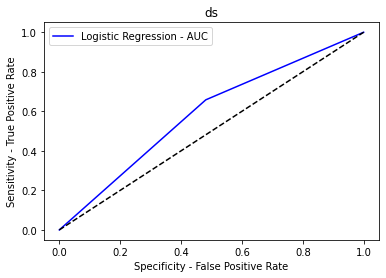

AUC: 0.5883808621838718
Confusion Matrix : 
 [[ 9367  8693]
 [ 6347 12217]]
Accuracy :  0.5893403232852774
Sensitivity :  0.5186600221483942
Specificity :  0.6581017022193493


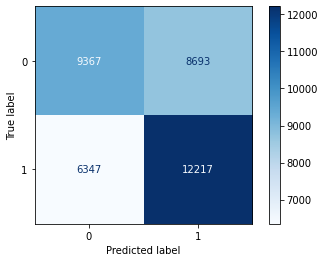

Regresion Logistica Validation


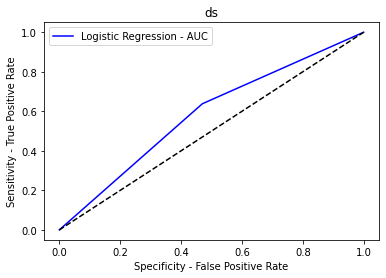

AUC: 0.5841068092791241
Confusion Matrix : 
 [[ 9226  8184]
 [ 6424 11336]]
Accuracy :  0.5846460051179982
Sensitivity :  0.5299253302699598
Specificity :  0.6382882882882883


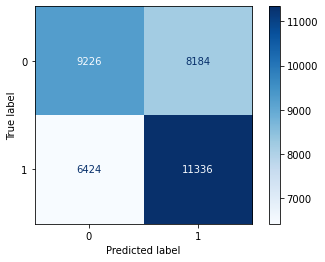

[[-461.9256     37.986633]
 [-453.95935    40.84214 ]
 [-441.73483    48.792828]
 ...
 [-288.80374   133.47595 ]
 [-312.29477   145.09683 ]
 [-330.2163    145.90912 ]]
(179136, 2)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1256.552219
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.62      0.53      0.57     18060
           1       0.60      0.69      0.64     18564

    accuracy                           0.61     36624
   macro avg       0.61      0.61      0.61     36624
weighted avg       0.61      0.61      0.61     36624

Test time: 1.041889
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.61      0.61      0.61     35170
weighted avg       0.61      0.61      0.61     35170

Validation time: 0.000000
Regresion 

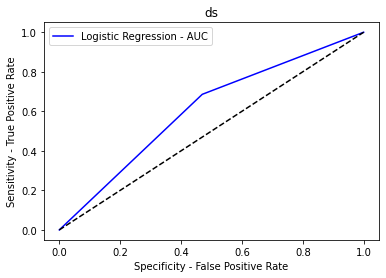

AUC: 0.6081188647194118
Confusion Matrix : 
 [[ 9576  8484]
 [ 5829 12735]]
Accuracy :  0.6091906946264745
Sensitivity :  0.5302325581395348
Specificity :  0.686005171299289


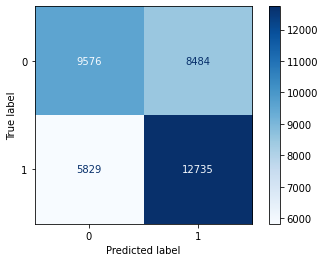

Regresion Logistica Validation


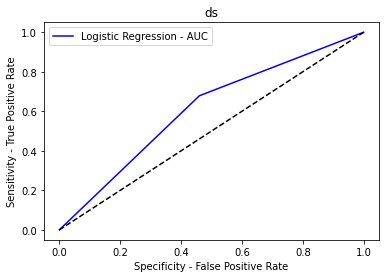

AUC: 0.60920302482264
Confusion Matrix : 
 [[ 9396  8014]
 [ 5706 12054]]
Accuracy :  0.6098947967017344
Sensitivity :  0.5396898334290637
Specificity :  0.6787162162162163


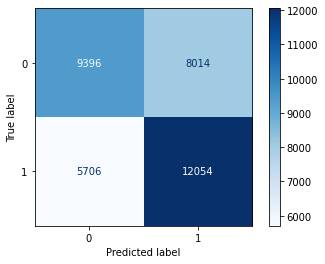

[[-461.9256     37.986633   14.340712]
 [-453.95935    40.84214    13.285265]
 [-441.73483    48.792828   16.774529]
 ...
 [-288.80374   133.47595    64.27397 ]
 [-312.29477   145.09683    46.839935]
 [-330.2163    145.90912    39.09671 ]]
(179136, 3)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1230.082989
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.55      0.60     18060
           1       0.62      0.71      0.66     18564

    accuracy                           0.63     36624
   macro avg       0.63      0.63      0.63     36624
weighted avg       0.63      0.63      0.63     36624

Test time: 0.000000
              precision    recall  f1-score   support

           0       0.63      0.54      0.58     17410
           1       0.60      0.69      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.62      0.61      0.61     35170
weighted avg       

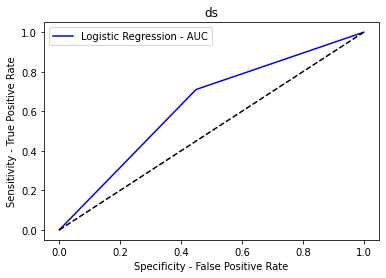

AUC: 0.6304266071365935
Confusion Matrix : 
 [[ 9943  8117]
 [ 5378 13186]]
Accuracy :  0.6315257754477938
Sensitivity :  0.5505537098560355
Specificity :  0.7102995044171515


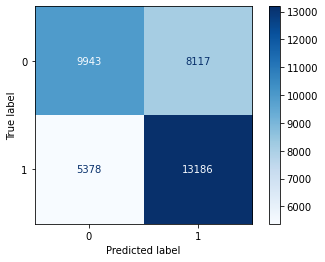

Regresion Logistica Validation


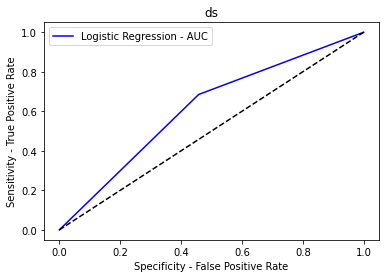

AUC: 0.613619819561089
Confusion Matrix : 
 [[ 9440  7970]
 [ 5594 12166]]
Accuracy :  0.6143303952232015
Sensitivity :  0.5422171165996553
Specificity :  0.6850225225225225


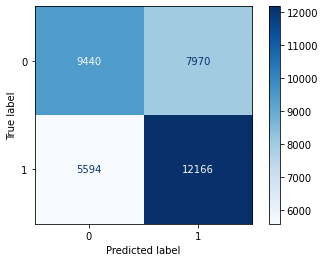

[[-461.9256       37.986633     14.340712      4.210198  ]
 [-453.95935      40.84214      13.285265      4.3595467 ]
 [-441.73483      48.792828     16.774529      6.6460085 ]
 ...
 [-288.80374     133.47595      64.27397      -0.57170194]
 [-312.29477     145.09683      46.839935      8.134534  ]
 [-330.2163      145.90912      39.09671       8.820234  ]]
(179136, 4)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1299.983978
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.56      0.61     18060
           1       0.63      0.71      0.66     18564

    accuracy                           0.64     36624
   macro avg       0.64      0.64      0.63     36624
weighted avg       0.64      0.64      0.64     36624

Test time: 1.000643
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    acc

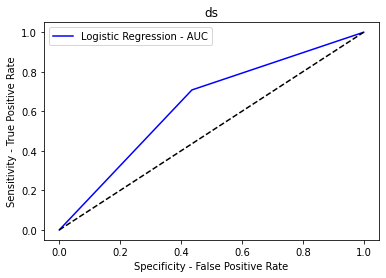

AUC: 0.6361875698401007
Confusion Matrix : 
 [[10190  7870]
 [ 5418 13146]]
Accuracy :  0.6371778069025775
Sensitivity :  0.5642303433001108
Specificity :  0.7081447963800905


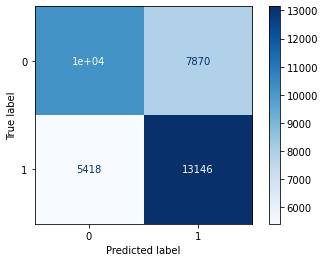

Regresion Logistica Validation


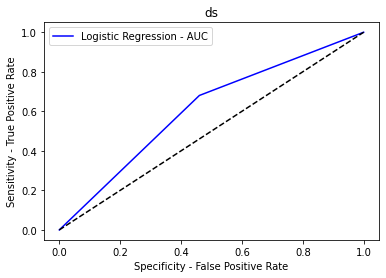

AUC: 0.6099631599577751
Confusion Matrix : 
 [[ 9396  8014]
 [ 5679 12081]]
Accuracy :  0.6106624964458345
Sensitivity :  0.5396898334290637
Specificity :  0.6802364864864865


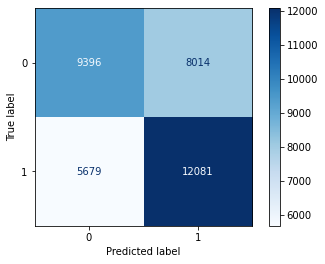

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01]]
(179136, 5)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1388.636589
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.68      0.59      0.63     18060
           1       0.65      0.72      0.68     18564

    accuracy                           0.66     36624
   macro avg       0.66      0.66      0.66     36624
weighted avg       0.66      0.66      0.66     36624

Test time: 1.000166
              precision    recall  f1-score  

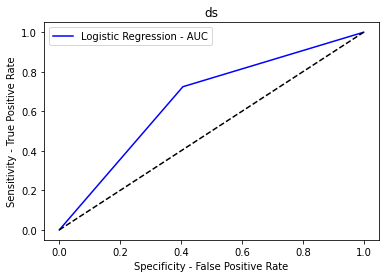

AUC: 0.6591879506722187
Confusion Matrix : 
 [[10726  7334]
 [ 5115 13449]]
Accuracy :  0.6600862822193098
Sensitivity :  0.5939091915836102
Specificity :  0.7244667097608274


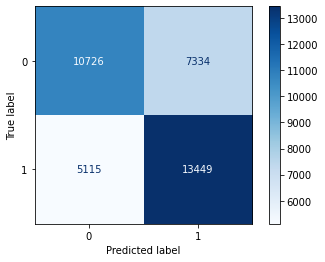

Regresion Logistica Validation


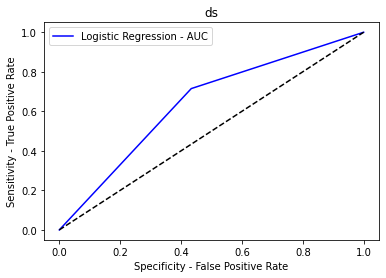

AUC: 0.6406880494796923
Confusion Matrix : 
 [[ 9861  7549]
 [ 5062 12698]]
Accuracy :  0.641427352857549
Sensitivity :  0.566398621481907
Specificity :  0.7149774774774775


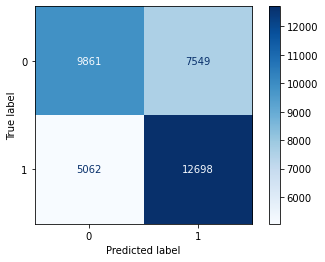

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02 -2.3872137e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01 -2.2336156e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01 -3.4468700e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00 -7.9153534e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01 -7.1443180e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01 -6.6536865e+01]]
(179136, 6)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1227.772951
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.69      0.60      0.64     18060
           1       0.66      0.73      0.69     18564

    accuracy                           0.67     36624
   macro avg       0.67      0.67      0.67     36624
weighted avg       0.67      0

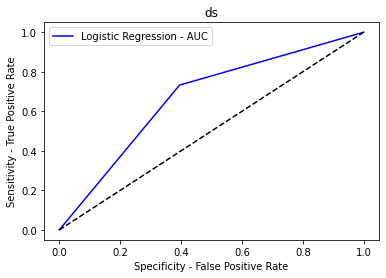

AUC: 0.6687643751597241
Confusion Matrix : 
 [[10925  7135]
 [ 4964 13600]]
Accuracy :  0.6696428571428571
Sensitivity :  0.6049280177187154
Specificity :  0.7326007326007326


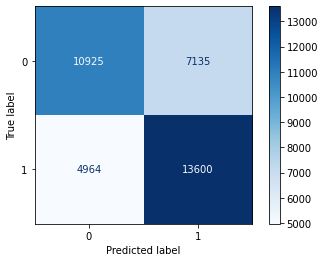

Regresion Logistica Validation


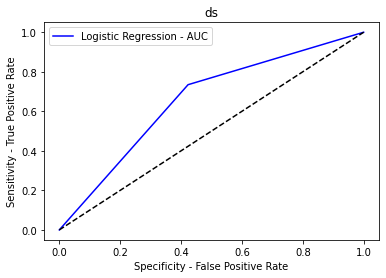

AUC: 0.6557972533130488
Confusion Matrix : 
 [[10044  7366]
 [ 4712 13048]]
Accuracy :  0.6565823144725619
Sensitivity :  0.5769098219414129
Specificity :  0.7346846846846847


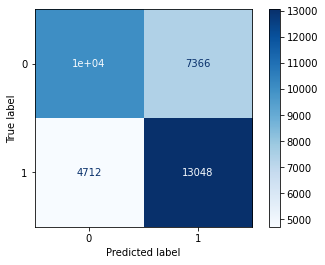

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -5.4178063e-02
  -2.3872137e+00 -6.9183330e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -4.4440317e-01
  -2.2336156e+00 -7.3383017e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.7909959e-01
  -3.4468700e+00 -1.0184973e+01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -7.8325977e+00
  -7.9153534e+01 -3.4108032e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.5897917e+01
  -7.1443180e+01 -3.5344510e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -1.7901260e+01
  -6.6536865e+01 -3.4597000e+01]]
(179136, 7)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 986.818552
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     18060
           1       0.68      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighte

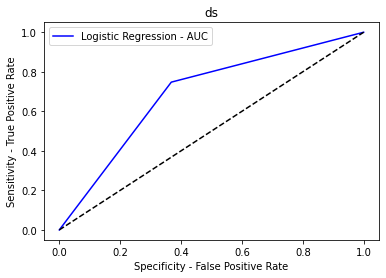

AUC: 0.6897901915685773
Confusion Matrix : 
 [[11414  6646]
 [ 4686 13878]]
Accuracy :  0.6905854084753167
Sensitivity :  0.6320044296788483
Specificity :  0.7475759534583064


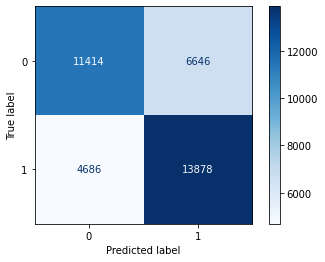

Regresion Logistica Validation


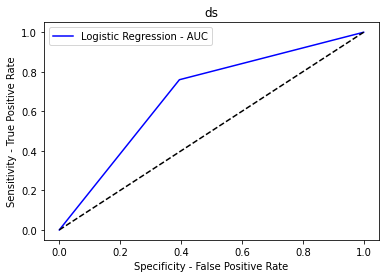

AUC: 0.6825982465808715
Confusion Matrix : 
 [[10540  6870]
 [ 4266 13494]]
Accuracy :  0.6833665055444982
Sensitivity :  0.6053991958644457
Specificity :  0.7597972972972973


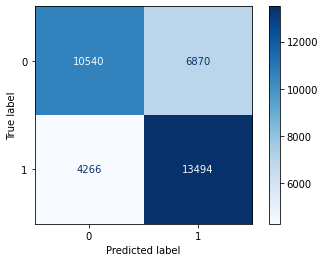

[[-461.9256      37.986633    14.340712  ...   -2.3872137   -6.918333
    -9.676699 ]
 [-453.95935     40.84214     13.285265  ...   -2.2336156   -7.3383017
   -10.662281 ]
 [-441.73483     48.792828    16.774529  ...   -3.44687    -10.184973
   -14.396601 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -79.153534   -34.108032
    13.913701 ]
 [-312.29477    145.09683     46.839935  ...  -71.44318    -35.34451
    10.800596 ]
 [-330.2163     145.90912     39.09671   ...  -66.536865   -34.597
     6.568719 ]]
(179136, 8)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 966.327190
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 0.999928
             

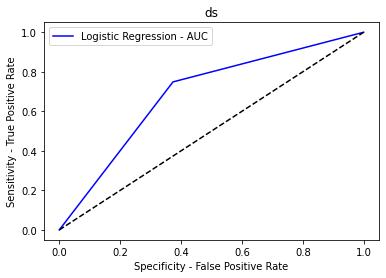

AUC: 0.6875865015057901
Confusion Matrix : 
 [[11313  6747]
 [ 4664 13900]]
Accuracy :  0.6884283529925732
Sensitivity :  0.6264119601328904
Specificity :  0.7487610428786899


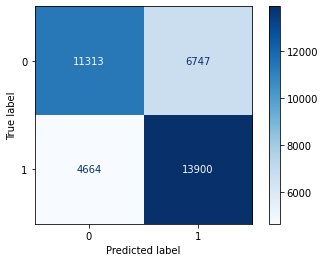

Regresion Logistica Validation


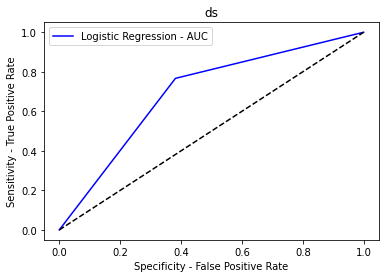

AUC: 0.6925791942861875
Confusion Matrix : 
 [[10765  6645]
 [ 4141 13619]]
Accuracy :  0.6933181688939437
Sensitivity :  0.6183228029867892
Specificity :  0.7668355855855856


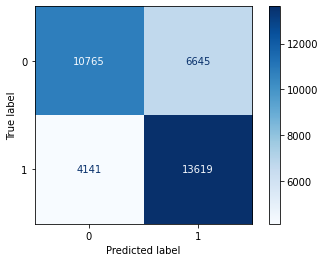

[[-461.9256      37.986633    14.340712  ...   -6.918333    -9.676699
    -7.8132167]
 [-453.95935     40.84214     13.285265  ...   -7.3383017  -10.662281
    -7.4927154]
 [-441.73483     48.792828    16.774529  ...  -10.184973   -14.396601
   -10.996808 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -34.108032    13.913701
   -29.214916 ]
 [-312.29477    145.09683     46.839935  ...  -35.34451     10.800596
   -21.054426 ]
 [-330.2163     145.90912     39.09671   ...  -34.597        6.568719
   -12.276783 ]]
(179136, 9)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1134.437323
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 0.995874
         

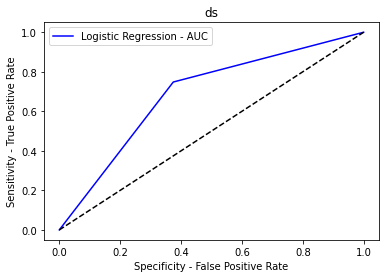

AUC: 0.6868195757730642
Confusion Matrix : 
 [[11296  6764]
 [ 4675 13889]]
Accuracy :  0.6876638269986893
Sensitivity :  0.6254706533776301
Specificity :  0.7481684981684982


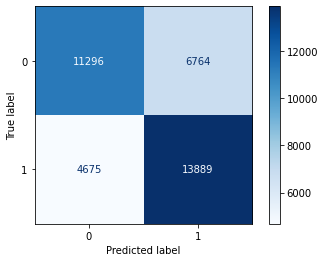

Regresion Logistica Validation


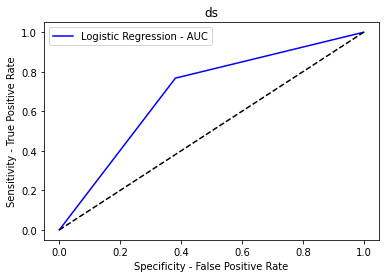

AUC: 0.6931726743975452
Confusion Matrix : 
 [[10769  6641]
 [ 4124 13636]]
Accuracy :  0.6939152686949104
Sensitivity :  0.6185525560022975
Specificity :  0.7677927927927928


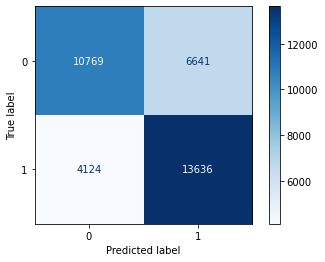

[[-461.9256      37.986633    14.340712  ...   -9.676699    -7.8132167
    -9.168781 ]
 [-453.95935     40.84214     13.285265  ...  -10.662281    -7.4927154
    -9.833818 ]
 [-441.73483     48.792828    16.774529  ...  -14.396601   -10.996808
   -13.579085 ]
 ...
 [-288.80374    133.47595     64.27397   ...   13.913701   -29.214916
   -29.069393 ]
 [-312.29477    145.09683     46.839935  ...   10.800596   -21.054426
   -36.612003 ]
 [-330.2163     145.90912     39.09671   ...    6.568719   -12.276783
   -43.515823 ]]
(179136, 10)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1414.626598
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.63      0.68     18060
           1       0.68      0.77      0.72     18564

    accuracy                           0.70     36624
   macro avg       0.70      0.70      0.70     36624
weighted avg       0.70      0.70      0.70     36624

Test time: 1.000166
      

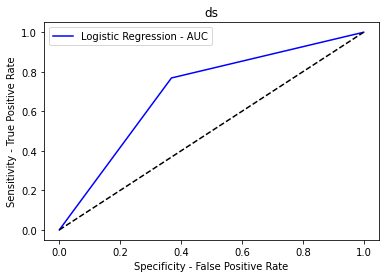

AUC: 0.7000990915149603
Confusion Matrix : 
 [[11405  6655]
 [ 4294 14270]]
Accuracy :  0.7010430318916557
Sensitivity :  0.6315060908084164
Specificity :  0.768692092221504


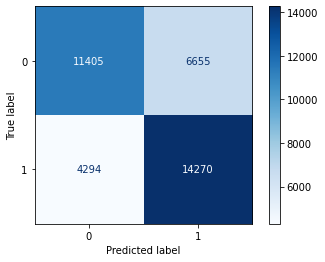

Regresion Logistica Validation


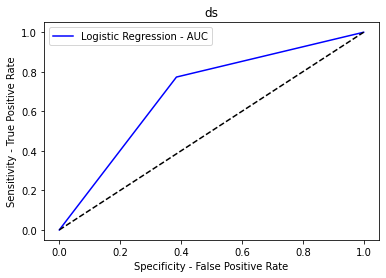

AUC: 0.6942085357902418
Confusion Matrix : 
 [[10709  6701]
 [ 4026 13734]]
Accuracy :  0.6949957350014216
Sensitivity :  0.6151062607696726
Specificity :  0.7733108108108108


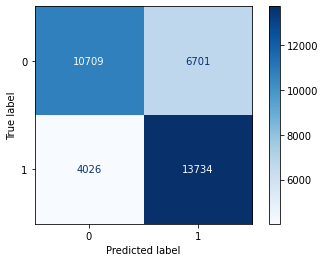

[[-461.9256      37.986633    14.340712  ...   -7.8132167   -9.168781
   -10.380377 ]
 [-453.95935     40.84214     13.285265  ...   -7.4927154   -9.833818
   -11.587559 ]
 [-441.73483     48.792828    16.774529  ...  -10.996808   -13.579085
   -16.023682 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.214916   -29.069393
   -48.466904 ]
 [-312.29477    145.09683     46.839935  ...  -21.054426   -36.612003
   -41.964684 ]
 [-330.2163     145.90912     39.09671   ...  -12.276783   -43.515823
   -35.94929  ]]
(179136, 11)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1763.998747
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.64      0.68     18060
           1       0.69      0.78      0.73     18564

    accuracy                           0.71     36624
   macro avg       0.71      0.71      0.71     36624
weighted avg       0.71      0.71      0.71     36624

Test time: 0.999928
        

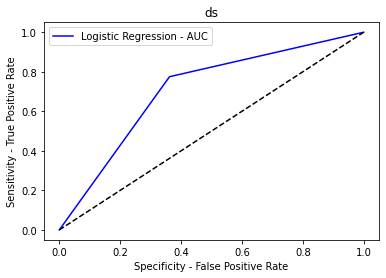

AUC: 0.7064603658994904
Confusion Matrix : 
 [[11519  6541]
 [ 4175 14389]]
Accuracy :  0.7074049803407602
Sensitivity :  0.6378183831672204
Specificity :  0.7751023486317604


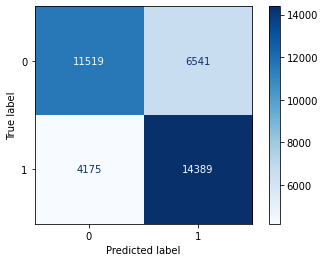

Regresion Logistica Validation


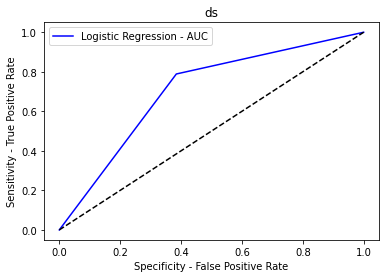

AUC: 0.7021511208221433
Confusion Matrix : 
 [[10715  6695]
 [ 3750 14010]]
Accuracy :  0.7030139323286893
Sensitivity :  0.6154508902929351
Specificity :  0.7888513513513513


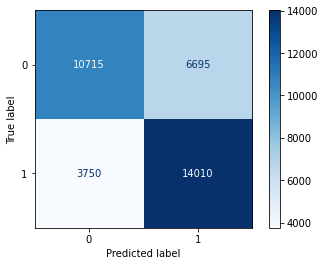

[[-461.9256      37.986633    14.340712  ...   -9.168781   -10.380377
    -8.284298 ]
 [-453.95935     40.84214     13.285265  ...   -9.833818   -11.587559
    -8.15322  ]
 [-441.73483     48.792828    16.774529  ...  -13.579085   -16.023682
   -11.017866 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.069393   -48.466904
     5.8222713]
 [-312.29477    145.09683     46.839935  ...  -36.612003   -41.964684
     0.5614144]
 [-330.2163     145.90912     39.09671   ...  -43.515823   -35.94929
    -4.6305156]]
(179136, 12)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1798.332453
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     18060
           1       0.69      0.80      0.74     18564

    accuracy                           0.72     36624
   macro avg       0.72      0.72      0.72     36624
weighted avg       0.72      0.72      0.72     36624

Test time: 0.999928
         

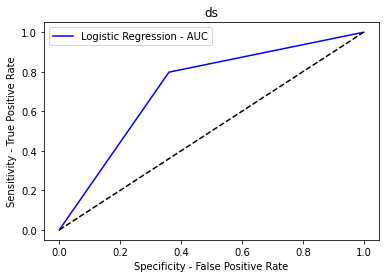

AUC: 0.7188470558169601
Confusion Matrix : 
 [[11551  6509]
 [ 3748 14816]]
Accuracy :  0.7199377457404981
Sensitivity :  0.6395902547065337
Specificity :  0.7981038569273864


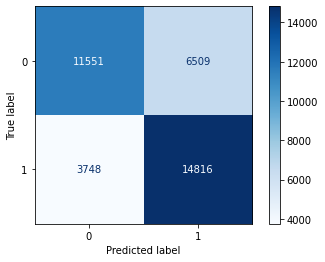

Regresion Logistica Validation


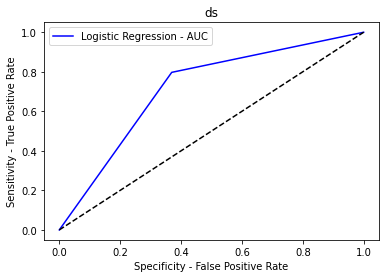

AUC: 0.7138433306942784
Confusion Matrix : 
 [[10979  6431]
 [ 3604 14156]]
Accuracy :  0.7146715951094683
Sensitivity :  0.6306145893164847
Specificity :  0.7970720720720721


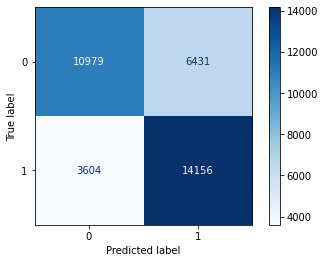

[[-461.9256       37.986633     14.340712   ...  -10.380377
    -8.284298     -7.0208225 ]
 [-453.95935      40.84214      13.285265   ...  -11.587559
    -8.15322      -7.858124  ]
 [-441.73483      48.792828     16.774529   ...  -16.023682
   -11.017866    -10.613985  ]
 ...
 [-288.80374     133.47595      64.27397    ...  -48.466904
     5.8222713    -4.2369475 ]
 [-312.29477     145.09683      46.839935   ...  -41.964684
     0.5614144    -0.96565664]
 [-330.2163      145.90912      39.09671    ...  -35.94929
    -4.6305156     1.540931  ]]
(179136, 13)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2091.556549
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624


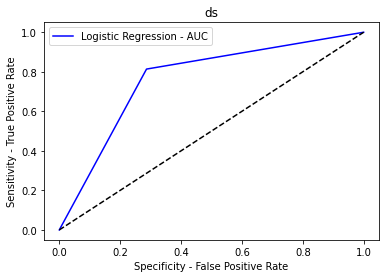

AUC: 0.7635357005056047
Confusion Matrix : 
 [[12884  5176]
 [ 3459 15105]]
Accuracy :  0.7642256443861949
Sensitivity :  0.7133997785160576
Specificity :  0.8136716224951519


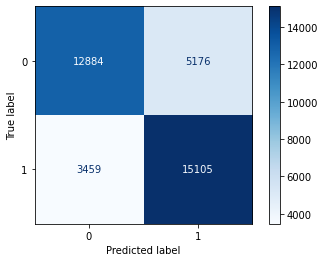

Regresion Logistica Validation


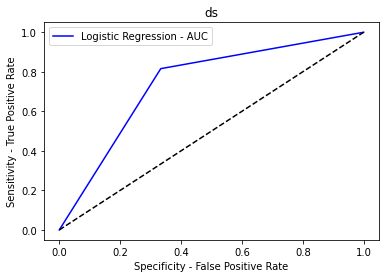

AUC: 0.7412252232847437
Confusion Matrix : 
 [[11606  5804]
 [ 3271 14489]]
Accuracy :  0.7419675860108047
Sensitivity :  0.6666283744974153
Specificity :  0.815822072072072


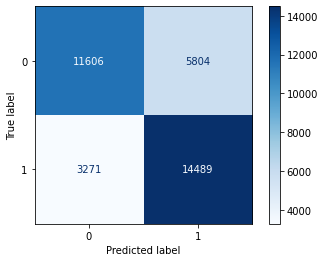

[[-461.9256       37.986633     14.340712   ...   -8.284298
    -7.0208225    34.750076  ]
 [-453.95935      40.84214      13.285265   ...   -8.15322
    -7.858124     34.750076  ]
 [-441.73483      48.792828     16.774529   ...  -11.017866
   -10.613985     34.750076  ]
 ...
 [-288.80374     133.47595      64.27397    ...    5.8222713
    -4.2369475   -22.168613  ]
 [-312.29477     145.09683      46.839935   ...    0.5614144
    -0.96565664  -22.168613  ]
 [-330.2163      145.90912      39.09671    ...   -4.6305156
     1.540931    -22.168613  ]]
(179136, 14)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2324.586153
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     366

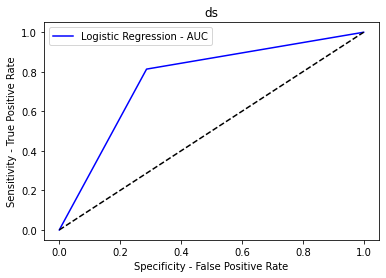

AUC: 0.7633995279686115
Confusion Matrix : 
 [[12882  5178]
 [ 3462 15102]]
Accuracy :  0.7640891218872871
Sensitivity :  0.7132890365448505
Specificity :  0.8135100193923723


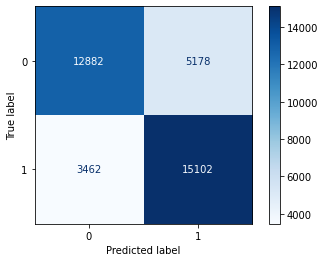

Regresion Logistica Validation


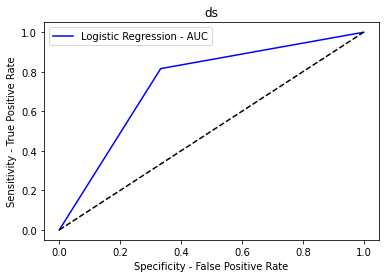

AUC: 0.7414245592519574
Confusion Matrix : 
 [[11610  5800]
 [ 3268 14492]]
Accuracy :  0.7421666192777936
Sensitivity :  0.6668581275129236
Specificity :  0.815990990990991


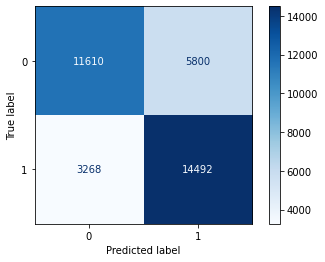

[[-461.9256       37.986633     14.340712   ...   -7.0208225
    34.750076     11.849575  ]
 [-453.95935      40.84214      13.285265   ...   -7.858124
    34.750076     11.849575  ]
 [-441.73483      48.792828     16.774529   ...  -10.613985
    34.750076     11.849575  ]
 ...
 [-288.80374     133.47595      64.27397    ...   -4.2369475
   -22.168613      2.5972106 ]
 [-312.29477     145.09683      46.839935   ...   -0.96565664
   -22.168613      2.5972106 ]
 [-330.2163      145.90912      39.09671    ...    1.540931
   -22.168613      2.5972106 ]]
(179136, 15)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2994.562387
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     3

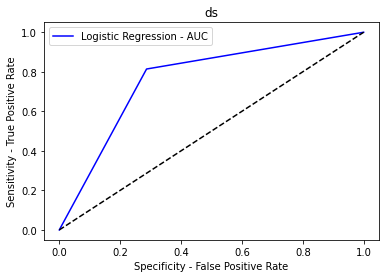

AUC: 0.7636419326227808
Confusion Matrix : 
 [[12882  5178]
 [ 3453 15111]]
Accuracy :  0.7643348623853211
Sensitivity :  0.7132890365448505
Specificity :  0.813994828700711


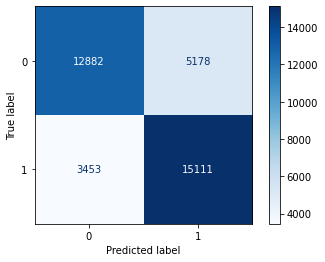

Regresion Logistica Validation


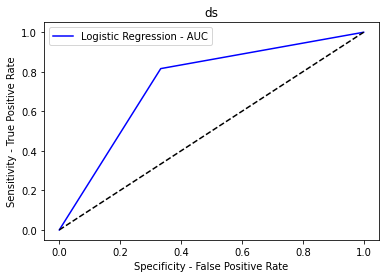

AUC: 0.7413665550242948
Confusion Matrix : 
 [[11607  5803]
 [ 3267 14493]]
Accuracy :  0.7421097526300825
Sensitivity :  0.6666858127512924
Specificity :  0.8160472972972973


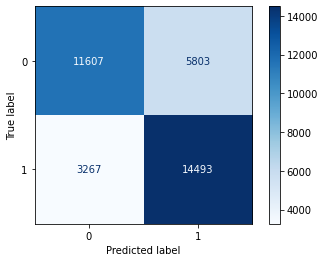

[[-461.9256      37.986633    14.340712  ...   34.750076    11.849575
    -4.480244 ]
 [-453.95935     40.84214     13.285265  ...   34.750076    11.849575
    -4.480244 ]
 [-441.73483     48.792828    16.774529  ...   34.750076    11.849575
    -4.480244 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -22.168613     2.5972106
    -7.6987762]
 [-312.29477    145.09683     46.839935  ...  -22.168613     2.5972106
    -7.6987762]
 [-330.2163     145.90912     39.09671   ...  -22.168613     2.5972106
    -7.6987762]]
(179136, 16)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 3590.018511
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 2.000093
     

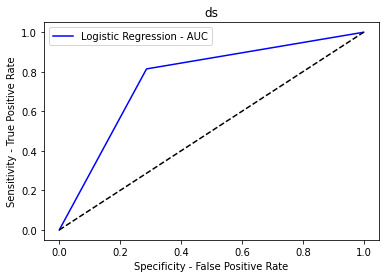

AUC: 0.7639397082625536
Confusion Matrix : 
 [[12884  5176]
 [ 3444 15120]]
Accuracy :  0.7646352118829183
Sensitivity :  0.7133997785160576
Specificity :  0.8144796380090498


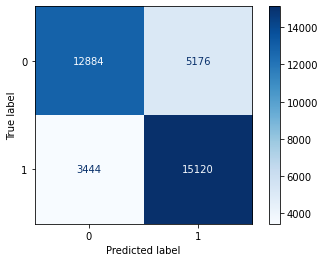

Regresion Logistica Validation


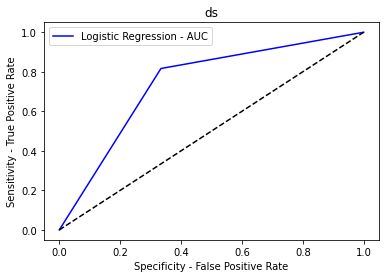

AUC: 0.7412747379056254
Confusion Matrix : 
 [[11594  5816]
 [ 3257 14503]]
Accuracy :  0.7420244526585158
Sensitivity :  0.6659391154508902
Specificity :  0.8166103603603604


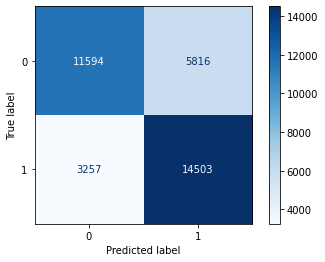

[[-461.9256      37.986633    14.340712  ...   11.849575    -4.480244
    -1.1167117]
 [-453.95935     40.84214     13.285265  ...   11.849575    -4.480244
    -1.1167117]
 [-441.73483     48.792828    16.774529  ...   11.849575    -4.480244
    -1.1167117]
 ...
 [-288.80374    133.47595     64.27397   ...    2.5972106   -7.6987762
     8.06751  ]
 [-312.29477    145.09683     46.839935  ...    2.5972106   -7.6987762
     8.06751  ]
 [-330.2163     145.90912     39.09671   ...    2.5972106   -7.6987762
     8.06751  ]]
(179136, 17)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4191.435099
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.75      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 1.000166
     

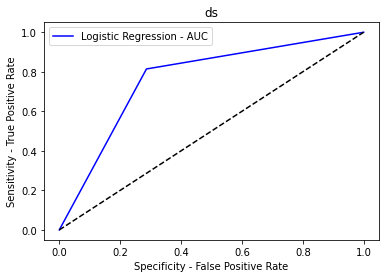

AUC: 0.7639157809814443
Confusion Matrix : 
 [[12888  5172]
 [ 3449 15115]]
Accuracy :  0.7646079073831368
Sensitivity :  0.7136212624584718
Specificity :  0.8142102995044171


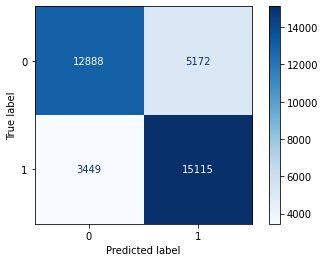

Regresion Logistica Validation


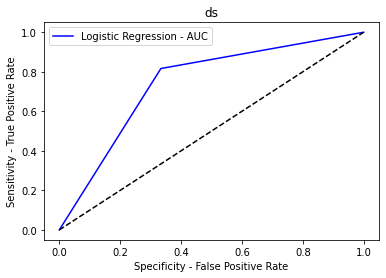

AUC: 0.7413333081070732
Confusion Matrix : 
 [[11598  5812]
 [ 3259 14501]]
Accuracy :  0.7420813193062269
Sensitivity :  0.6661688684663987
Specificity :  0.8164977477477477


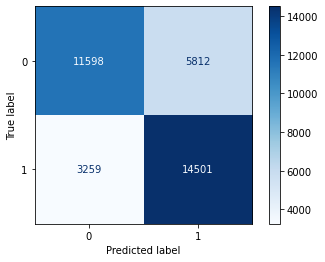

[[-461.9256      37.986633    14.340712  ...   -4.480244    -1.1167117
     0.8289675]
 [-453.95935     40.84214     13.285265  ...   -4.480244    -1.1167117
     0.8289675]
 [-441.73483     48.792828    16.774529  ...   -4.480244    -1.1167117
     0.8289675]
 ...
 [-288.80374    133.47595     64.27397   ...   -7.6987762    8.06751
    -5.9553585]
 [-312.29477    145.09683     46.839935  ...   -7.6987762    8.06751
    -5.9553585]
 [-330.2163     145.90912     39.09671   ...   -7.6987762    8.06751
    -5.9553585]]
(179136, 18)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4994.771481
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 1.996517
        

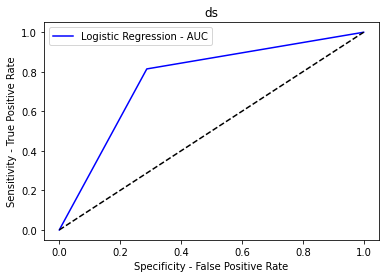

AUC: 0.7634698065272619
Confusion Matrix : 
 [[12868  5192]
 [ 3445 15119]]
Accuracy :  0.7641710353866317
Sensitivity :  0.7125138427464008
Specificity :  0.8144257703081232


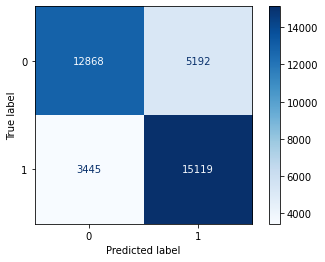

Regresion Logistica Validation


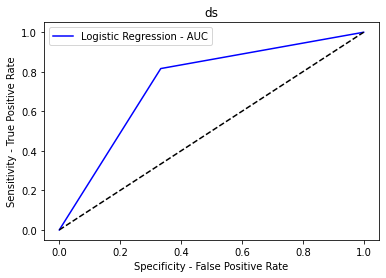

AUC: 0.7414504485099689
Confusion Matrix : 
 [[11606  5804]
 [ 3263 14497]]
Accuracy :  0.7421950526016491
Sensitivity :  0.6666283744974153
Specificity :  0.8162725225225225


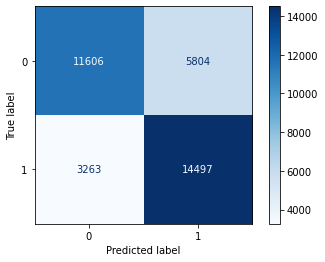

[[-461.9256      37.986633    14.340712  ...   -1.1167117    0.8289675
    -2.4867694]
 [-453.95935     40.84214     13.285265  ...   -1.1167117    0.8289675
    -2.4867694]
 [-441.73483     48.792828    16.774529  ...   -1.1167117    0.8289675
    -2.4867694]
 ...
 [-288.80374    133.47595     64.27397   ...    8.06751     -5.9553585
    -0.5493061]
 [-312.29477    145.09683     46.839935  ...    8.06751     -5.9553585
    -0.5493061]
 [-330.2163     145.90912     39.09671   ...    8.06751     -5.9553585
    -0.5493061]]
(179136, 19)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4741.444349
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 2.002239
  

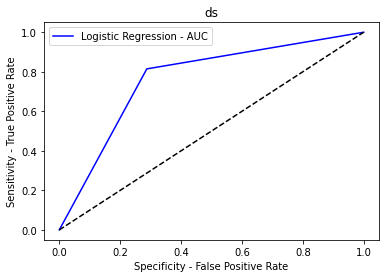

AUC: 0.7635498564363132
Confusion Matrix : 
 [[12867  5193]
 [ 3441 15123]]
Accuracy :  0.7642529488859764
Sensitivity :  0.7124584717607974
Specificity :  0.8146412411118293


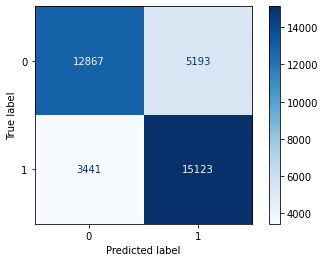

Regresion Logistica Validation


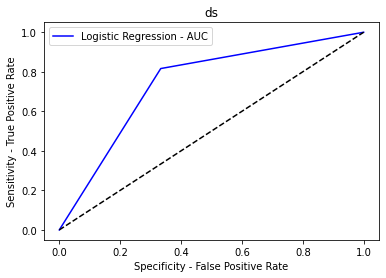

AUC: 0.7415073207900607
Confusion Matrix : 
 [[11607  5803]
 [ 3262 14498]]
Accuracy :  0.7422519192493603
Sensitivity :  0.6666858127512924
Specificity :  0.8163288288288288


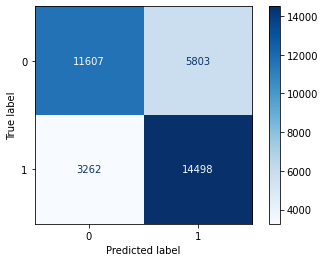

[[-461.9256      37.986633    14.340712  ...    0.8289675   -2.4867694
    -3.428612 ]
 [-453.95935     40.84214     13.285265  ...    0.8289675   -2.4867694
    -3.428612 ]
 [-441.73483     48.792828    16.774529  ...    0.8289675   -2.4867694
    -3.428612 ]
 ...
 [-288.80374    133.47595     64.27397   ...   -5.9553585   -0.5493061
     0.7607682]
 [-312.29477    145.09683     46.839935  ...   -5.9553585   -0.5493061
     0.7607682]
 [-330.2163     145.90912     39.09671   ...   -5.9553585   -0.5493061
     0.7607682]]
(179136, 20)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4917.774916
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 1.996279
  

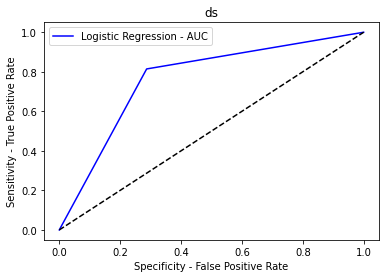

AUC: 0.7636651082615514
Confusion Matrix : 
 [[12877  5183]
 [ 3447 15117]]
Accuracy :  0.7643621668851026
Sensitivity :  0.7130121816168328
Specificity :  0.8143180349062702


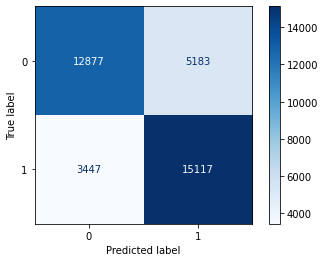

Regresion Logistica Validation


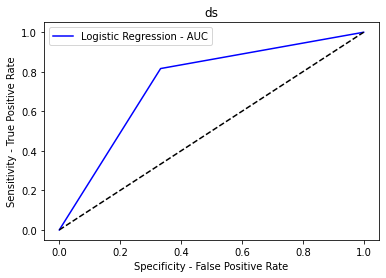

AUC: 0.741737073805569
Confusion Matrix : 
 [[11615  5795]
 [ 3262 14498]]
Accuracy :  0.7424793858402047
Sensitivity :  0.667145318782309
Specificity :  0.8163288288288288


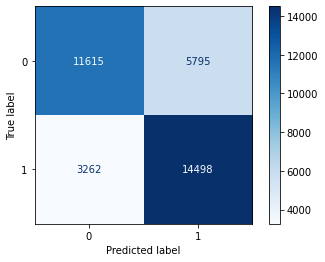

[[-461.9256      37.986633    14.340712  ...   -2.4867694   -3.428612
     1.4363935]
 [-453.95935     40.84214     13.285265  ...   -2.4867694   -3.428612
     1.4363935]
 [-441.73483     48.792828    16.774529  ...   -2.4867694   -3.428612
     1.4363935]
 ...
 [-288.80374    133.47595     64.27397   ...   -0.5493061    0.7607682
     1.509518 ]
 [-312.29477    145.09683     46.839935  ...   -0.5493061    0.7607682
     1.509518 ]
 [-330.2163     145.90912     39.09671   ...   -0.5493061    0.7607682
     1.509518 ]]
(179136, 21)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4986.387253
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624

Test time: 0.999928
     

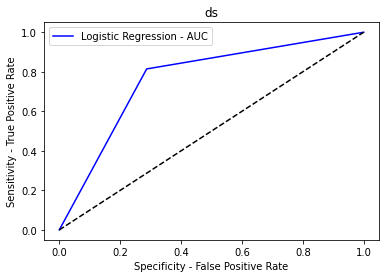

AUC: 0.763664356619213
Confusion Matrix : 
 [[12876  5184]
 [ 3446 15118]]
Accuracy :  0.7643621668851026
Sensitivity :  0.7129568106312293
Specificity :  0.8143719026071967


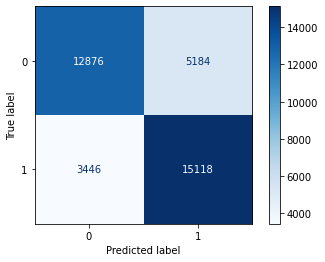

Regresion Logistica Validation


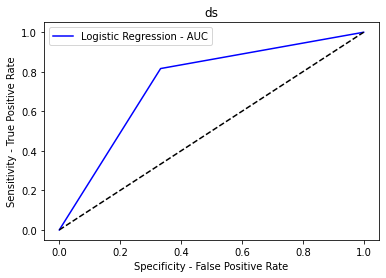

AUC: 0.741737073805569
Confusion Matrix : 
 [[11615  5795]
 [ 3262 14498]]
Accuracy :  0.7424793858402047
Sensitivity :  0.667145318782309
Specificity :  0.8163288288288288


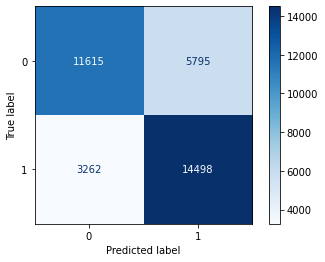

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -3.4286120e+00
   1.4363935e+00  7.4176920e-02]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -3.4286120e+00
   1.4363935e+00  7.4176920e-02]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -3.4286120e+00
   1.4363935e+00  7.4176920e-02]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  7.6076820e-01
   1.5095180e+00  3.1005840e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  7.6076820e-01
   1.5095180e+00  3.1005840e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  7.6076820e-01
   1.5095180e+00  3.1005840e+00]]
(179136, 22)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5174.664021
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weigh

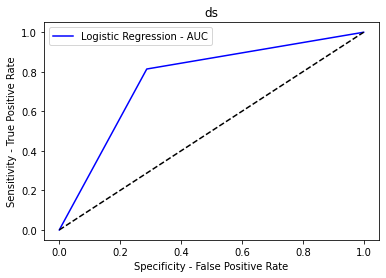

AUC: 0.7633097067091595
Confusion Matrix : 
 [[12870  5190]
 [ 3453 15111]]
Accuracy :  0.7640072083879423
Sensitivity :  0.7126245847176079
Specificity :  0.813994828700711


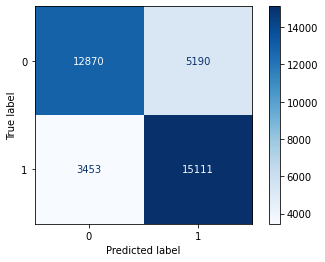

Regresion Logistica Validation


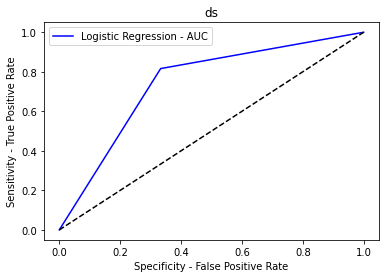

AUC: 0.7415946101184472
Confusion Matrix : 
 [[11612  5798]
 [ 3264 14496]]
Accuracy :  0.7423372192209269
Sensitivity :  0.6669730040206777
Specificity :  0.8162162162162162


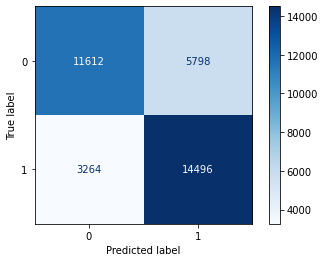

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.4363935e+00
   7.4176920e-02 -7.1062240e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.4363935e+00
   7.4176920e-02 -7.1062240e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.4363935e+00
   7.4176920e-02 -7.1062240e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.5095180e+00
   3.1005840e+00 -5.4956660e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.5095180e+00
   3.1005840e+00 -5.4956660e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.5095180e+00
   3.1005840e+00 -5.4956660e+00]]
(179136, 23)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5949.872255
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weigh

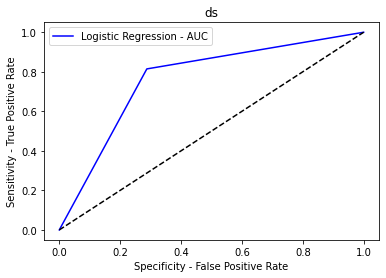

AUC: 0.7634413693921219
Confusion Matrix : 
 [[12866  5194]
 [ 3444 15120]]
Accuracy :  0.7641437308868502
Sensitivity :  0.7124031007751938
Specificity :  0.8144796380090498


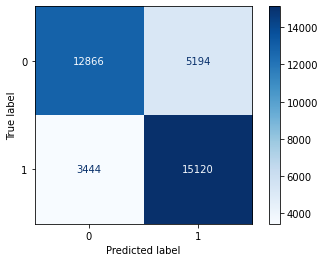

Regresion Logistica Validation


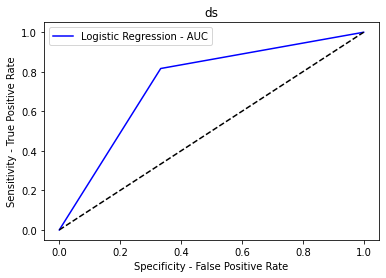

AUC: 0.7416773716565503
Confusion Matrix : 
 [[11609  5801]
 [ 3258 14502]]
Accuracy :  0.7424225191924936
Sensitivity :  0.6668006892590466
Specificity :  0.816554054054054


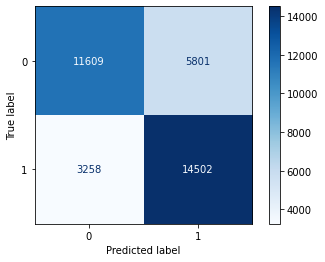

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  7.4176920e-02
  -7.1062240e-01 -2.4373570e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  7.4176920e-02
  -7.1062240e-01 -2.4373570e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  7.4176920e-02
  -7.1062240e-01 -2.4373570e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  3.1005840e+00
  -5.4956660e+00  5.3983605e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  3.1005840e+00
  -5.4956660e+00  5.3983605e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  3.1005840e+00
  -5.4956660e+00  5.3983605e-01]]
(179136, 24)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5827.811003
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weigh

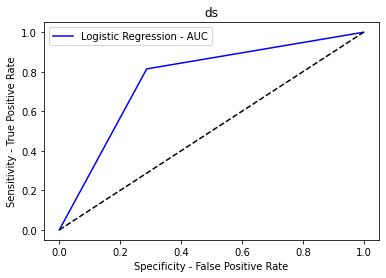

AUC: 0.7636621016921975
Confusion Matrix : 
 [[12873  5187]
 [ 3443 15121]]
Accuracy :  0.7643621668851026
Sensitivity :  0.7127906976744186
Specificity :  0.8145335057099763


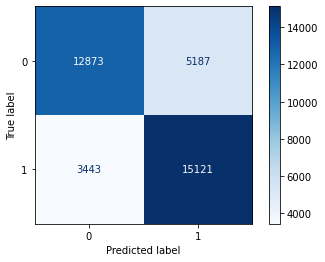

Regresion Logistica Validation


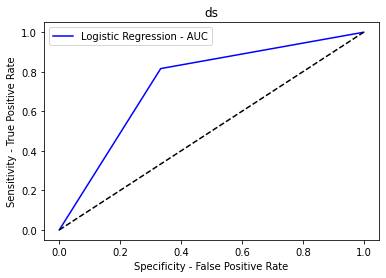

AUC: 0.7414515804575397
Confusion Matrix : 
 [[11608  5802]
 [ 3265 14495]]
Accuracy :  0.7421950526016491
Sensitivity :  0.6667432510051694
Specificity :  0.8161599099099099


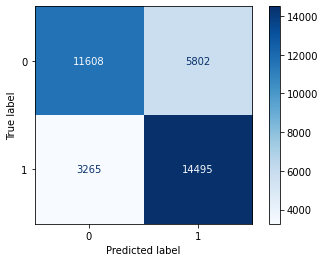

[[-461.9256       37.986633     14.340712   ...   -0.7106224
    -2.437357     -1.6989802 ]
 [-453.95935      40.84214      13.285265   ...   -0.7106224
    -2.437357     -1.6989802 ]
 [-441.73483      48.792828     16.774529   ...   -0.7106224
    -2.437357     -1.6989802 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -5.495666
     0.53983605    1.7264409 ]
 [-312.29477     145.09683      46.839935   ...   -5.495666
     0.53983605    1.7264409 ]
 [-330.2163      145.90912      39.09671    ...   -5.495666
     0.53983605    1.7264409 ]]
(179136, 25)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 6527.238846
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36

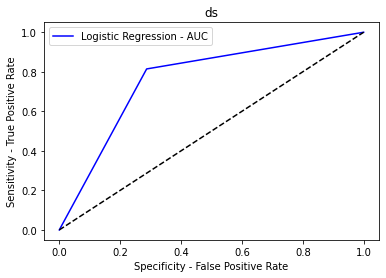

AUC: 0.7636920421120148
Confusion Matrix : 
 [[12877  5183]
 [ 3446 15118]]
Accuracy :  0.7643894713848842
Sensitivity :  0.7130121816168328
Specificity :  0.8143719026071967


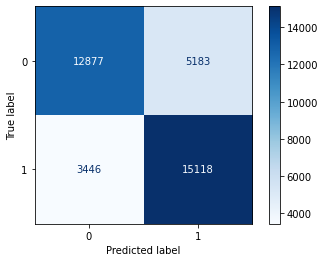

Regresion Logistica Validation


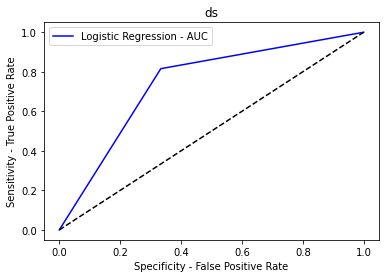

AUC: 0.7410827595976217
Confusion Matrix : 
 [[11603  5807]
 [ 3273 14487]]
Accuracy :  0.7418254193915269
Sensitivity :  0.666456059735784
Specificity :  0.8157094594594595


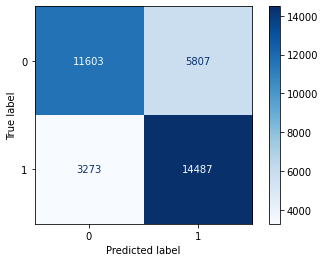

[[-461.9256       37.986633     14.340712   ...   -2.437357
    -1.6989802    -3.025631  ]
 [-453.95935      40.84214      13.285265   ...   -2.437357
    -1.6989802    -3.025631  ]
 [-441.73483      48.792828     16.774529   ...   -2.437357
    -1.6989802    -3.025631  ]
 ...
 [-288.80374     133.47595      64.27397    ...    0.53983605
     1.7264409     0.7650625 ]
 [-312.29477     145.09683      46.839935   ...    0.53983605
     1.7264409     0.7650625 ]
 [-330.2163      145.90912      39.09671    ...    0.53983605
     1.7264409     0.7650625 ]]
(179136, 26)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 6375.920534
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76    

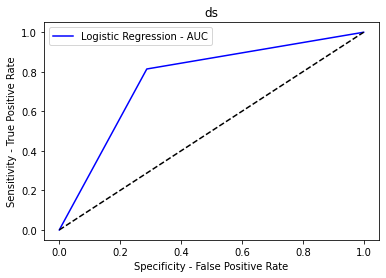

AUC: 0.7633082034244825
Confusion Matrix : 
 [[12868  5192]
 [ 3451 15113]]
Accuracy :  0.7640072083879423
Sensitivity :  0.7125138427464008
Specificity :  0.8141025641025641


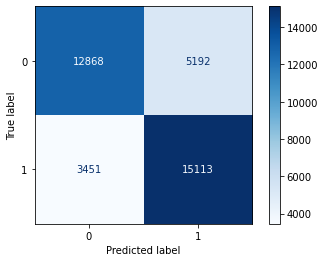

Regresion Logistica Validation


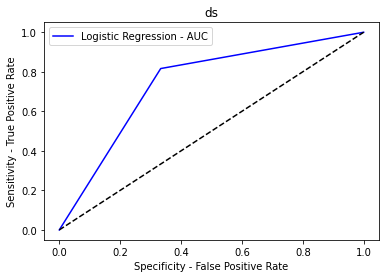

AUC: 0.7415647590439377
Confusion Matrix : 
 [[11609  5801]
 [ 3262 14498]]
Accuracy :  0.7423087858970714
Sensitivity :  0.6668006892590466
Specificity :  0.8163288288288288


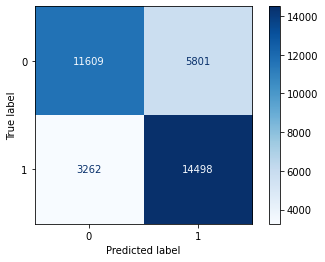

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -1.6989802e+00
  -3.0256310e+00  4.6011240e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -1.6989802e+00
  -3.0256310e+00  4.6011240e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.6989802e+00
  -3.0256310e+00  4.6011240e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.7264409e+00
   7.6506250e-01  7.0490720e-02]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.7264409e+00
   7.6506250e-01  7.0490720e-02]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.7264409e+00
   7.6506250e-01  7.0490720e-02]]
(179136, 27)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 6864.435434
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.82      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weigh

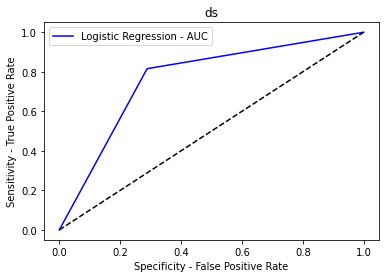

AUC: 0.7635348235895432
Confusion Matrix : 
 [[12847  5213]
 [ 3421 15143]]
Accuracy :  0.7642529488859764
Sensitivity :  0.7113510520487265
Specificity :  0.8157185951303598


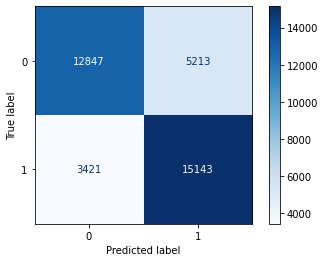

Regresion Logistica Validation


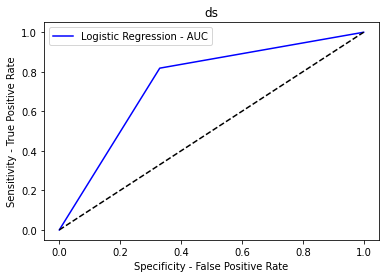

AUC: 0.7441296713859178
Confusion Matrix : 
 [[11664  5746]
 [ 3227 14533]]
Accuracy :  0.7448677850440717
Sensitivity :  0.669959793222286
Specificity :  0.8182995495495495


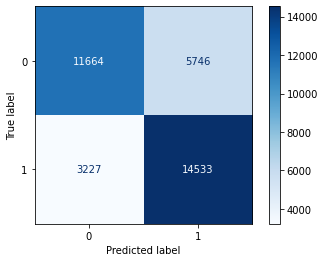

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -3.0256310e+00
   4.6011240e+00 -1.3356032e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -3.0256310e+00
   4.6011240e+00 -1.3356032e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -3.0256310e+00
   4.6011240e+00 -1.3356032e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  7.6506250e-01
   7.0490720e-02  2.2018990e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  7.6506250e-01
   7.0490720e-02  2.2018990e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  7.6506250e-01
   7.0490720e-02  2.2018990e+00]]
(179136, 28)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7179.149389
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.76      0.76     36624
weigh

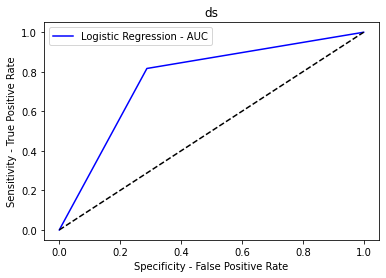

AUC: 0.7644618491403717
Confusion Matrix : 
 [[12862  5198]
 [ 3402 15162]]
Accuracy :  0.7651813018785496
Sensitivity :  0.7121816168327796
Specificity :  0.8167420814479638


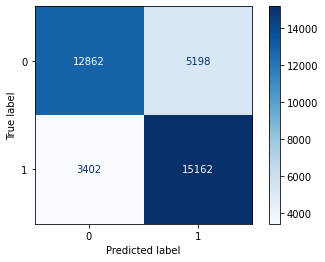

Regresion Logistica Validation


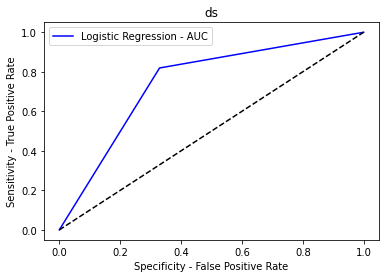

AUC: 0.7449241853858454
Confusion Matrix : 
 [[11675  5735]
 [ 3210 14550]]
Accuracy :  0.7456639181120273
Sensitivity :  0.670591614014934
Specificity :  0.8192567567567568


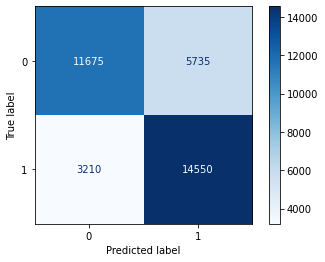

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  4.6011240e+00
  -1.3356032e+00 -1.2167931e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  4.6011240e+00
  -1.3356032e+00 -1.2167931e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  4.6011240e+00
  -1.3356032e+00 -1.2167931e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  7.0490720e-02
   2.2018990e+00 -3.5142086e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  7.0490720e-02
   2.2018990e+00 -3.5142086e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  7.0490720e-02
   2.2018990e+00 -3.5142086e+00]]
(179136, 29)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7271.666050
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

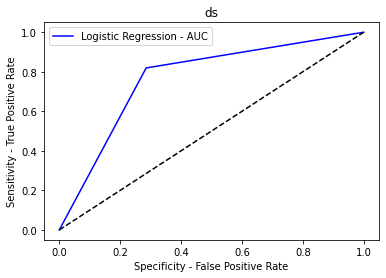

AUC: 0.7669982662116726
Confusion Matrix : 
 [[12904  5156]
 [ 3351 15213]]
Accuracy :  0.7677206203582351
Sensitivity :  0.7145071982281285
Specificity :  0.8194893341952165


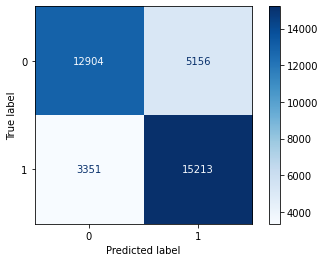

Regresion Logistica Validation


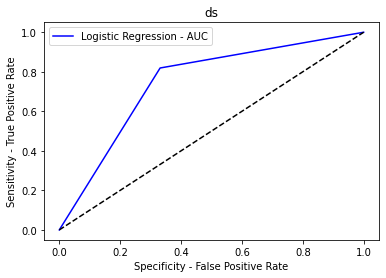

AUC: 0.7439488670175058
Confusion Matrix : 
 [[11643  5767]
 [ 3212 14548]]
Accuracy :  0.7446971851009383
Sensitivity :  0.6687535898908673
Specificity :  0.8191441441441442


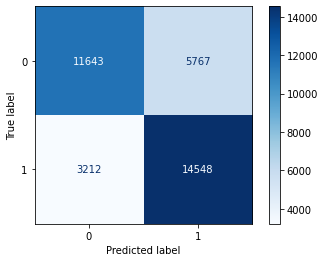

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -1.3356032e+00
  -1.2167931e+00  1.2784125e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -1.3356032e+00
  -1.2167931e+00  1.2784125e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.3356032e+00
  -1.2167931e+00  1.2784125e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  2.2018990e+00
  -3.5142086e+00 -9.2348160e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  2.2018990e+00
  -3.5142086e+00 -9.2348160e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  2.2018990e+00
  -3.5142086e+00 -9.2348160e-01]]
(179136, 30)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 6972.707987
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

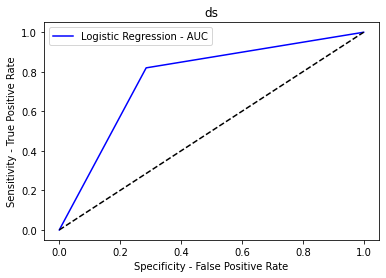

AUC: 0.7672152403000556
Confusion Matrix : 
 [[12906  5154]
 [ 3345 15219]]
Accuracy :  0.7679390563564875
Sensitivity :  0.7146179401993356
Specificity :  0.8198125404007757


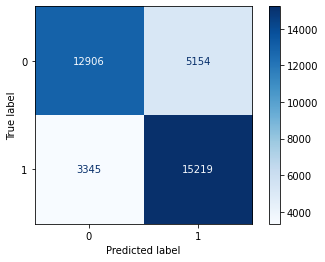

Regresion Logistica Validation


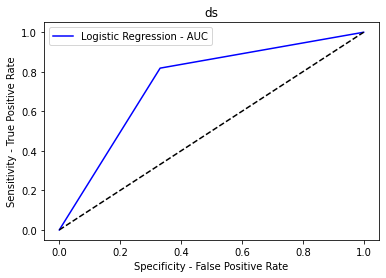

AUC: 0.7435541568995763
Confusion Matrix : 
 [[11642  5768]
 [ 3225 14535]]
Accuracy :  0.7442991185669605
Sensitivity :  0.6686961516369903
Specificity :  0.8184121621621622


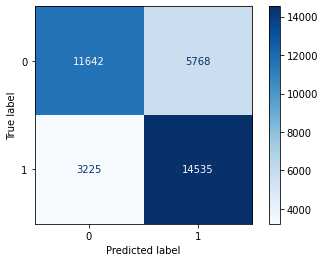

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -1.2167931e+00
   1.2784125e-01  5.3244280e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -1.2167931e+00
   1.2784125e-01  5.3244280e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.2167931e+00
   1.2784125e-01  5.3244280e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -3.5142086e+00
  -9.2348160e-01  4.4920880e-03]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -3.5142086e+00
  -9.2348160e-01  4.4920880e-03]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -3.5142086e+00
  -9.2348160e-01  4.4920880e-03]]
(179136, 31)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7215.499163
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

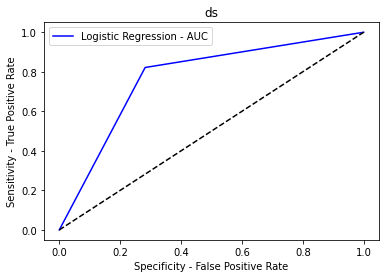

AUC: 0.769819054634376
Confusion Matrix : 
 [[12966  5094]
 [ 3310 15254]]
Accuracy :  0.7705329838357361
Sensitivity :  0.7179401993355482
Specificity :  0.821697909933204


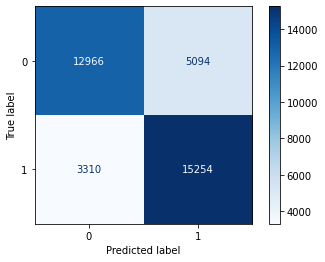

Regresion Logistica Validation


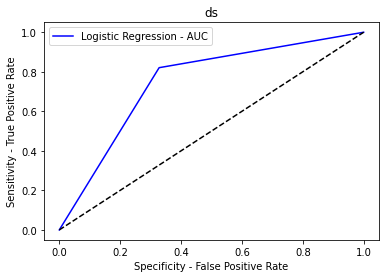

AUC: 0.7463454264143523
Confusion Matrix : 
 [[11699  5711]
 [ 3184 14576]]
Accuracy :  0.7470855843048052
Sensitivity :  0.671970132107984
Specificity :  0.8207207207207208


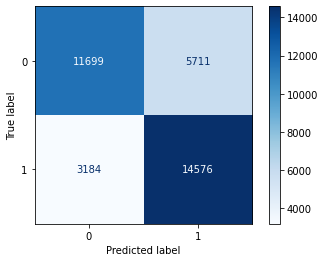

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.2784125e-01
   5.3244280e-01  1.5085448e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.2784125e-01
   5.3244280e-01  1.5085448e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.2784125e-01
   5.3244280e-01  1.5085448e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -9.2348160e-01
   4.4920880e-03  2.9756954e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -9.2348160e-01
   4.4920880e-03  2.9756954e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -9.2348160e-01
   4.4920880e-03  2.9756954e+00]]
(179136, 32)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7377.284050
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

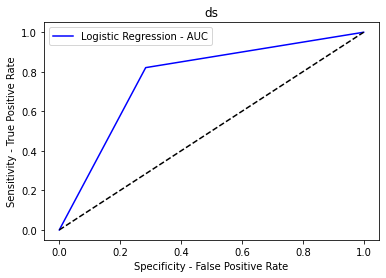

AUC: 0.768582978808697
Confusion Matrix : 
 [[12934  5126]
 [ 3323 15241]]
Accuracy :  0.7693042813455657
Sensitivity :  0.7161683277962347
Specificity :  0.8209976298211592


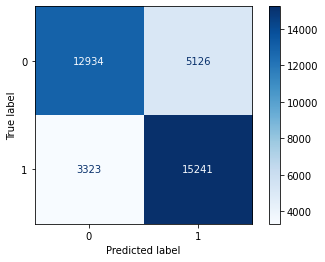

Regresion Logistica Validation


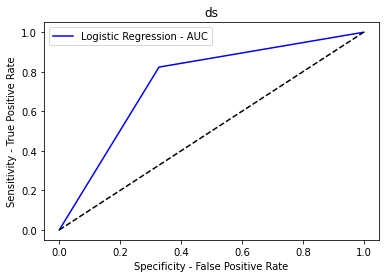

AUC: 0.7480391433938246
Confusion Matrix : 
 [[11707  5703]
 [ 3132 14628]]
Accuracy :  0.7487915837361387
Sensitivity :  0.6724296381390006
Specificity :  0.8236486486486486


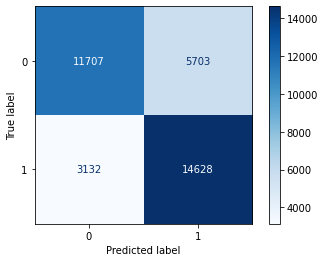

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  5.3244280e-01
   1.5085448e-01  1.5424095e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  5.3244280e-01
   1.5085448e-01  1.5424095e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  5.3244280e-01
   1.5085448e-01  1.5424095e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  4.4920880e-03
   2.9756954e+00 -6.6918576e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  4.4920880e-03
   2.9756954e+00 -6.6918576e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  4.4920880e-03
   2.9756954e+00 -6.6918576e-01]]
(179136, 33)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7827.873468
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

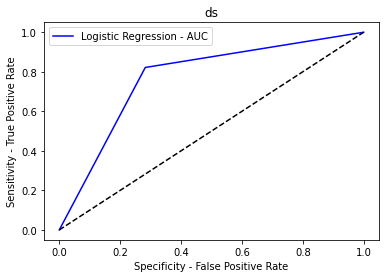

AUC: 0.7696237529000867
Confusion Matrix : 
 [[12957  5103]
 [ 3308 15256]]
Accuracy :  0.7703418523372652
Sensitivity :  0.7174418604651163
Specificity :  0.8218056453350571


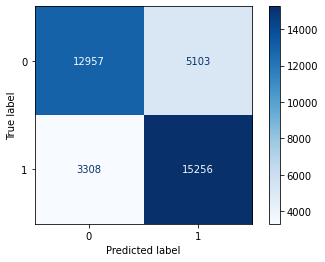

Regresion Logistica Validation


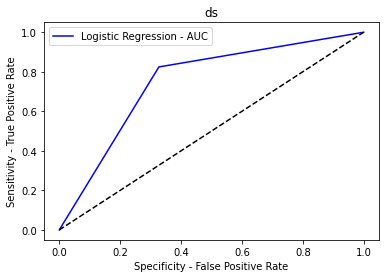

AUC: 0.7486337554527531
Confusion Matrix : 
 [[11713  5697]
 [ 3117 14643]]
Accuracy :  0.7493886835371055
Sensitivity :  0.6727742676622631
Specificity :  0.8244932432432432


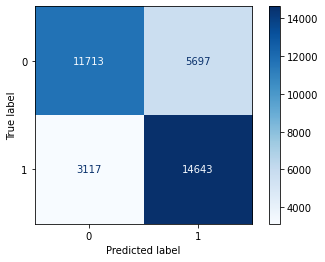

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.5085448e-01
   1.5424095e-01  1.0400269e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.5085448e-01
   1.5424095e-01  1.0400269e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.5085448e-01
   1.5424095e-01  1.0400269e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  2.9756954e+00
  -6.6918576e-01 -1.6740899e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  2.9756954e+00
  -6.6918576e-01 -1.6740899e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  2.9756954e+00
  -6.6918576e-01 -1.6740899e+00]]
(179136, 34)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7792.674541
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

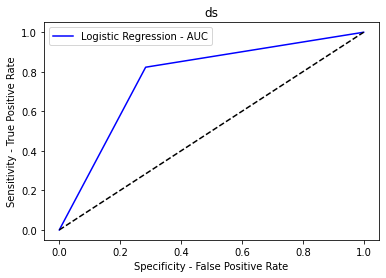

AUC: 0.7696887699623678
Confusion Matrix : 
 [[12936  5124]
 [ 3284 15280]]
Accuracy :  0.7704237658366099
Sensitivity :  0.7162790697674418
Specificity :  0.8230984701572936


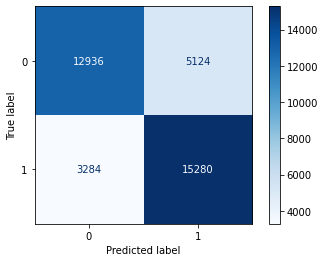

Regresion Logistica Validation


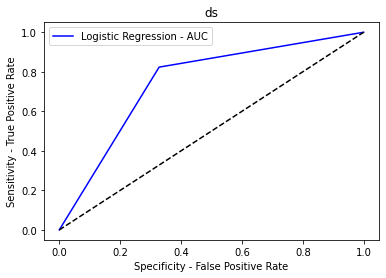

AUC: 0.7477536500457954
Confusion Matrix : 
 [[11700  5710]
 [ 3135 14625]]
Accuracy :  0.7485072504975832
Sensitivity :  0.672027570361861
Specificity :  0.8234797297297297


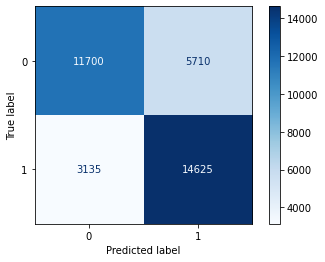

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.5424095e-01
   1.0400269e+00  5.1074250e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.5424095e-01
   1.0400269e+00  5.1074250e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.5424095e-01
   1.0400269e+00  5.1074250e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -6.6918576e-01
  -1.6740899e+00  1.3099920e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -6.6918576e-01
  -1.6740899e+00  1.3099920e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -6.6918576e-01
  -1.6740899e+00  1.3099920e+00]]
(179136, 35)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 8157.585382
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

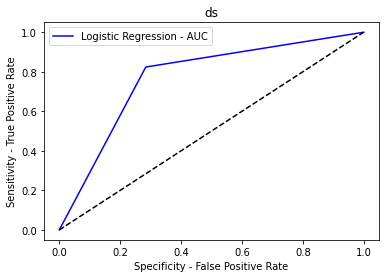

AUC: 0.769925161477829
Confusion Matrix : 
 [[12928  5132]
 [ 3267 15297]]
Accuracy :  0.7706695063346439
Sensitivity :  0.7158361018826135
Specificity :  0.8240142210730446


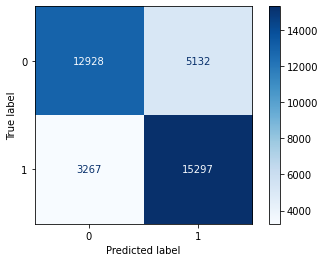

Regresion Logistica Validation


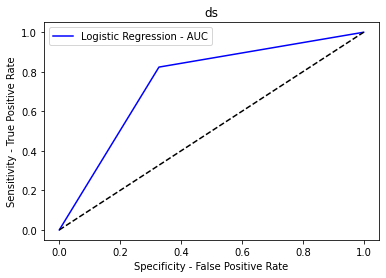

AUC: 0.7481253007746401
Confusion Matrix : 
 [[11710  5700]
 [ 3132 14628]]
Accuracy :  0.7488768837077054
Sensitivity :  0.6726019529006318
Specificity :  0.8236486486486486


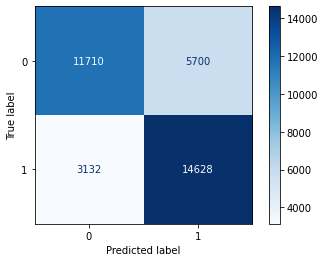

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.0400269e+00
   5.1074250e-01  5.0049055e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.0400269e+00
   5.1074250e-01  5.0049055e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.0400269e+00
   5.1074250e-01  5.0049055e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -1.6740899e+00
   1.3099920e+00  1.7542211e-02]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.6740899e+00
   1.3099920e+00  1.7542211e-02]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -1.6740899e+00
   1.3099920e+00  1.7542211e-02]]
(179136, 36)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 8446.347237
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

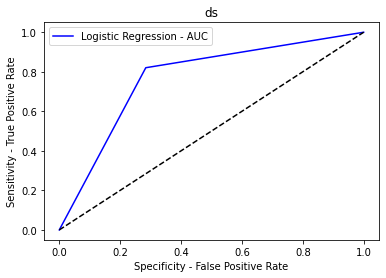

AUC: 0.7681744611977169
Confusion Matrix : 
 [[12928  5132]
 [ 3332 15232]]
Accuracy :  0.7688947138488423
Sensitivity :  0.7158361018826135
Specificity :  0.8205128205128205


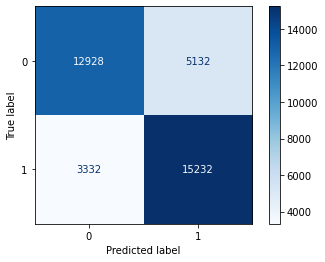

Regresion Logistica Validation


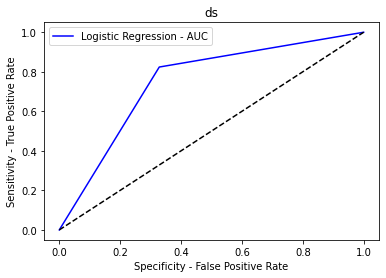

AUC: 0.7477485562817269
Confusion Matrix : 
 [[11691  5719]
 [ 3126 14634]]
Accuracy :  0.7485072504975832
Sensitivity :  0.6715106260769672
Specificity :  0.8239864864864865


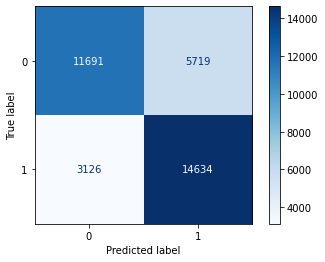

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  5.1074250e-01
   5.0049055e-01  7.1693563e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  5.1074250e-01
   5.0049055e-01  7.1693563e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  5.1074250e-01
   5.0049055e-01  7.1693563e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.3099920e+00
   1.7542211e-02  1.3489101e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.3099920e+00
   1.7542211e-02  1.3489101e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.3099920e+00
   1.7542211e-02  1.3489101e+00]]
(179136, 37)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 9519.219160
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

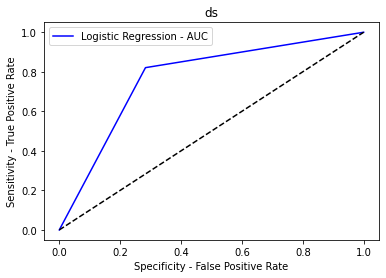

AUC: 0.7688613370213917
Confusion Matrix : 
 [[12946  5114]
 [ 3325 15239]]
Accuracy :  0.7695773263433814
Sensitivity :  0.7168327796234772
Specificity :  0.8208898944193062


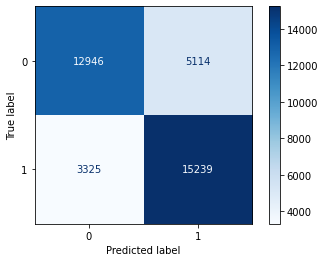

Regresion Logistica Validation


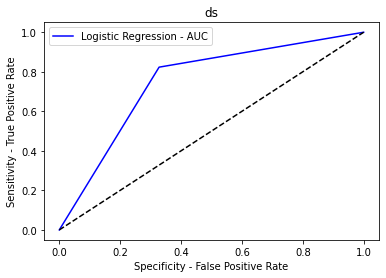

AUC: 0.7477260628664276
Confusion Matrix : 
 [[11701  5709]
 [ 3137 14623]]
Accuracy :  0.7484788171737277
Sensitivity :  0.672085008615738
Specificity :  0.8233671171171171


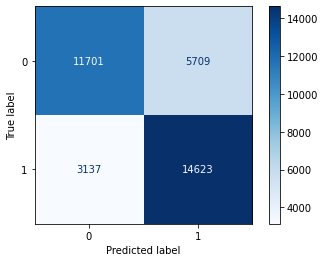

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  5.0049055e-01
   7.1693563e-01  1.0301754e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  5.0049055e-01
   7.1693563e-01  1.0301754e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  5.0049055e-01
   7.1693563e-01  1.0301754e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.7542211e-02
   1.3489101e+00 -1.6749413e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.7542211e-02
   1.3489101e+00 -1.6749413e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.7542211e-02
   1.3489101e+00 -1.6749413e+00]]
(179136, 38)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 8383.380175
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.71      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weigh

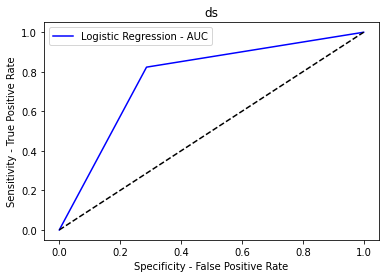

AUC: 0.7684107274394552
Confusion Matrix : 
 [[12884  5176]
 [ 3278 15286]]
Accuracy :  0.7691677588466579
Sensitivity :  0.7133997785160576
Specificity :  0.8234216763628528


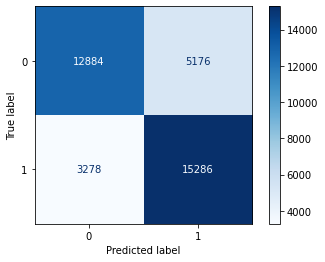

Regresion Logistica Validation


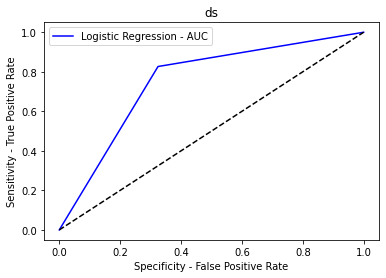

AUC: 0.7511108124925614
Confusion Matrix : 
 [[11762  5648]
 [ 3079 14681]]
Accuracy :  0.7518623827125391
Sensitivity :  0.6755887421022401
Specificity :  0.8266328828828828


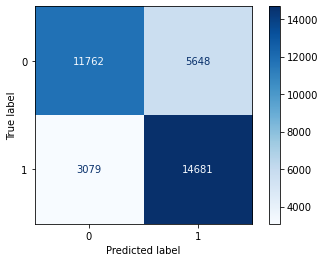

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  7.1693563e-01
   1.0301754e+00  6.0195830e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  7.1693563e-01
   1.0301754e+00  6.0195830e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  7.1693563e-01
   1.0301754e+00  6.0195830e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.3489101e+00
  -1.6749413e+00  1.1699809e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.3489101e+00
  -1.6749413e+00  1.1699809e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.3489101e+00
  -1.6749413e+00  1.1699809e-01]]
(179136, 39)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 9916.412354
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     18060
           1       0.76      0.83      0.79     18564

    accuracy                           0.78     36624
   macro avg       0.78      0.78      0.78     36624
weigh

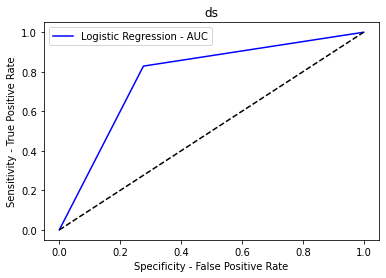

AUC: 0.776144375460381
Confusion Matrix : 
 [[13068  4992]
 [ 3180 15384]]
Accuracy :  0.776867627785059
Sensitivity :  0.7235880398671096
Specificity :  0.8287007110536523


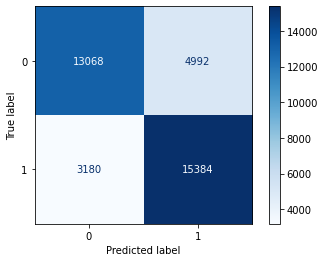

Regresion Logistica Validation


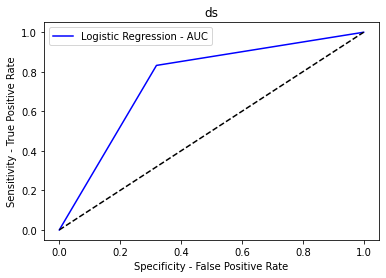

AUC: 0.7564826960791924
Confusion Matrix : 
 [[11852  5558]
 [ 2980 14780]]
Accuracy :  0.7572362809212397
Sensitivity :  0.6807581849511775
Specificity :  0.8322072072072072


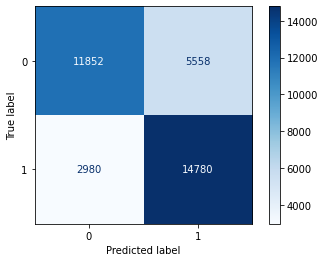

In [31]:
AUCFeaturesTest, AUCFeaturesVal = FeaturesFowardSelection(XE, ygE, XP, ygP, XV, ygV, 39)

In [32]:
print(AUCFeaturesTest)

[0.5883808621838718, 0.6081188647194118, 0.6304266071365935, 0.6361875698401007, 0.6591879506722187, 0.6687643751597241, 0.6897901915685773, 0.6875865015057901, 0.6868195757730642, 0.7000990915149603, 0.7064603658994904, 0.7188470558169601, 0.7635357005056047, 0.7633995279686115, 0.7636419326227808, 0.7639397082625536, 0.7639157809814443, 0.7634698065272619, 0.7635498564363132, 0.7636651082615514, 0.763664356619213, 0.7633097067091595, 0.7634413693921219, 0.7636621016921975, 0.7636920421120148, 0.7633082034244825, 0.7635348235895432, 0.7644618491403717, 0.7669982662116726, 0.7672152403000556, 0.769819054634376, 0.768582978808697, 0.7696237529000867, 0.7696887699623678, 0.769925161477829, 0.7681744611977169, 0.7688613370213917, 0.7684107274394552, 0.776144375460381]


In [33]:
print(AUCFeaturesVal)

[0.5841068092791241, 0.60920302482264, 0.613619819561089, 0.6099631599577751, 0.6406880494796923, 0.6557972533130488, 0.6825982465808715, 0.6925791942861875, 0.6931726743975452, 0.6942085357902418, 0.7021511208221433, 0.7138433306942784, 0.7412252232847437, 0.7414245592519574, 0.7413665550242948, 0.7412747379056254, 0.7413333081070732, 0.7414504485099689, 0.7415073207900607, 0.741737073805569, 0.741737073805569, 0.7415946101184472, 0.7416773716565503, 0.7414515804575397, 0.7410827595976217, 0.7415647590439377, 0.7441296713859178, 0.7449241853858454, 0.7439488670175058, 0.7435541568995763, 0.7463454264143523, 0.7480391433938246, 0.7486337554527531, 0.7477536500457954, 0.7481253007746401, 0.7477485562817269, 0.7477260628664276, 0.7511108124925614, 0.7564826960791924]


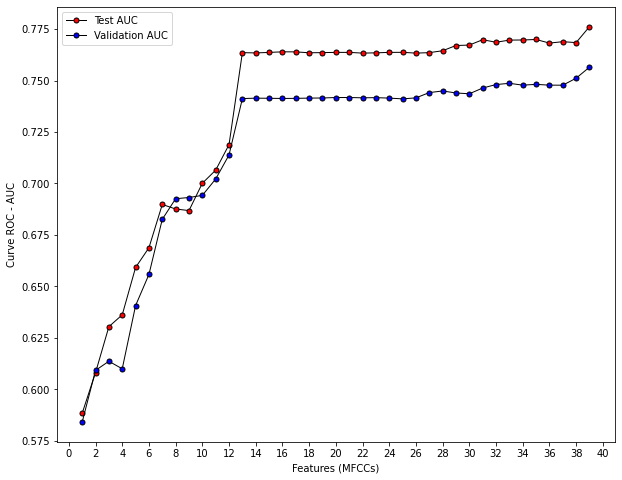

In [34]:
x = np.arange(1, len(AUCFeaturesTest)+1)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x, AUCFeaturesTest, lw=1, c='black', marker='.', ms=10, mfc='red', label='Test AUC')
plt.plot(x, AUCFeaturesVal, lw=1, c='black', marker='.', ms=10, mfc='blue', label='Validation AUC')
plt.xlabel('Features (MFCCs)')
plt.ylabel('Curve ROC - AUC')
plt.legend()
ax.set_xticks(range(0, 42, 2))
plt.show()

[[-461.9256 ]
 [-453.95935]
 [-441.73483]
 ...
 [-288.80374]
 [-312.29477]
 [-330.2163 ]]
(179136, 1)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 285.771370
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.60      0.52      0.55     18060
           1       0.58      0.66      0.62     18564

    accuracy                           0.59     36624
   macro avg       0.59      0.59      0.59     36624
weighted avg       0.59      0.59      0.59     36624

Test time: 0.000000
              precision    recall  f1-score   support

           0       0.59      0.53      0.56     17410
           1       0.58      0.64      0.61     17760

    accuracy                           0.58     35170
   macro avg       0.59      0.58      0.58     35170
weighted avg       0.59      0.58      0.58     35170

Validation time: 0.000000
Regresion Logistica Test


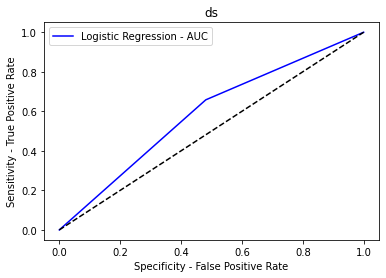

AUC: 0.5883808621838718
Confusion Matrix : 
 [[ 9367  8693]
 [ 6347 12217]]
Accuracy :  0.5893403232852774
Sensitivity :  0.5186600221483942
Specificity :  0.6581017022193493


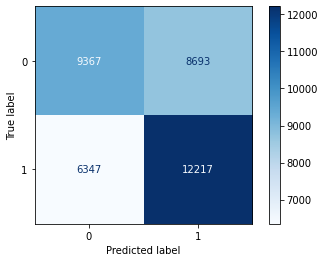

Regresion Logistica Validation


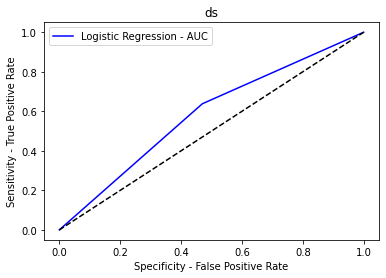

AUC: 0.5841068092791241
Confusion Matrix : 
 [[ 9226  8184]
 [ 6424 11336]]
Accuracy :  0.5846460051179982
Sensitivity :  0.5299253302699598
Specificity :  0.6382882882882883


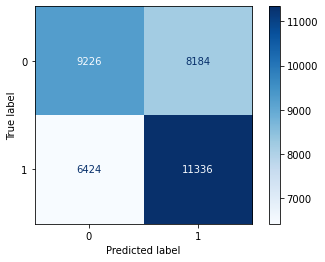

[[-461.9256     37.986633]
 [-453.95935    40.84214 ]
 [-441.73483    48.792828]
 ...
 [-288.80374   133.47595 ]
 [-312.29477   145.09683 ]
 [-330.2163    145.90912 ]]
(179136, 2)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 403.022766
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.62      0.53      0.57     18060
           1       0.60      0.69      0.64     18564

    accuracy                           0.61     36624
   macro avg       0.61      0.61      0.61     36624
weighted avg       0.61      0.61      0.61     36624

Test time: 1.001358
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.61      0.61      0.61     35170
weighted avg       0.61      0.61      0.61     35170

Validation time: 0.000000
Regresion L

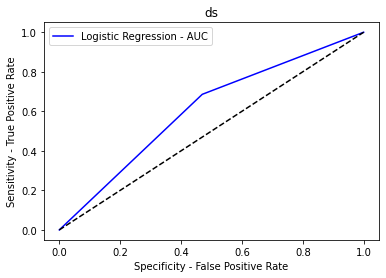

AUC: 0.6081188647194118
Confusion Matrix : 
 [[ 9576  8484]
 [ 5829 12735]]
Accuracy :  0.6091906946264745
Sensitivity :  0.5302325581395348
Specificity :  0.686005171299289


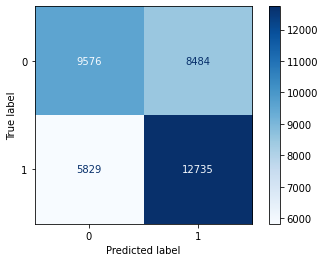

Regresion Logistica Validation


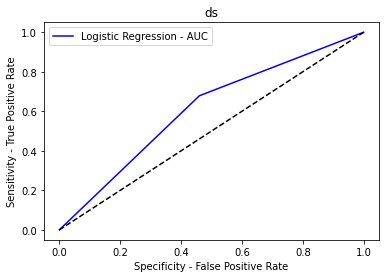

AUC: 0.60920302482264
Confusion Matrix : 
 [[ 9396  8014]
 [ 5706 12054]]
Accuracy :  0.6098947967017344
Sensitivity :  0.5396898334290637
Specificity :  0.6787162162162163


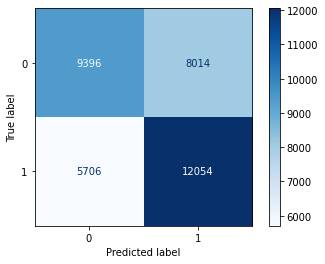

[[-461.9256     37.986633   14.340712]
 [-453.95935    40.84214    13.285265]
 [-441.73483    48.792828   16.774529]
 ...
 [-288.80374   133.47595    64.27397 ]
 [-312.29477   145.09683    46.839935]
 [-330.2163    145.90912    39.09671 ]]
(179136, 3)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 379.000187
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.55      0.60     18060
           1       0.62      0.71      0.66     18564

    accuracy                           0.63     36624
   macro avg       0.63      0.63      0.63     36624
weighted avg       0.63      0.63      0.63     36624

Test time: 0.999689
              precision    recall  f1-score   support

           0       0.63      0.54      0.58     17410
           1       0.60      0.69      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.62      0.61      0.61     35170
weighted avg       0

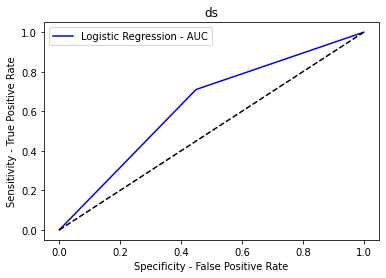

AUC: 0.6304266071365935
Confusion Matrix : 
 [[ 9943  8117]
 [ 5378 13186]]
Accuracy :  0.6315257754477938
Sensitivity :  0.5505537098560355
Specificity :  0.7102995044171515


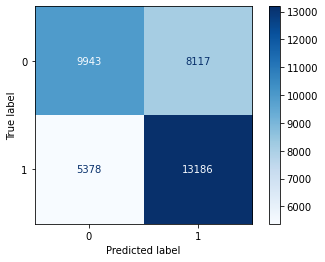

Regresion Logistica Validation


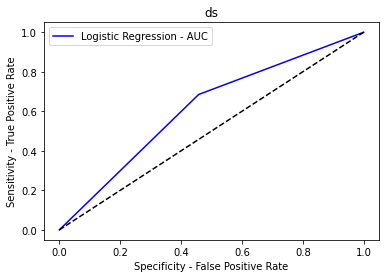

AUC: 0.613619819561089
Confusion Matrix : 
 [[ 9440  7970]
 [ 5594 12166]]
Accuracy :  0.6143303952232015
Sensitivity :  0.5422171165996553
Specificity :  0.6850225225225225


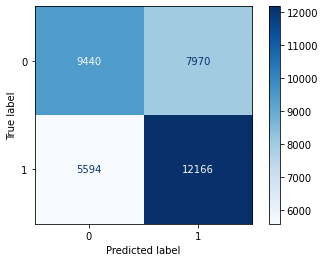

[[-461.9256       37.986633     14.340712      4.210198  ]
 [-453.95935      40.84214      13.285265      4.3595467 ]
 [-441.73483      48.792828     16.774529      6.6460085 ]
 ...
 [-288.80374     133.47595      64.27397      -0.57170194]
 [-312.29477     145.09683      46.839935      8.134534  ]
 [-330.2163      145.90912      39.09671       8.820234  ]]
(179136, 4)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 444.672823
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.56      0.61     18060
           1       0.63      0.71      0.66     18564

    accuracy                           0.64     36624
   macro avg       0.64      0.64      0.63     36624
weighted avg       0.64      0.64      0.64     36624

Test time: 1.000404
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    accu

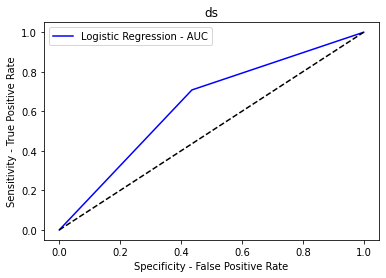

AUC: 0.6361875698401007
Confusion Matrix : 
 [[10190  7870]
 [ 5418 13146]]
Accuracy :  0.6371778069025775
Sensitivity :  0.5642303433001108
Specificity :  0.7081447963800905


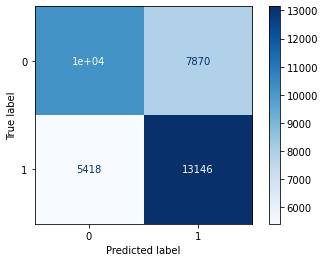

Regresion Logistica Validation


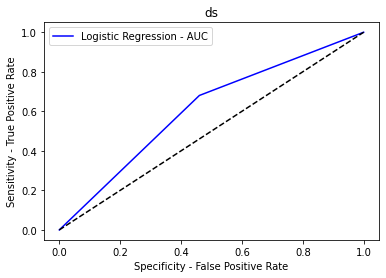

AUC: 0.6099631599577751
Confusion Matrix : 
 [[ 9396  8014]
 [ 5679 12081]]
Accuracy :  0.6106624964458345
Sensitivity :  0.5396898334290637
Specificity :  0.6802364864864865


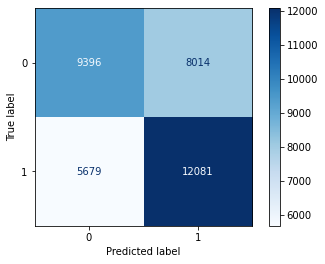

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01]]
(179136, 5)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 510.703564
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.68      0.59      0.63     18060
           1       0.65      0.72      0.68     18564

    accuracy                           0.66     36624
   macro avg       0.66      0.66      0.66     36624
weighted avg       0.66      0.66      0.66     36624

Test time: 0.996590
              precision    recall  f1-score   

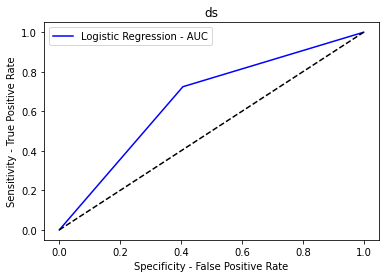

AUC: 0.6591879506722187
Confusion Matrix : 
 [[10726  7334]
 [ 5115 13449]]
Accuracy :  0.6600862822193098
Sensitivity :  0.5939091915836102
Specificity :  0.7244667097608274


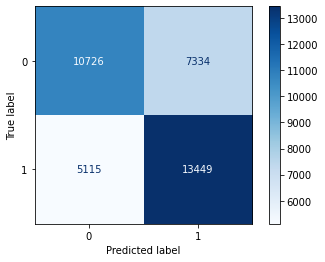

Regresion Logistica Validation


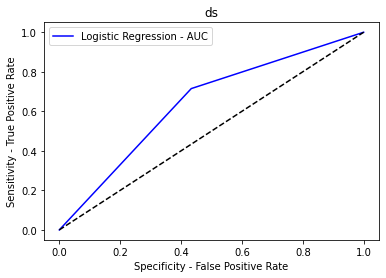

AUC: 0.6406880494796923
Confusion Matrix : 
 [[ 9861  7549]
 [ 5062 12698]]
Accuracy :  0.641427352857549
Sensitivity :  0.566398621481907
Specificity :  0.7149774774774775


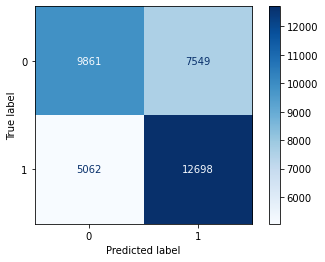

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02 -2.3872137e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01 -2.2336156e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01 -3.4468700e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00 -7.9153534e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01 -7.1443180e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01 -6.6536865e+01]]
(179136, 6)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 572.993994
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.69      0.60      0.64     18060
           1       0.66      0.73      0.69     18564

    accuracy                           0.67     36624
   macro avg       0.67      0.67      0.67     36624
weighted avg       0.67      0.

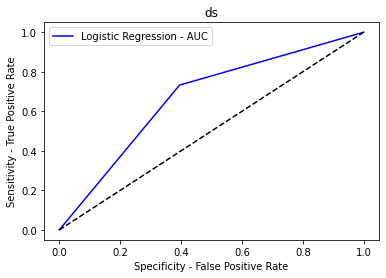

AUC: 0.6687643751597241
Confusion Matrix : 
 [[10925  7135]
 [ 4964 13600]]
Accuracy :  0.6696428571428571
Sensitivity :  0.6049280177187154
Specificity :  0.7326007326007326


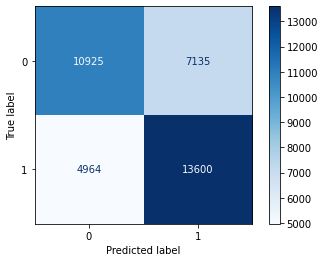

Regresion Logistica Validation


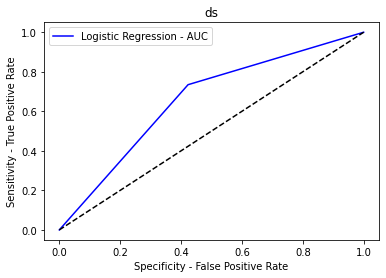

AUC: 0.6557972533130488
Confusion Matrix : 
 [[10044  7366]
 [ 4712 13048]]
Accuracy :  0.6565823144725619
Sensitivity :  0.5769098219414129
Specificity :  0.7346846846846847


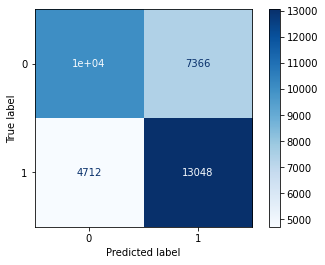

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -5.4178063e-02
  -2.3872137e+00 -6.9183330e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -4.4440317e-01
  -2.2336156e+00 -7.3383017e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.7909959e-01
  -3.4468700e+00 -1.0184973e+01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -7.8325977e+00
  -7.9153534e+01 -3.4108032e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.5897917e+01
  -7.1443180e+01 -3.5344510e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -1.7901260e+01
  -6.6536865e+01 -3.4597000e+01]]
(179136, 7)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 948.201180
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     18060
           1       0.68      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighte

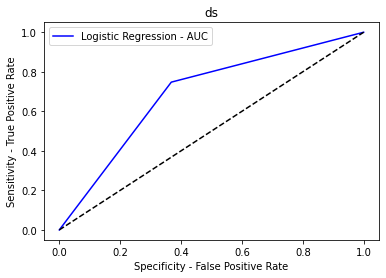

AUC: 0.6897901915685773
Confusion Matrix : 
 [[11414  6646]
 [ 4686 13878]]
Accuracy :  0.6905854084753167
Sensitivity :  0.6320044296788483
Specificity :  0.7475759534583064


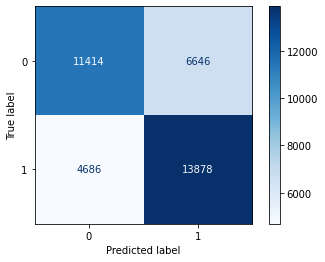

Regresion Logistica Validation


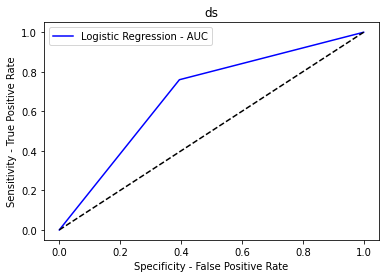

AUC: 0.6825982465808715
Confusion Matrix : 
 [[10540  6870]
 [ 4266 13494]]
Accuracy :  0.6833665055444982
Sensitivity :  0.6053991958644457
Specificity :  0.7597972972972973


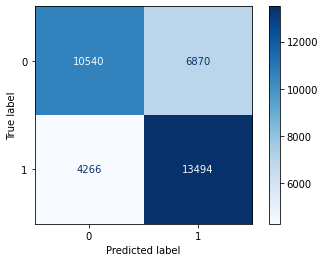

[[-461.9256      37.986633    14.340712  ...   -2.3872137   -6.918333
    -9.676699 ]
 [-453.95935     40.84214     13.285265  ...   -2.2336156   -7.3383017
   -10.662281 ]
 [-441.73483     48.792828    16.774529  ...   -3.44687    -10.184973
   -14.396601 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -79.153534   -34.108032
    13.913701 ]
 [-312.29477    145.09683     46.839935  ...  -71.44318    -35.34451
    10.800596 ]
 [-330.2163     145.90912     39.09671   ...  -66.536865   -34.597
     6.568719 ]]
(179136, 8)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 876.775503
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 1.000166
             

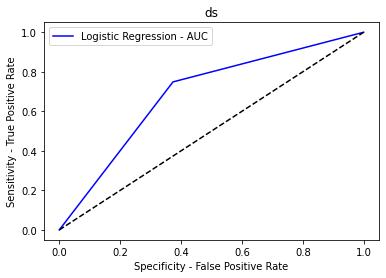

AUC: 0.6875865015057901
Confusion Matrix : 
 [[11313  6747]
 [ 4664 13900]]
Accuracy :  0.6884283529925732
Sensitivity :  0.6264119601328904
Specificity :  0.7487610428786899


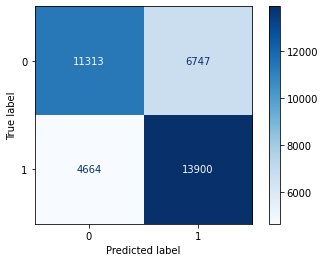

Regresion Logistica Validation


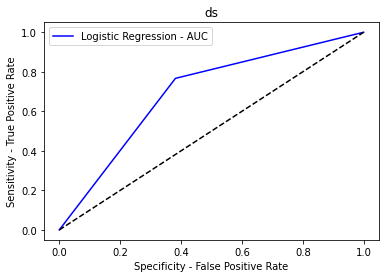

AUC: 0.6925791942861875
Confusion Matrix : 
 [[10765  6645]
 [ 4141 13619]]
Accuracy :  0.6933181688939437
Sensitivity :  0.6183228029867892
Specificity :  0.7668355855855856


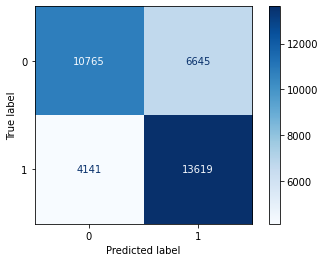

[[-461.9256      37.986633    14.340712  ...   -6.918333    -9.676699
    -7.8132167]
 [-453.95935     40.84214     13.285265  ...   -7.3383017  -10.662281
    -7.4927154]
 [-441.73483     48.792828    16.774529  ...  -10.184973   -14.396601
   -10.996808 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -34.108032    13.913701
   -29.214916 ]
 [-312.29477    145.09683     46.839935  ...  -35.34451     10.800596
   -21.054426 ]
 [-330.2163     145.90912     39.09671   ...  -34.597        6.568719
   -12.276783 ]]
(179136, 9)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1070.492744
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 0.999689
         

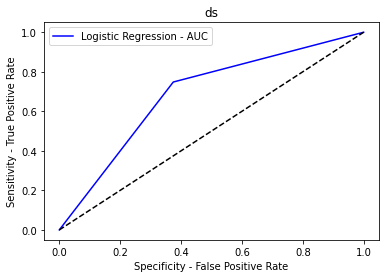

AUC: 0.6868195757730642
Confusion Matrix : 
 [[11296  6764]
 [ 4675 13889]]
Accuracy :  0.6876638269986893
Sensitivity :  0.6254706533776301
Specificity :  0.7481684981684982


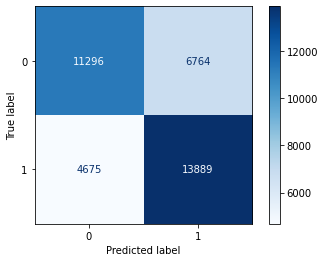

Regresion Logistica Validation


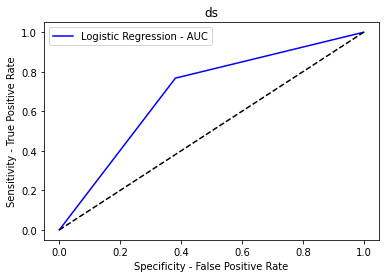

AUC: 0.6931726743975452
Confusion Matrix : 
 [[10769  6641]
 [ 4124 13636]]
Accuracy :  0.6939152686949104
Sensitivity :  0.6185525560022975
Specificity :  0.7677927927927928


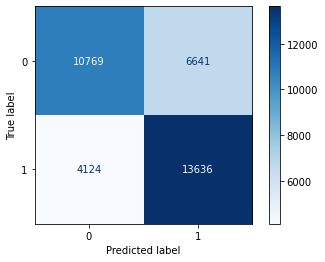

[[-461.9256      37.986633    14.340712  ...   -9.676699    -7.8132167
    -9.168781 ]
 [-453.95935     40.84214     13.285265  ...  -10.662281    -7.4927154
    -9.833818 ]
 [-441.73483     48.792828    16.774529  ...  -14.396601   -10.996808
   -13.579085 ]
 ...
 [-288.80374    133.47595     64.27397   ...   13.913701   -29.214916
   -29.069393 ]
 [-312.29477    145.09683     46.839935  ...   10.800596   -21.054426
   -36.612003 ]
 [-330.2163     145.90912     39.09671   ...    6.568719   -12.276783
   -43.515823 ]]
(179136, 10)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1456.602335
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.63      0.68     18060
           1       0.68      0.77      0.72     18564

    accuracy                           0.70     36624
   macro avg       0.70      0.70      0.70     36624
weighted avg       0.70      0.70      0.70     36624

Test time: 0.000000
      

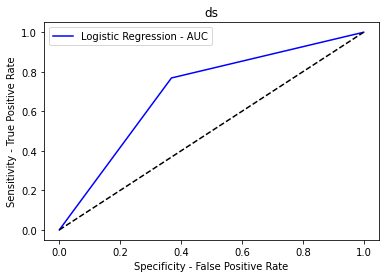

AUC: 0.7000990915149603
Confusion Matrix : 
 [[11405  6655]
 [ 4294 14270]]
Accuracy :  0.7010430318916557
Sensitivity :  0.6315060908084164
Specificity :  0.768692092221504


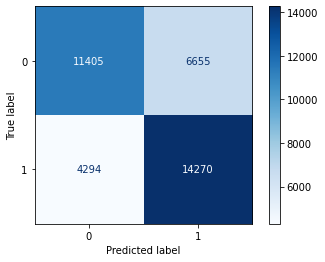

Regresion Logistica Validation


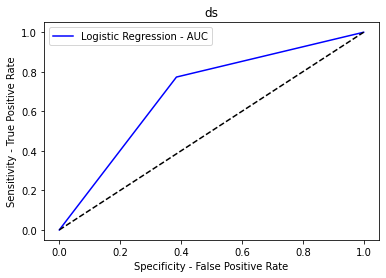

AUC: 0.6942085357902418
Confusion Matrix : 
 [[10709  6701]
 [ 4026 13734]]
Accuracy :  0.6949957350014216
Sensitivity :  0.6151062607696726
Specificity :  0.7733108108108108


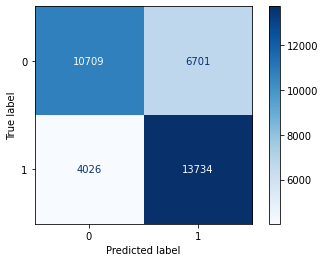

[[-461.9256      37.986633    14.340712  ...   -7.8132167   -9.168781
   -10.380377 ]
 [-453.95935     40.84214     13.285265  ...   -7.4927154   -9.833818
   -11.587559 ]
 [-441.73483     48.792828    16.774529  ...  -10.996808   -13.579085
   -16.023682 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.214916   -29.069393
   -48.466904 ]
 [-312.29477    145.09683     46.839935  ...  -21.054426   -36.612003
   -41.964684 ]
 [-330.2163     145.90912     39.09671   ...  -12.276783   -43.515823
   -35.94929  ]]
(179136, 11)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1472.495317
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.64      0.68     18060
           1       0.69      0.78      0.73     18564

    accuracy                           0.71     36624
   macro avg       0.71      0.71      0.71     36624
weighted avg       0.71      0.71      0.71     36624

Test time: 1.001358
        

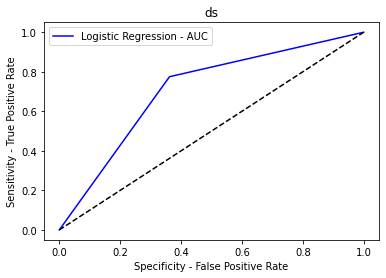

AUC: 0.7064603658994904
Confusion Matrix : 
 [[11519  6541]
 [ 4175 14389]]
Accuracy :  0.7074049803407602
Sensitivity :  0.6378183831672204
Specificity :  0.7751023486317604


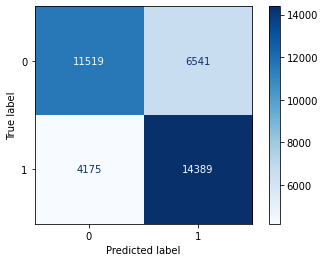

Regresion Logistica Validation


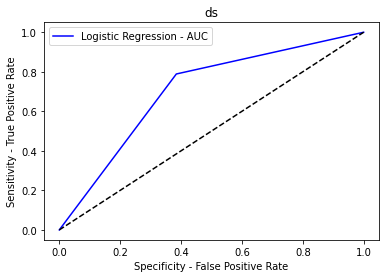

AUC: 0.7021511208221433
Confusion Matrix : 
 [[10715  6695]
 [ 3750 14010]]
Accuracy :  0.7030139323286893
Sensitivity :  0.6154508902929351
Specificity :  0.7888513513513513


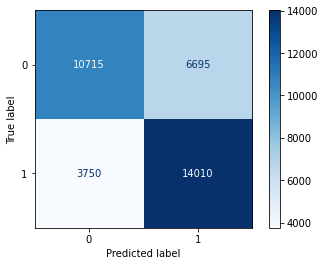

[[-461.9256      37.986633    14.340712  ...   -9.168781   -10.380377
    -8.284298 ]
 [-453.95935     40.84214     13.285265  ...   -9.833818   -11.587559
    -8.15322  ]
 [-441.73483     48.792828    16.774529  ...  -13.579085   -16.023682
   -11.017866 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.069393   -48.466904
     5.8222713]
 [-312.29477    145.09683     46.839935  ...  -36.612003   -41.964684
     0.5614144]
 [-330.2163     145.90912     39.09671   ...  -43.515823   -35.94929
    -4.6305156]]
(179136, 12)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1700.107098
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     18060
           1       0.69      0.80      0.74     18564

    accuracy                           0.72     36624
   macro avg       0.72      0.72      0.72     36624
weighted avg       0.72      0.72      0.72     36624

Test time: 1.000166
         

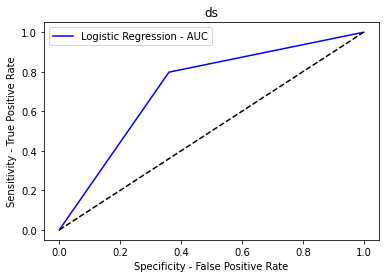

AUC: 0.7188470558169601
Confusion Matrix : 
 [[11551  6509]
 [ 3748 14816]]
Accuracy :  0.7199377457404981
Sensitivity :  0.6395902547065337
Specificity :  0.7981038569273864


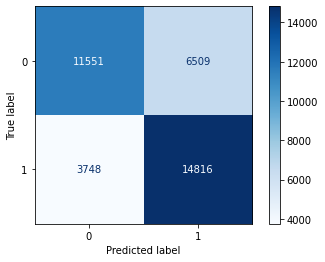

Regresion Logistica Validation


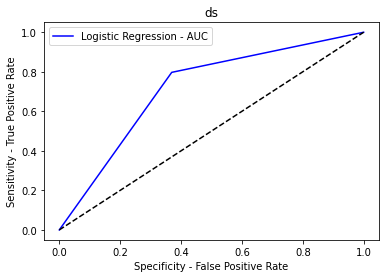

AUC: 0.7138433306942784
Confusion Matrix : 
 [[10979  6431]
 [ 3604 14156]]
Accuracy :  0.7146715951094683
Sensitivity :  0.6306145893164847
Specificity :  0.7970720720720721


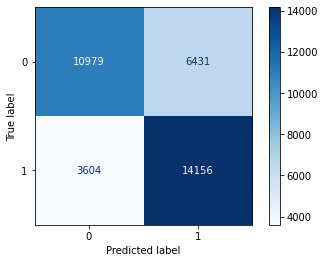

[[-461.9256       37.986633     14.340712   ...  -10.380377
    -8.284298     -7.0208225 ]
 [-453.95935      40.84214      13.285265   ...  -11.587559
    -8.15322      -7.858124  ]
 [-441.73483      48.792828     16.774529   ...  -16.023682
   -11.017866    -10.613985  ]
 ...
 [-288.80374     133.47595      64.27397    ...  -48.466904
     5.8222713    -4.2369475 ]
 [-312.29477     145.09683      46.839935   ...  -41.964684
     0.5614144    -0.96565664]
 [-330.2163      145.90912      39.09671    ...  -35.94929
    -4.6305156     1.540931  ]]
(179136, 13)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2113.961458
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624


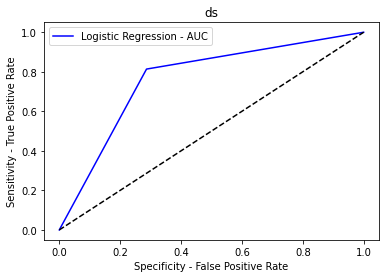

AUC: 0.7635357005056047
Confusion Matrix : 
 [[12884  5176]
 [ 3459 15105]]
Accuracy :  0.7642256443861949
Sensitivity :  0.7133997785160576
Specificity :  0.8136716224951519


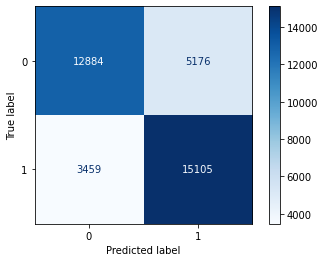

Regresion Logistica Validation


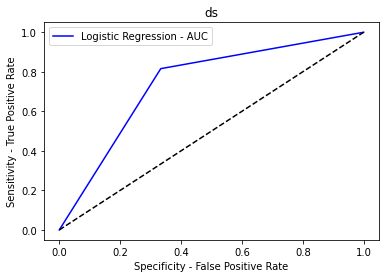

AUC: 0.7412252232847437
Confusion Matrix : 
 [[11606  5804]
 [ 3271 14489]]
Accuracy :  0.7419675860108047
Sensitivity :  0.6666283744974153
Specificity :  0.815822072072072


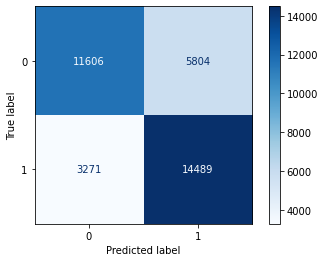

[[-461.9256       37.986633     14.340712   ...   -8.284298
    -7.0208225    -6.7342052 ]
 [-453.95935      40.84214      13.285265   ...   -8.15322
    -7.858124     -7.005454  ]
 [-441.73483      48.792828     16.774529   ...  -11.017866
   -10.613985     -8.312536  ]
 ...
 [-288.80374     133.47595      64.27397    ...    5.8222713
    -4.2369475    -9.252791  ]
 [-312.29477     145.09683      46.839935   ...    0.5614144
    -0.96565664  -12.189263  ]
 [-330.2163      145.90912      39.09671    ...   -4.6305156
     1.540931    -15.82521   ]]
(179136, 14)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2171.833754
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.71      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weighted avg       0.77      0.77      0.77     366

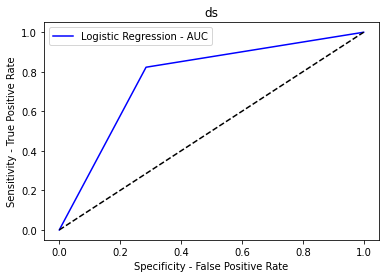

AUC: 0.7689973842846619
Confusion Matrix : 
 [[12912  5148]
 [ 3285 15279]]
Accuracy :  0.7697411533420708
Sensitivity :  0.7149501661129568
Specificity :  0.8230446024563671


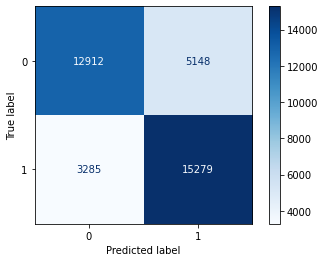

Regresion Logistica Validation


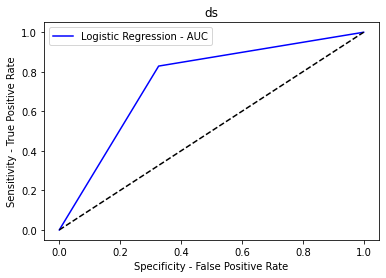

AUC: 0.7512036160226855
Confusion Matrix : 
 [[11727  5683]
 [ 3040 14720]]
Accuracy :  0.7519761160079613
Sensitivity :  0.6735784032165422
Specificity :  0.8288288288288288


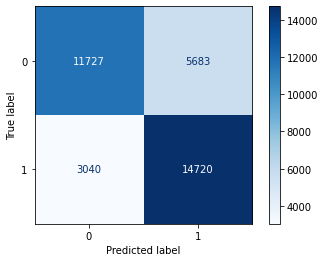

[[-461.9256       37.986633     14.340712   ...   -7.0208225
    -6.7342052    -5.565437  ]
 [-453.95935      40.84214      13.285265   ...   -7.858124
    -7.005454     -6.229723  ]
 [-441.73483      48.792828     16.774529   ...  -10.613985
    -8.312536     -6.4472723 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -4.2369475
    -9.252791    -27.431974  ]
 [-312.29477     145.09683      46.839935   ...   -0.96565664
   -12.189263    -25.55872   ]
 [-330.2163      145.90912      39.09671    ...    1.540931
   -15.82521     -22.679249  ]]
(179136, 15)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2531.544447
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     18060
           1       0.75      0.83      0.79     18564

    accuracy                           0.78     36624
   macro avg       0.78      0.77      0.77     36624
weighted avg       0.78      0.78      0.77     3

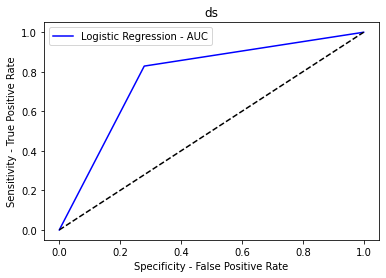

AUC: 0.7748147201635575
Confusion Matrix : 
 [[13019  5041]
 [ 3179 15385]]
Accuracy :  0.7755570117955439
Sensitivity :  0.720874861572536
Specificity :  0.8287545787545788


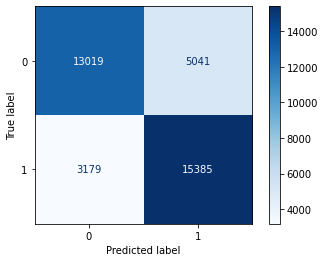

Regresion Logistica Validation


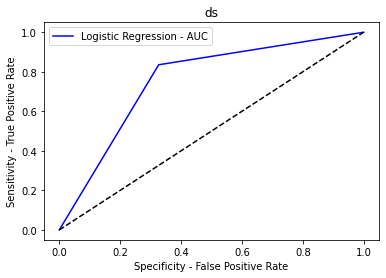

AUC: 0.7544389647401566
Confusion Matrix : 
 [[11723  5687]
 [ 2921 14839]]
Accuracy :  0.7552459482513506
Sensitivity :  0.6733486502010338
Specificity :  0.8355292792792792


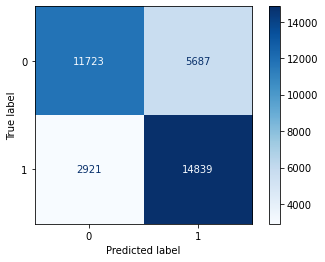

[[-461.9256      37.986633    14.340712  ...   -6.7342052   -5.565437
    -5.127263 ]
 [-453.95935     40.84214     13.285265  ...   -7.005454    -6.229723
    -4.7056503]
 [-441.73483     48.792828    16.774529  ...   -8.312536    -6.4472723
    -2.766725 ]
 ...
 [-288.80374    133.47595     64.27397   ...   -9.252791   -27.431974
     3.366393 ]
 [-312.29477    145.09683     46.839935  ...  -12.189263   -25.55872
     3.8001223]
 [-330.2163     145.90912     39.09671   ...  -15.82521    -22.679249
     3.110639 ]]
(179136, 16)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2065.107107
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     18060
           1       0.80      0.84      0.82     18564

    accuracy                           0.81     36624
   macro avg       0.81      0.81      0.81     36624
weighted avg       0.81      0.81      0.81     36624

Test time: 1.004219
        

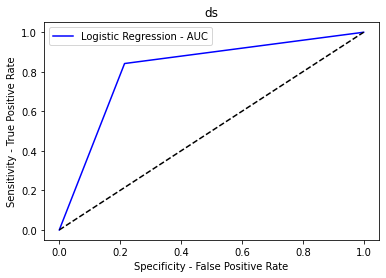

AUC: 0.8136424337176733
Confusion Matrix : 
 [[14187  3873]
 [ 2938 15626]]
Accuracy :  0.8140290519877675
Sensitivity :  0.7855481727574751
Specificity :  0.8417366946778712


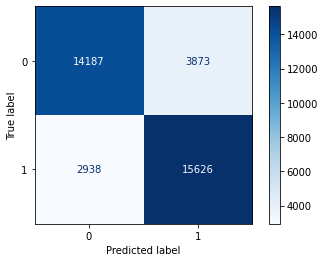

Regresion Logistica Validation


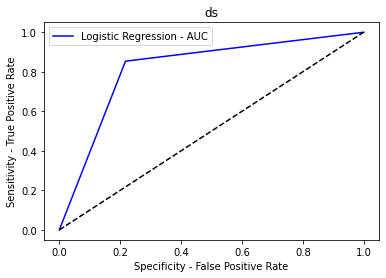

AUC: 0.8181269275450063
Confusion Matrix : 
 [[13623  3787]
 [ 2597 15163]]
Accuracy :  0.8184816605061132
Sensitivity :  0.78248133256749
Specificity :  0.8537725225225226


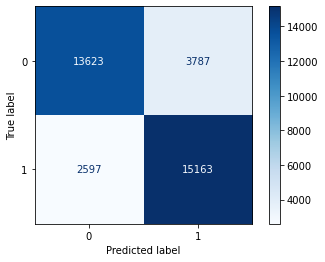

[[-461.9256      37.986633    14.340712  ...   -5.565437    -5.127263
    -8.357363 ]
 [-453.95935     40.84214     13.285265  ...   -6.229723    -4.7056503
    -8.663831 ]
 [-441.73483     48.792828    16.774529  ...   -6.4472723   -2.766725
    -6.69202  ]
 ...
 [-288.80374    133.47595     64.27397   ...  -27.431974     3.366393
    -1.1756334]
 [-312.29477    145.09683     46.839935  ...  -25.55872      3.8001223
    -4.477385 ]
 [-330.2163     145.90912     39.09671   ...  -22.679249     3.110639
    -7.3972797]]
(179136, 17)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2400.307894
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     18060
           1       0.82      0.86      0.84     18564

    accuracy                           0.84     36624
   macro avg       0.84      0.84      0.84     36624
weighted avg       0.84      0.84      0.84     36624

Test time: 1.003981
      

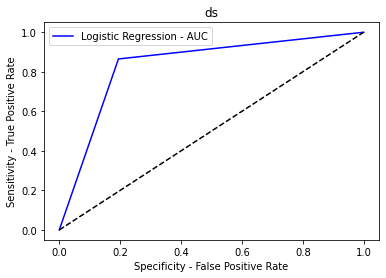

AUC: 0.8352738233039191
Confusion Matrix : 
 [[14550  3510]
 [ 2508 16056]]
Accuracy :  0.8356815203145478
Sensitivity :  0.8056478405315615
Specificity :  0.8648998060762767


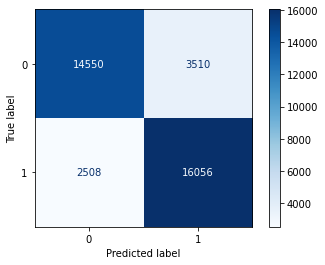

Regresion Logistica Validation


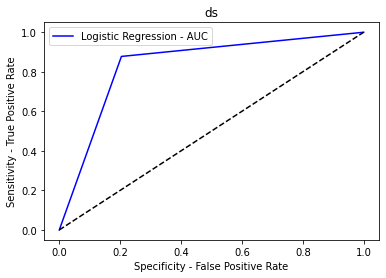

AUC: 0.8367554210586233
Confusion Matrix : 
 [[13856  3554]
 [ 2173 15587]]
Accuracy :  0.8371623542792153
Sensitivity :  0.7958644457208501
Specificity :  0.8776463963963964


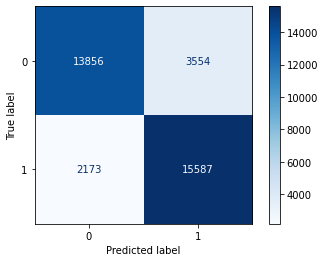

[[-461.9256      37.986633    14.340712  ...   -5.127263    -8.357363
    -7.4233713]
 [-453.95935     40.84214     13.285265  ...   -4.7056503   -8.663831
    -7.73197  ]
 [-441.73483     48.792828    16.774529  ...   -2.766725    -6.69202
    -5.436615 ]
 ...
 [-288.80374    133.47595     64.27397   ...    3.366393    -1.1756334
   -27.505428 ]
 [-312.29477    145.09683     46.839935  ...    3.8001223   -4.477385
   -24.265846 ]
 [-330.2163     145.90912     39.09671   ...    3.110639    -7.3972797
   -21.13058  ]]
(179136, 18)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2500.908136
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.84     18060
           1       0.82      0.88      0.85     18564

    accuracy                           0.84     36624
   macro avg       0.85      0.84      0.84     36624
weighted avg       0.85      0.84      0.84     36624

Test time: 1.996279
       

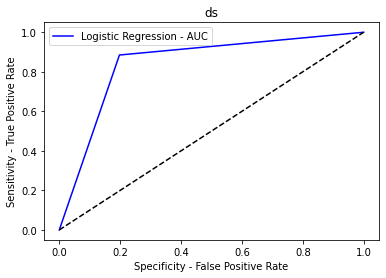

AUC: 0.8435789700495583
Confusion Matrix : 
 [[14491  3569]
 [ 2139 16425]]
Accuracy :  0.8441459152468327
Sensitivity :  0.8023809523809524
Specificity :  0.8847769877181642


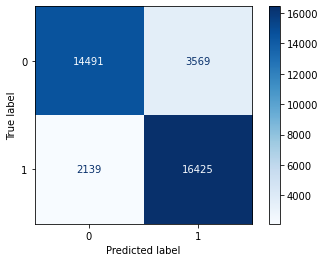

Regresion Logistica Validation


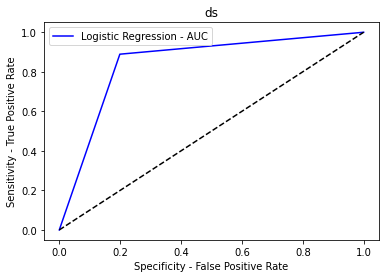

AUC: 0.8449989262668757
Confusion Matrix : 
 [[13946  3464]
 [ 1972 15788]]
Accuracy :  0.8454364515211829
Sensitivity :  0.8010338885697875
Specificity :  0.8889639639639639


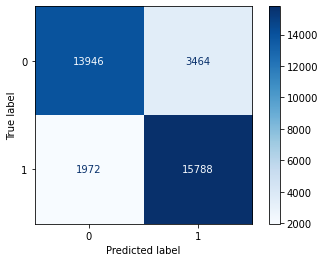

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -8.3573630e+00
  -7.4233713e+00 -4.1396527e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -8.6638310e+00
  -7.7319700e+00 -4.2945595e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -6.6920200e+00
  -5.4366150e+00 -1.8182391e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -1.1756334e+00
  -2.7505428e+01  3.5549695e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -4.4773850e+00
  -2.4265846e+01 -1.5246852e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -7.3972797e+00
  -2.1130580e+01 -4.1805015e+00]]
(179136, 19)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2864.357233
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     18060
           1       0.83      0.90      0.86     18564

    accuracy                           0.86     36624
   macro avg       0.86      0.86      0.86     36624
weigh

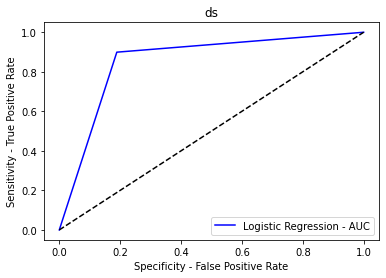

AUC: 0.8550892450003257
Confusion Matrix : 
 [[14647  3413]
 [ 1872 16692]]
Accuracy :  0.8556957186544343
Sensitivity :  0.8110188261351052
Specificity :  0.8991596638655462


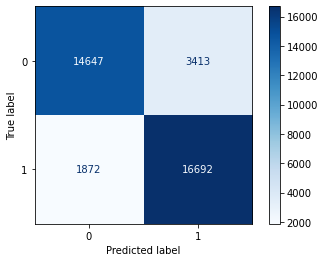

Regresion Logistica Validation


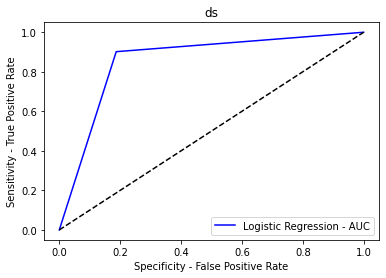

AUC: 0.8573351172827048
Confusion Matrix : 
 [[14154  3256]
 [ 1746 16014]]
Accuracy :  0.8577765140744953
Sensitivity :  0.8129810453762205
Specificity :  0.9016891891891892


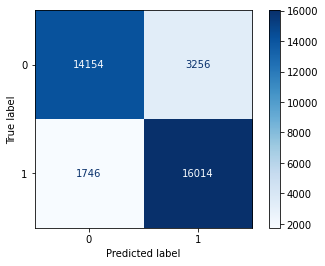

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -7.4233713e+00
  -4.1396527e+00 -2.0040889e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -7.7319700e+00
  -4.2945595e+00 -2.4416618e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -5.4366150e+00
  -1.8182391e+00 -6.4428610e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -2.7505428e+01
   3.5549695e+00  1.6328693e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -2.4265846e+01
  -1.5246852e-01  1.8788227e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -2.1130580e+01
  -4.1805015e+00  2.1952953e+01]]
(179136, 20)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2401.351690
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     18060
           1       0.84      0.90      0.87     18564

    accuracy                           0.86     36624
   macro avg       0.86      0.86      0.86     36624
weigh

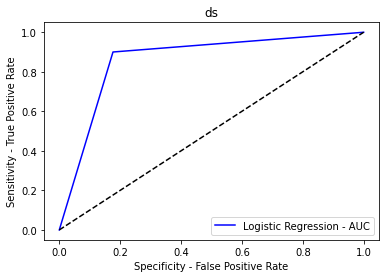

AUC: 0.8618317273242033
Confusion Matrix : 
 [[14874  3186]
 [ 1855 16709]]
Accuracy :  0.8623580166011359
Sensitivity :  0.8235880398671096
Specificity :  0.9000754147812972


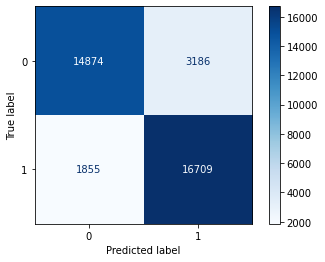

Regresion Logistica Validation


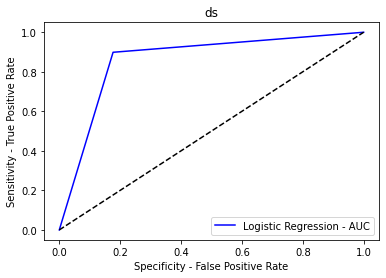

AUC: 0.860984289861372
Confusion Matrix : 
 [[14334  3076]
 [ 1800 15960]]
Accuracy :  0.8613591128802957
Sensitivity :  0.8233199310740954
Specificity :  0.8986486486486487


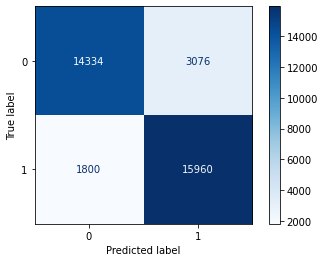

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -4.1396527e+00
  -2.0040889e+00  1.7380178e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -4.2945595e+00
  -2.4416618e+00 -2.6909775e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.8182391e+00
  -6.4428610e-01  1.9716474e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  3.5549695e+00
   1.6328693e+01  1.9612759e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.5246852e-01
   1.8788227e+01  2.6740540e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -4.1805015e+00
   2.1952953e+01 -3.3403144e+00]]
(179136, 21)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2672.673941
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.83      0.86     18060
           1       0.84      0.90      0.87     18564

    accuracy                           0.86     36624
   macro avg       0.87      0.86      0.86     36624
weigh

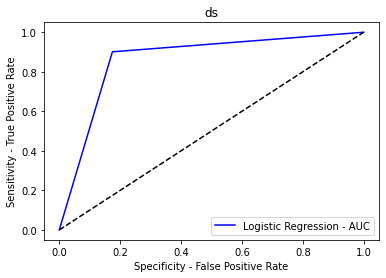

AUC: 0.8632578433878023
Confusion Matrix : 
 [[14908  3152]
 [ 1837 16727]]
Accuracy :  0.8637778505897772
Sensitivity :  0.8254706533776301
Specificity :  0.9010450333979746


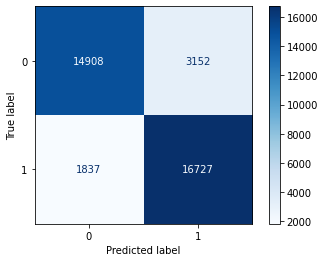

Regresion Logistica Validation


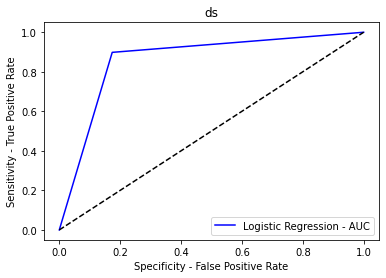

AUC: 0.8621657358823499
Confusion Matrix : 
 [[14382  3028]
 [ 1807 15953]]
Accuracy :  0.8625248791583736
Sensitivity :  0.8260769672601953
Specificity :  0.8982545045045045


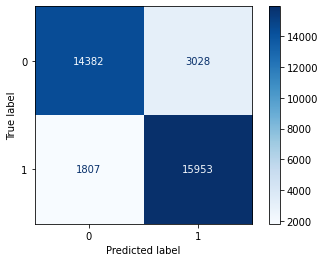

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -2.0040889e+00
   1.7380178e-01  4.8378250e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -2.4416618e+00
  -2.6909775e-01  2.5320196e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -6.4428610e-01
   1.9716474e-01  1.7928034e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.6328693e+01
   1.9612759e+00 -4.0417194e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.8788227e+01
   2.6740540e-01 -4.2235280e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  2.1952953e+01
  -3.3403144e+00 -2.8243313e+00]]
(179136, 22)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2809.570312
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     18060
           1       0.85      0.91      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

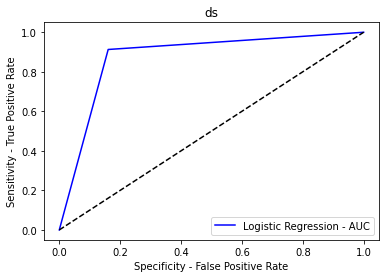

AUC: 0.8760784814820383
Confusion Matrix : 
 [[15159  2901]
 [ 1619 16945]]
Accuracy :  0.8765836609873308
Sensitivity :  0.8393687707641196
Specificity :  0.9127881921999569


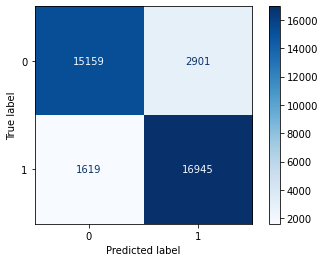

Regresion Logistica Validation


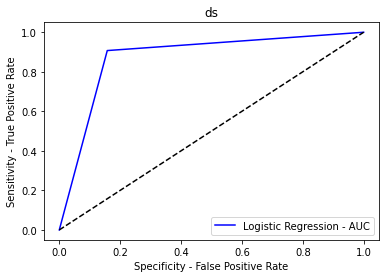

AUC: 0.8748546255905533
Confusion Matrix : 
 [[14666  2744]
 [ 1646 16114]]
Accuracy :  0.8751777082740972
Sensitivity :  0.8423894313612866
Specificity :  0.9073198198198198


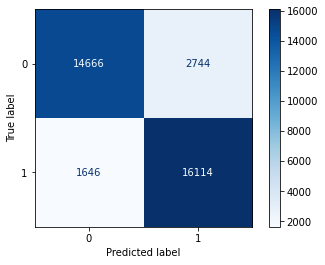

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.7380178e-01
   4.8378250e-01  7.1563240e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -2.6909775e-01
   2.5320196e-01  4.7839270e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.9716474e-01
   1.7928034e-01 -1.2109529e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.9612759e+00
  -4.0417194e+00  1.5861686e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  2.6740540e-01
  -4.2235280e+00  1.6993567e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -3.3403144e+00
  -2.8243313e+00  1.5352282e+01]]
(179136, 23)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 3245.536327
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     18060
           1       0.85      0.91      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

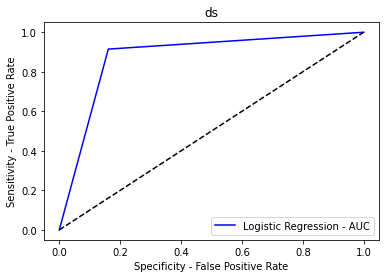

AUC: 0.8768543016491032
Confusion Matrix : 
 [[15152  2908]
 [ 1583 16981]]
Accuracy :  0.877375491480996
Sensitivity :  0.8389811738648948
Specificity :  0.9147274294333118


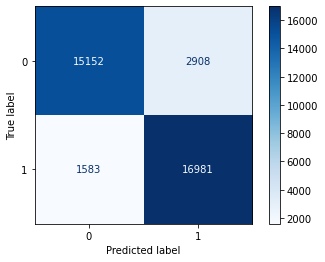

Regresion Logistica Validation


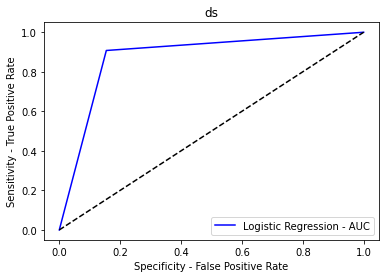

AUC: 0.8766025305173065
Confusion Matrix : 
 [[14720  2690]
 [ 1639 16121]]
Accuracy :  0.8769121410292863
Sensitivity :  0.8454910970706491
Specificity :  0.907713963963964


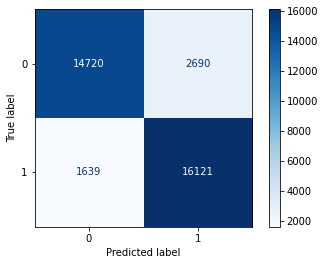

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  4.8378250e-01
   7.1563240e-01  1.5329393e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  2.5320196e-01
   4.7839270e-01  1.4637036e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  1.7928034e-01
  -1.2109529e+00 -1.0720505e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -4.0417194e+00
   1.5861686e+01  2.0988726e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -4.2235280e+00
   1.6993567e+01  1.9338606e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -2.8243313e+00
   1.5352282e+01  1.9930150e+01]]
(179136, 24)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 3160.476208
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     18060
           1       0.85      0.91      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

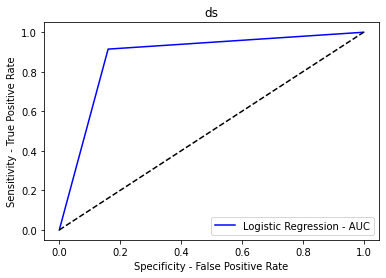

AUC: 0.8771319082194594
Confusion Matrix : 
 [[15163  2897]
 [ 1584 16980]]
Accuracy :  0.8776485364788117
Sensitivity :  0.8395902547065338
Specificity :  0.9146735617323852


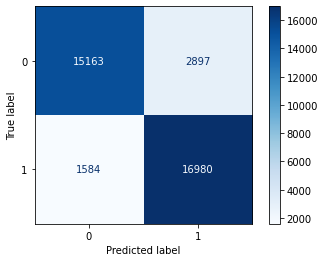

Regresion Logistica Validation


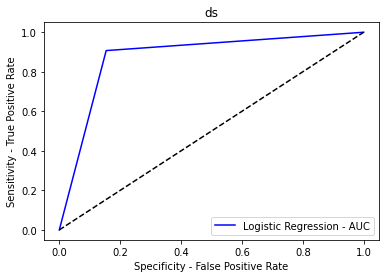

AUC: 0.8765789051544364
Confusion Matrix : 
 [[14728  2682]
 [ 1648 16112]]
Accuracy :  0.8768837077054308
Sensitivity :  0.8459506031016657
Specificity :  0.9072072072072072


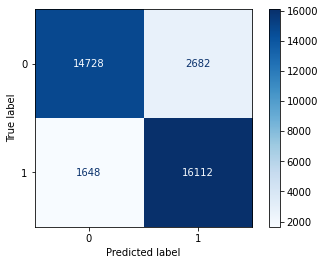

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  7.1563240e-01
   1.5329393e+00  6.7302580e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  4.7839270e-01
   1.4637036e+00  3.4440982e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.2109529e+00
  -1.0720505e+00 -2.9153440e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.5861686e+01
   2.0988726e+01 -1.0406415e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.6993567e+01
   1.9338606e+01  1.4133048e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.5352282e+01
   1.9930150e+01  1.6482737e+00]]
(179136, 25)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 3681.011915
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     18060
           1       0.85      0.91      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

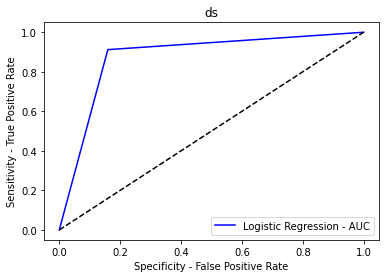

AUC: 0.8762828029243899
Confusion Matrix : 
 [[15180  2880]
 [ 1633 16931]]
Accuracy :  0.8767747924858017
Sensitivity :  0.840531561461794
Specificity :  0.9120340443869855


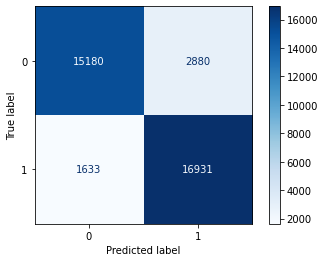

Regresion Logistica Validation


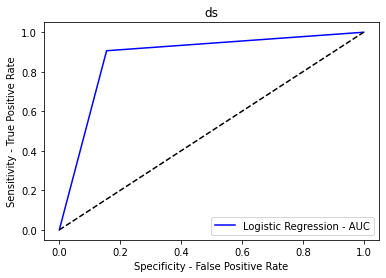

AUC: 0.8755523742438591
Confusion Matrix : 
 [[14705  2705]
 [ 1661 16099]]
Accuracy :  0.8758601080466306
Sensitivity :  0.8446295232624929
Specificity :  0.9064752252252253


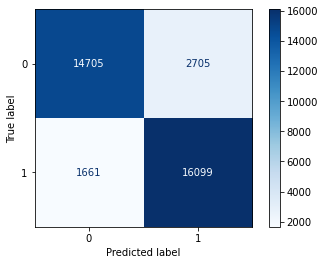

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.5329393e+00
   6.7302580e-01  1.7037824e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.4637036e+00
   3.4440982e-01  1.2851641e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.0720505e+00
  -2.9153440e+00 -2.4025688e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  2.0988726e+01
  -1.0406415e+00  1.4290014e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.9338606e+01
   1.4133048e+00  1.2103041e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.9930150e+01
   1.6482737e+00  1.1719766e+01]]
(179136, 26)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4133.981943
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     18060
           1       0.85      0.91      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

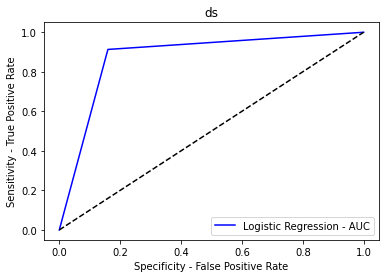

AUC: 0.8766568702615214
Confusion Matrix : 
 [[15176  2884]
 [ 1615 16949]]
Accuracy :  0.8771570554827436
Sensitivity :  0.8403100775193798
Specificity :  0.913003663003663


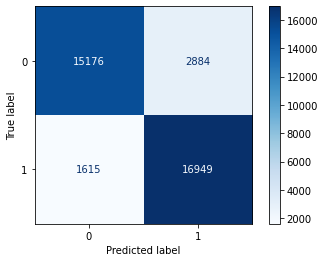

Regresion Logistica Validation


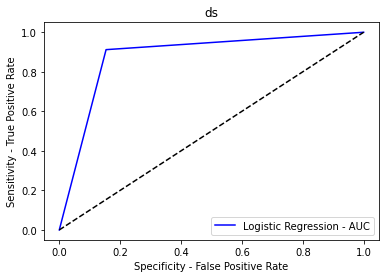

AUC: 0.8791160847809325
Confusion Matrix : 
 [[14734  2676]
 [ 1564 16196]]
Accuracy :  0.8794427068524311
Sensitivity :  0.8462952326249282
Specificity :  0.9119369369369369


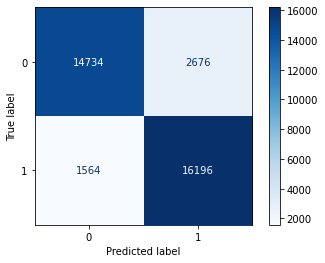

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  6.7302580e-01
   1.7037824e+00  2.6623630e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  3.4440982e-01
   1.2851641e+00  2.3050332e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -2.9153440e+00
  -2.4025688e+00 -1.5425726e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -1.0406415e+00
   1.4290014e+01  1.3639374e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.4133048e+00
   1.2103041e+01  1.7018663e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.6482737e+00
   1.1719766e+01  1.9273594e+01]]
(179136, 27)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4142.604351
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     18060
           1       0.85      0.92      0.88     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

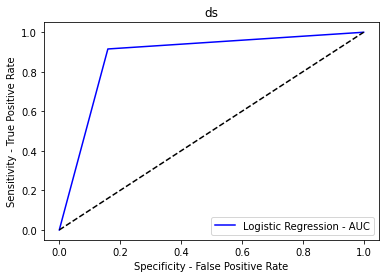

AUC: 0.8778973306675084
Confusion Matrix : 
 [[15178  2882]
 [ 1571 16993]]
Accuracy :  0.8784130624726955
Sensitivity :  0.8404208194905869
Specificity :  0.91537384184443


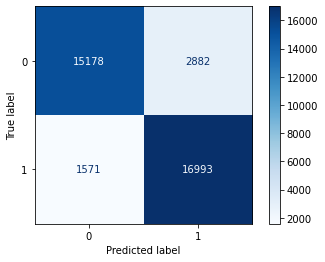

Regresion Logistica Validation


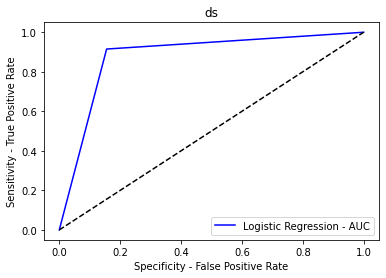

AUC: 0.8797742152692611
Confusion Matrix : 
 [[14703  2707]
 [ 1509 16251]]
Accuracy :  0.8801251066249645
Sensitivity :  0.8445146467547386
Specificity :  0.9150337837837837


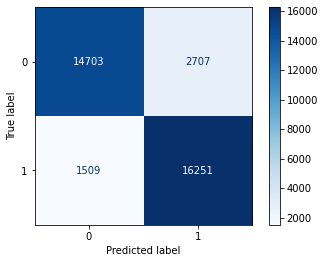

[[-461.9256      37.986633    14.340712  ...    1.7037824    2.662363
     1.8764641]
 [-453.95935     40.84214     13.285265  ...    1.2851641    2.3050332
     1.1385039]
 [-441.73483     48.792828    16.774529  ...   -2.4025688   -1.5425726
    -1.7955189]
 ...
 [-288.80374    133.47595     64.27397   ...   14.290014    13.639374
    17.718546 ]
 [-312.29477    145.09683     46.839935  ...   12.103041    17.018663
    15.059375 ]
 [-330.2163     145.90912     39.09671   ...   11.719766    19.273594
    13.061061 ]]
(179136, 28)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4596.912861
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     18060
           1       0.86      0.92      0.89     18564

    accuracy                           0.88     36624
   macro avg       0.89      0.88      0.88     36624
weighted avg       0.88      0.88      0.88     36624

Test time: 1.004934
      

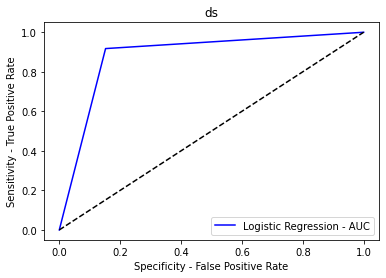

AUC: 0.8826591101556901
Confusion Matrix : 
 [[15314  2746]
 [ 1534 17030]]
Accuracy :  0.883136740934906
Sensitivity :  0.8479512735326689
Specificity :  0.9173669467787114


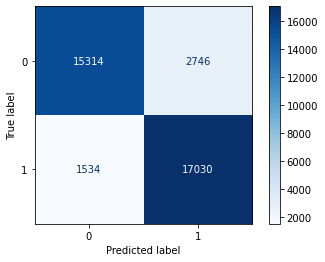

Regresion Logistica Validation


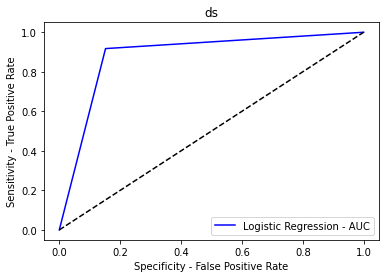

AUC: 0.8826803612917915
Confusion Matrix : 
 [[14764  2646]
 [ 1468 16292]]
Accuracy :  0.8830253056582315
Sensitivity :  0.8480183802412407
Specificity :  0.9173423423423424


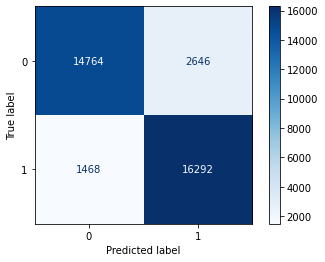

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  2.6623630e+00
   1.8764641e+00  4.0746415e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  2.3050332e+00
   1.1385039e+00  2.1913487e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.5425726e+00
  -1.7955189e+00 -1.4734760e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.3639374e+01
   1.7718546e+01  4.0317707e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.7018663e+01
   1.5059375e+01  7.6079130e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.9273594e+01
   1.3061061e+01  1.1113105e+01]]
(179136, 29)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5045.598507
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     18060
           1       0.86      0.92      0.89     18564

    accuracy                           0.88     36624
   macro avg       0.88      0.88      0.88     36624
weigh

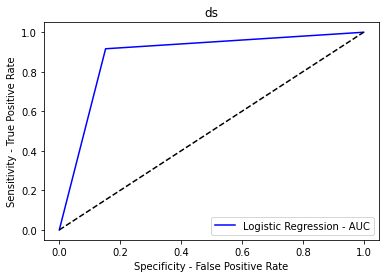

AUC: 0.8821189298617478
Confusion Matrix : 
 [[15312  2748]
 [ 1552 17012]]
Accuracy :  0.8825906509392748
Sensitivity :  0.8478405315614618
Specificity :  0.916397328162034


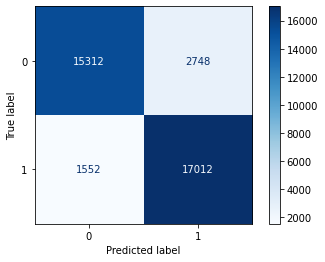

Regresion Logistica Validation


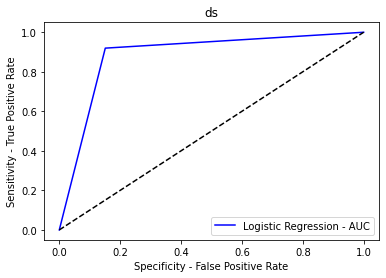

AUC: 0.8842372743219956
Confusion Matrix : 
 [[14779  2631]
 [ 1428 16332]]
Accuracy :  0.8845891384702872
Sensitivity :  0.8488799540493969
Specificity :  0.9195945945945946


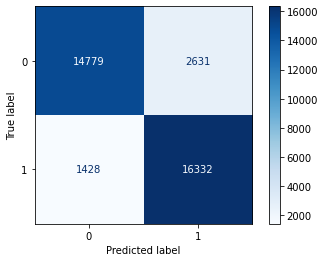

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  1.8764641e+00
   4.0746415e-01 -2.0150566e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  1.1385039e+00
   2.1913487e-01 -2.4271498e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.7955189e+00
  -1.4734760e+00 -2.8808130e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  1.7718546e+01
   4.0317707e+00  1.2590197e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  1.5059375e+01
   7.6079130e+00  1.0630671e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.3061061e+01
   1.1113105e+01  8.9748470e+00]]
(179136, 30)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5810.559034
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.86      0.89     18060
           1       0.87      0.93      0.90     18564

    accuracy                           0.90     36624
   macro avg       0.90      0.90      0.90     36624
weigh

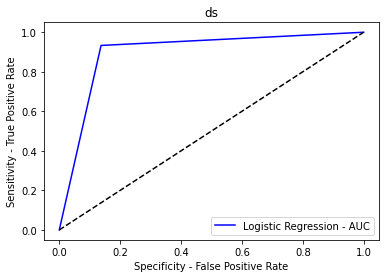

AUC: 0.8979973742627642
Confusion Matrix : 
 [[15582  2478]
 [ 1240 17324]]
Accuracy :  0.8984818698121451
Sensitivity :  0.8627906976744186
Specificity :  0.9332040508511097


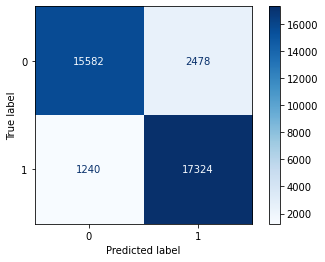

Regresion Logistica Validation


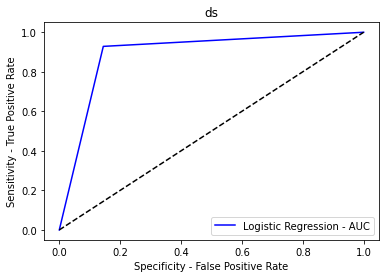

AUC: 0.8919594529911876
Confusion Matrix : 
 [[14893  2517]
 [ 1270 16490]]
Accuracy :  0.8923230025589991
Sensitivity :  0.8554279149913843
Specificity :  0.928490990990991


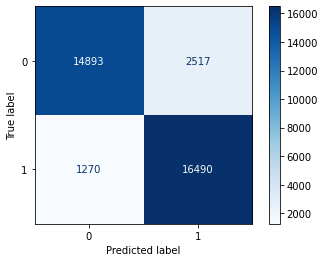

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ...  4.0746415e-01
  -2.0150566e+00 -2.7840707e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ...  2.1913487e-01
  -2.4271498e+00 -2.5710351e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.4734760e+00
  -2.8808130e+00 -1.2685525e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  4.0317707e+00
   1.2590197e+01 -1.8728788e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  7.6079130e+00
   1.0630671e+01 -4.7348905e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  1.1113105e+01
   8.9748470e+00  9.7487970e-01]]
(179136, 31)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 5803.509951
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.87      0.89     18060
           1       0.88      0.93      0.90     18564

    accuracy                           0.90     36624
   macro avg       0.90      0.90      0.90     36624
weigh

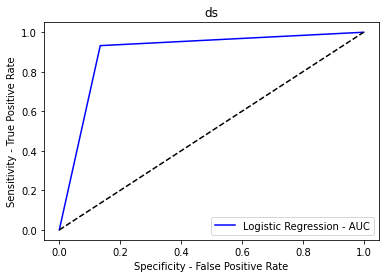

AUC: 0.8988684024593737
Confusion Matrix : 
 [[15630  2430]
 [ 1257 17307]]
Accuracy :  0.8993283093053736
Sensitivity :  0.8654485049833887
Specificity :  0.9322882999353588


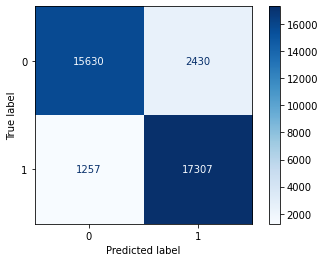

Regresion Logistica Validation


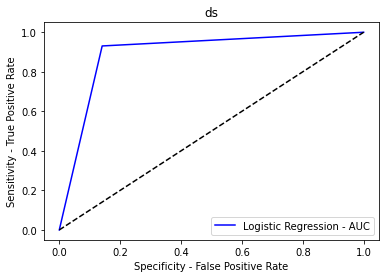

AUC: 0.8948672969350742
Confusion Matrix : 
 [[14957  2453]
 [ 1232 16528]]
Accuracy :  0.8952232015922661
Sensitivity :  0.8591039632395175
Specificity :  0.9306306306306307


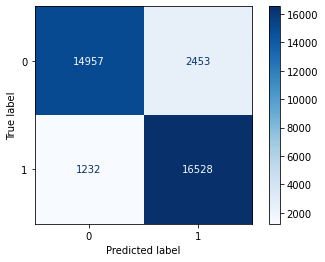

[[-461.9256       37.986633     14.340712   ...   -2.0150566
    -2.7840707    -1.9289997 ]
 [-453.95935      40.84214      13.285265   ...   -2.4271498
    -2.5710351    -1.5277772 ]
 [-441.73483      48.792828     16.774529   ...   -2.880813
    -1.2685525     0.8064476 ]
 ...
 [-288.80374     133.47595      64.27397    ...   12.590197
    -1.8728788    -6.974159  ]
 [-312.29477     145.09683      46.839935   ...   10.630671
    -0.47348905   -8.903156  ]
 [-330.2163      145.90912      39.09671    ...    8.974847
     0.9748797    -9.885742  ]]
(179136, 32)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 6958.697557
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     18060
           1       0.89      0.94      0.91     18564

    accuracy                           0.91     36624
   macro avg       0.91      0.91      0.91     36624
weighted avg       0.91      0.91      0.91     366

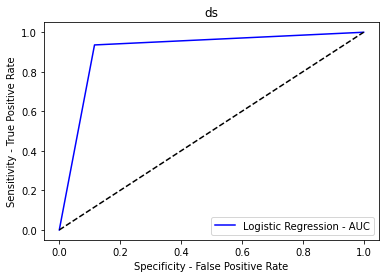

AUC: 0.9100321702920883
Confusion Matrix : 
 [[15970  2090]
 [ 1192 17372]]
Accuracy :  0.9103866317169069
Sensitivity :  0.8842746400885936
Specificity :  0.9357897004955829


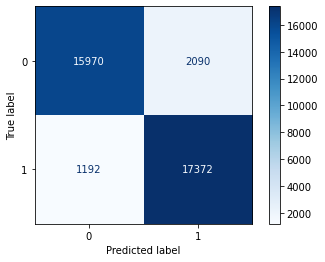

Regresion Logistica Validation


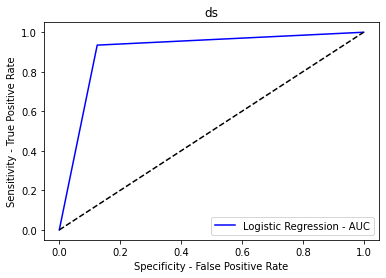

AUC: 0.9051350154721062
Confusion Matrix : 
 [[15241  2169]
 [ 1157 16603]]
Accuracy :  0.9054307648564117
Sensitivity :  0.8754164273406089
Specificity :  0.9348536036036036


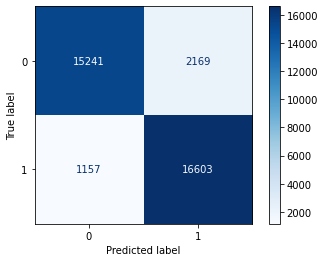

[[-461.9256       37.986633     14.340712   ...   -2.7840707
    -1.9289997    -0.8239684 ]
 [-453.95935      40.84214      13.285265   ...   -2.5710351
    -1.5277772    -0.96790946]
 [-441.73483      48.792828     16.774529   ...   -1.2685525
     0.8064476     1.7406626 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -1.8728788
    -6.974159     -5.9296203 ]
 [-312.29477     145.09683      46.839935   ...   -0.47348905
    -8.903156     -5.090643  ]
 [-330.2163      145.90912      39.09671    ...    0.9748797
    -9.885742     -5.1870213 ]]
(179136, 33)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 7045.590162
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     18060
           1       0.89      0.94      0.92     18564

    accuracy                           0.91     36624
   macro avg       0.91      0.91      0.91     36624
weighted avg       0.91      0.91      0.91   

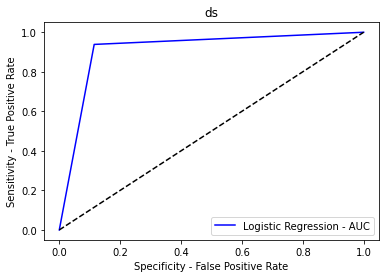

AUC: 0.9118779533280218
Confusion Matrix : 
 [[15989  2071]
 [ 1143 17421]]
Accuracy :  0.9122433377020533
Sensitivity :  0.8853266888150609
Specificity :  0.9384292178409825


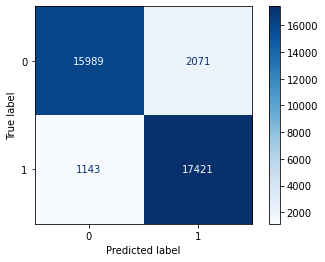

Regresion Logistica Validation


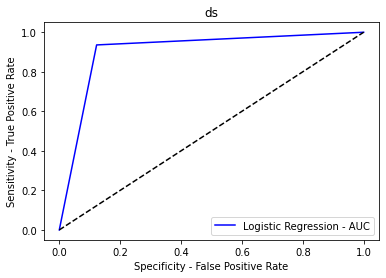

AUC: 0.9065900693916202
Confusion Matrix : 
 [[15275  2135]
 [ 1140 16620]]
Accuracy :  0.9068808643730452
Sensitivity :  0.8773693279724296
Specificity :  0.9358108108108109


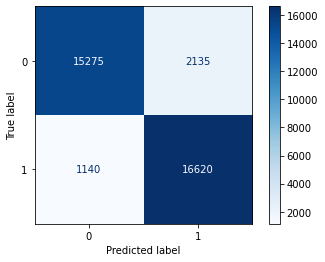

[[-461.9256       37.986633     14.340712   ...   -1.9289997
    -0.8239684    -0.8239033 ]
 [-453.95935      40.84214      13.285265   ...   -1.5277772
    -0.96790946   -0.776129  ]
 [-441.73483      48.792828     16.774529   ...    0.8064476
     1.7406626     2.3599362 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -6.974159
    -5.9296203    -6.564605  ]
 [-312.29477     145.09683      46.839935   ...   -8.903156
    -5.090643    -10.502826  ]
 [-330.2163      145.90912      39.09671    ...   -9.885742
    -5.1870213   -12.6860695 ]]
(179136, 34)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 8300.735235
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92      0.92      0.92     36624
weighted avg       0.92      0.92      0.92     36

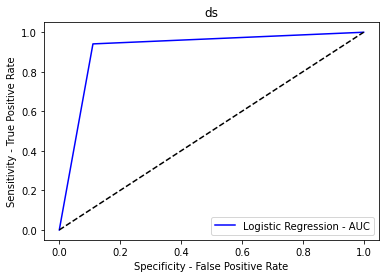

AUC: 0.9152464384680526
Confusion Matrix : 
 [[16063  1997]
 [ 1094 17470]]
Accuracy :  0.9156017911751857
Sensitivity :  0.8894241417497232
Specificity :  0.9410687351863822


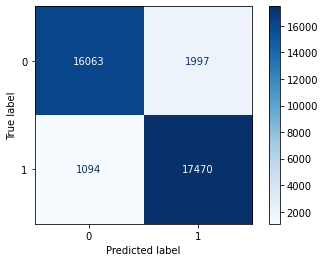

Regresion Logistica Validation


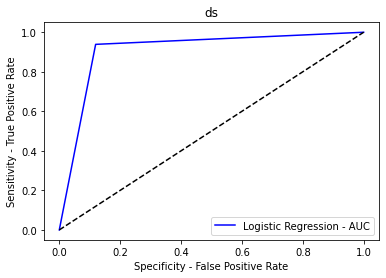

AUC: 0.9096623044641425
Confusion Matrix : 
 [[15331  2079]
 [ 1088 16672]]
Accuracy :  0.9099516633494455
Sensitivity :  0.8805858701895463
Specificity :  0.9387387387387387


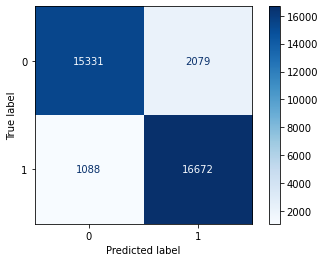

[[-461.9256       37.986633     14.340712   ...   -0.8239684
    -0.8239033    -0.7585975 ]
 [-453.95935      40.84214      13.285265   ...   -0.96790946
    -0.776129     -0.8901824 ]
 [-441.73483      48.792828     16.774529   ...    1.7406626
     2.3599362     2.9009528 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -5.9296203
    -6.564605    -11.893652  ]
 [-312.29477     145.09683      46.839935   ...   -5.090643
   -10.502826    -10.45147   ]
 [-330.2163      145.90912      39.09671    ...   -5.1870213
   -12.6860695   -10.637205  ]]
(179136, 35)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 8177.956820
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.94      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92      0.92      0.92     36624
weighted avg       0.92      0.92      0.92    

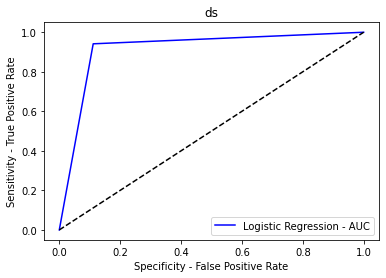

AUC: 0.9150466268797323
Confusion Matrix : 
 [[16048  2012]
 [ 1086 17478]]
Accuracy :  0.9154106596767148
Sensitivity :  0.88859357696567
Specificity :  0.9414996767937944


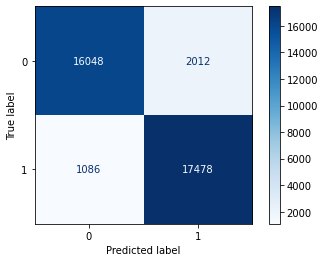

Regresion Logistica Validation


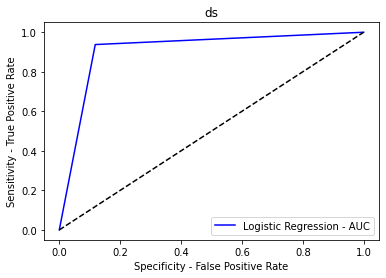

AUC: 0.9097873685000336
Confusion Matrix : 
 [[15353  2057]
 [ 1106 16654]]
Accuracy :  0.9100653966448677
Sensitivity :  0.881849511774842
Specificity :  0.9377252252252253


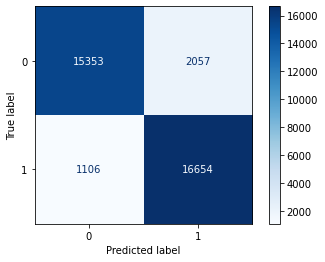

[[-4.61925600e+02  3.79866330e+01  1.43407120e+01 ... -8.23903300e-01
  -7.58597500e-01 -2.31974120e-01]
 [-4.53959350e+02  4.08421400e+01  1.32852650e+01 ... -7.76129000e-01
  -8.90182400e-01 -3.82844750e-01]
 [-4.41734830e+02  4.87928280e+01  1.67745290e+01 ...  2.35993620e+00
   2.90095280e+00  2.84461930e+00]
 ...
 [-2.88803740e+02  1.33475950e+02  6.42739700e+01 ... -6.56460500e+00
  -1.18936520e+01 -2.17236700e+00]
 [-3.12294770e+02  1.45096830e+02  4.68399350e+01 ... -1.05028260e+01
  -1.04514700e+01 -5.51757200e+00]
 [-3.30216300e+02  1.45909120e+02  3.90967100e+01 ... -1.26860695e+01
  -1.06372050e+01 -6.40657500e+00]]
(179136, 36)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 9026.968241
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92

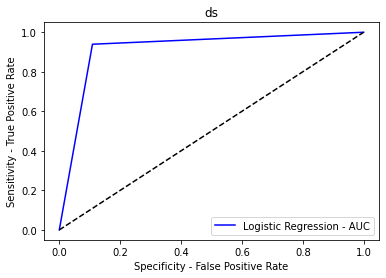

AUC: 0.9151874345444798
Confusion Matrix : 
 [[16092  1968]
 [ 1126 17438]]
Accuracy :  0.915519877675841
Sensitivity :  0.891029900332226
Specificity :  0.9393449687567335


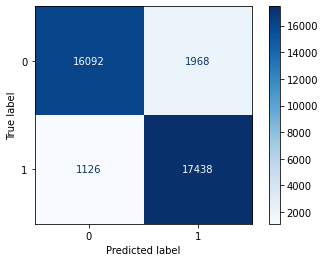

Regresion Logistica Validation


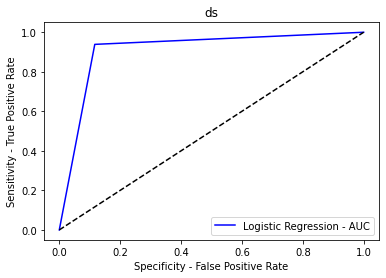

AUC: 0.9110413885309778
Confusion Matrix : 
 [[15380  2030]
 [ 1089 16671]]
Accuracy :  0.9113164628945124
Sensitivity :  0.8834003446295232
Specificity :  0.9386824324324324


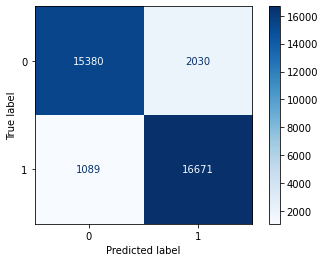

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -7.5859750e-01
  -2.3197412e-01 -1.5075194e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -8.9018240e-01
  -3.8284475e-01 -1.9251976e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  2.9009528e+00
   2.8446193e+00  7.6968170e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -1.1893652e+01
  -2.1723670e+00  8.1661665e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.0451470e+01
  -5.5175720e+00  2.3682394e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -1.0637205e+01
  -6.4065750e+00  7.1549577e-01]]
(179136, 37)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 9153.407335
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92      0.91      0.92     36624
weigh

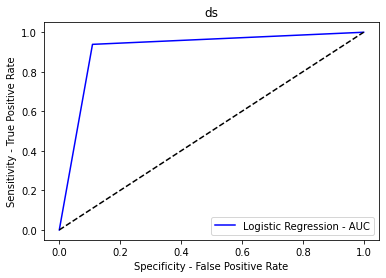

AUC: 0.9148357912037803
Confusion Matrix : 
 [[16090  1970]
 [ 1137 17427]]
Accuracy :  0.9151649191786806
Sensitivity :  0.8909191583610189
Specificity :  0.9387524240465417


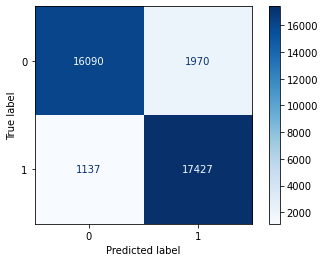

Regresion Logistica Validation


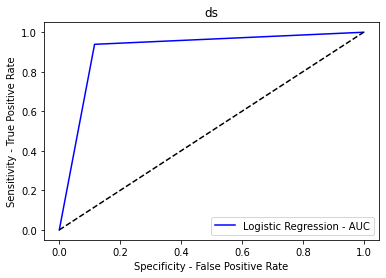

AUC: 0.9115267838200062
Confusion Matrix : 
 [[15392  2018]
 [ 1084 16676]]
Accuracy :  0.9117998294000569
Sensitivity :  0.8840896036760483
Specificity :  0.938963963963964


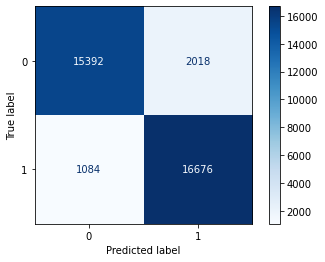

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -2.3197412e-01
  -1.5075194e+00 -5.7640696e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -3.8284475e-01
  -1.9251976e+00 -1.8170685e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  2.8446193e+00
   7.6968170e-01  2.2174199e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -2.1723670e+00
   8.1661665e-01 -3.5061902e-01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -5.5175720e+00
   2.3682394e+00 -2.5389256e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -6.4065750e+00
   7.1549577e-01 -2.1082022e+00]]
(179136, 38)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 10240.648985
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92      0.92      0.92     36624
weig

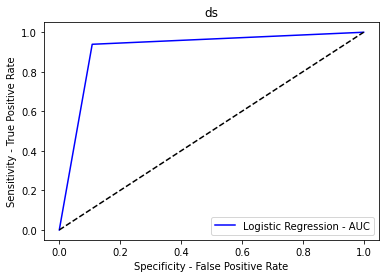

AUC: 0.9154949815346533
Confusion Matrix : 
 [[16107  1953]
 [ 1130 17434]]
Accuracy :  0.9158202271734381
Sensitivity :  0.891860465116279
Specificity :  0.9391294979530274


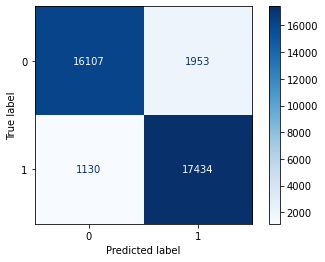

Regresion Logistica Validation


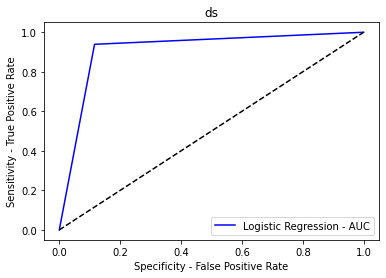

AUC: 0.9116123752270363
Confusion Matrix : 
 [[15394  2016]
 [ 1083 16677]]
Accuracy :  0.9118851293716236
Sensitivity :  0.8842044801838024
Specificity :  0.9390202702702702


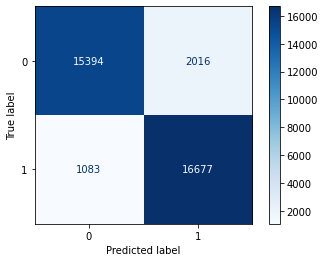

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -1.5075194e+00
  -5.7640696e-01  9.2514470e-01]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -1.9251976e+00
  -1.8170685e-01  1.4699571e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ...  7.6968170e-01
   2.2174199e+00  3.1055322e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ...  8.1661665e-01
  -3.5061902e-01  6.9917560e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ...  2.3682394e+00
  -2.5389256e+00  9.2868370e+00]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ...  7.1549577e-01
  -2.1082022e+00  8.9569100e+00]]
(179136, 39)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 9828.038692
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     18060
           1       0.90      0.94      0.92     18564

    accuracy                           0.92     36624
   macro avg       0.92      0.92      0.92     36624
weigh

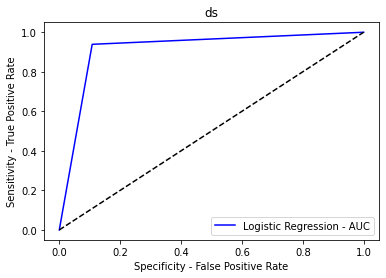

AUC: 0.9154418654760652
Confusion Matrix : 
 [[16108  1952]
 [ 1133 17431]]
Accuracy :  0.915765618173875
Sensitivity :  0.8919158361018826
Specificity :  0.9389678948502478


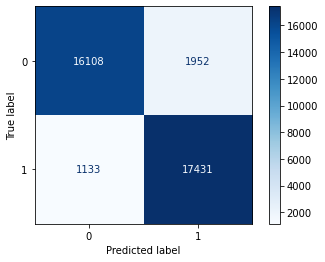

Regresion Logistica Validation


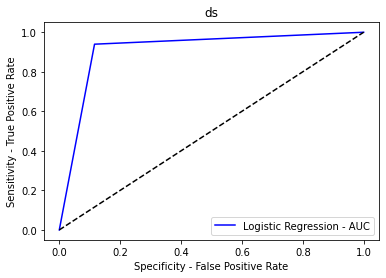

AUC: 0.9118939067585679
Confusion Matrix : 
 [[15394  2016]
 [ 1073 16687]]
Accuracy :  0.9121694626101792
Sensitivity :  0.8842044801838024
Specificity :  0.9395833333333333


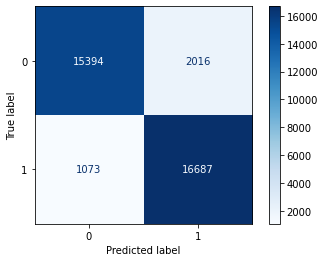

In [35]:
AUCFeaturesTest39MFCC, AUCFeaturesVal39MFCC = FeaturesFowardSelection(XE39MFCC, ygE39MFCC, XP39MFCC, ygP39MFCC, XV39MFCC, ygV39MFCC, 39)

In [36]:
print(AUCFeaturesTest39MFCC)

[0.5883808621838718, 0.6081188647194118, 0.6304266071365935, 0.6361875698401007, 0.6591879506722187, 0.6687643751597241, 0.6897901915685773, 0.6875865015057901, 0.6868195757730642, 0.7000990915149603, 0.7064603658994904, 0.7188470558169601, 0.7635357005056047, 0.7689973842846619, 0.7748147201635575, 0.8136424337176733, 0.8352738233039191, 0.8435789700495583, 0.8550892450003257, 0.8618317273242033, 0.8632578433878023, 0.8760784814820383, 0.8768543016491032, 0.8771319082194594, 0.8762828029243899, 0.8766568702615214, 0.8778973306675084, 0.8826591101556901, 0.8821189298617478, 0.8979973742627642, 0.8988684024593737, 0.9100321702920883, 0.9118779533280218, 0.9152464384680526, 0.9150466268797323, 0.9151874345444798, 0.9148357912037803, 0.9154949815346533, 0.9154418654760652]


In [37]:
print(AUCFeaturesVal39MFCC)

[0.5841068092791241, 0.60920302482264, 0.613619819561089, 0.6099631599577751, 0.6406880494796923, 0.6557972533130488, 0.6825982465808715, 0.6925791942861875, 0.6931726743975452, 0.6942085357902418, 0.7021511208221433, 0.7138433306942784, 0.7412252232847437, 0.7512036160226855, 0.7544389647401566, 0.8181269275450063, 0.8367554210586233, 0.8449989262668757, 0.8573351172827048, 0.860984289861372, 0.8621657358823499, 0.8748546255905533, 0.8766025305173065, 0.8765789051544364, 0.8755523742438591, 0.8791160847809325, 0.8797742152692611, 0.8826803612917915, 0.8842372743219956, 0.8919594529911876, 0.8948672969350742, 0.9051350154721062, 0.9065900693916202, 0.9096623044641425, 0.9097873685000336, 0.9110413885309778, 0.9115267838200062, 0.9116123752270363, 0.9118939067585679]


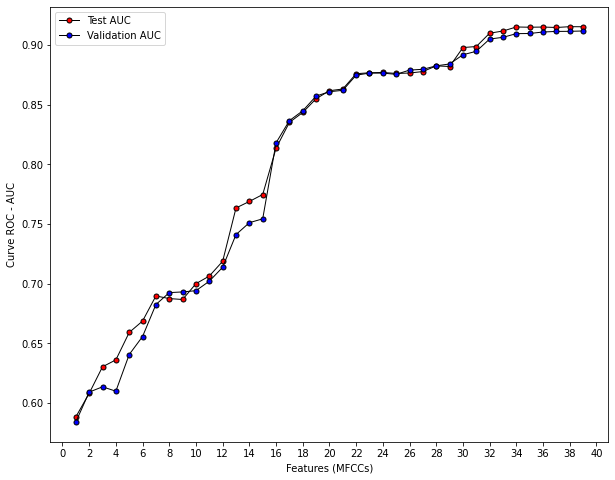

In [38]:
x = np.arange(1, len(AUCFeaturesTest39MFCC)+1)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x, AUCFeaturesTest39MFCC, lw=1, c='black', marker='.', ms=10, mfc='red', label='Test AUC')
plt.plot(x, AUCFeaturesVal39MFCC, lw=1, c='black', marker='.', ms=10, mfc='blue', label='Validation AUC')
plt.xlabel('Features (MFCCs)')
plt.ylabel('Curve ROC - AUC')
plt.legend()
ax.set_xticks(range(0, 42, 2))
plt.show()

[[-461.9256 ]
 [-453.95935]
 [-441.73483]
 ...
 [-288.80374]
 [-312.29477]
 [-330.2163 ]]
(179136, 1)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 285.231590
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.60      0.52      0.55     18060
           1       0.58      0.66      0.62     18564

    accuracy                           0.59     36624
   macro avg       0.59      0.59      0.59     36624
weighted avg       0.59      0.59      0.59     36624

Test time: 1.000404
              precision    recall  f1-score   support

           0       0.59      0.53      0.56     17410
           1       0.58      0.64      0.61     17760

    accuracy                           0.58     35170
   macro avg       0.59      0.58      0.58     35170
weighted avg       0.59      0.58      0.58     35170

Validation time: 0.000000
Regresion Logistica Test


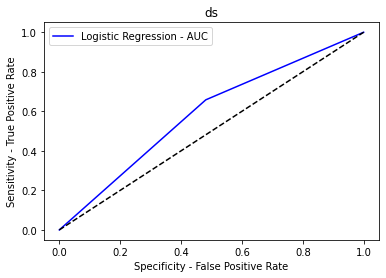

AUC: 0.5883808621838718
Confusion Matrix : 
 [[ 9367  8693]
 [ 6347 12217]]
Accuracy :  0.5893403232852774
Sensitivity :  0.5186600221483942
Specificity :  0.6581017022193493


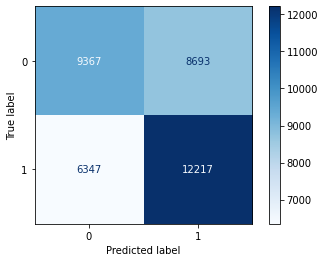

Regresion Logistica Validation


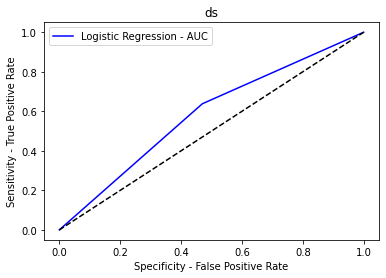

AUC: 0.5841068092791241
Confusion Matrix : 
 [[ 9226  8184]
 [ 6424 11336]]
Accuracy :  0.5846460051179982
Sensitivity :  0.5299253302699598
Specificity :  0.6382882882882883


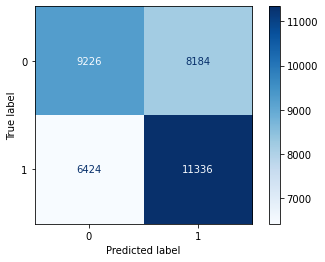

[[-461.9256     37.986633]
 [-453.95935    40.84214 ]
 [-441.73483    48.792828]
 ...
 [-288.80374   133.47595 ]
 [-312.29477   145.09683 ]
 [-330.2163    145.90912 ]]
(179136, 2)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 372.602940
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.62      0.53      0.57     18060
           1       0.60      0.69      0.64     18564

    accuracy                           0.61     36624
   macro avg       0.61      0.61      0.61     36624
weighted avg       0.61      0.61      0.61     36624

Test time: 1.000643
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.61      0.61      0.61     35170
weighted avg       0.61      0.61      0.61     35170

Validation time: 0.999928
Regresion L

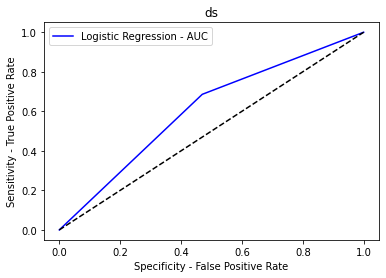

AUC: 0.6081188647194118
Confusion Matrix : 
 [[ 9576  8484]
 [ 5829 12735]]
Accuracy :  0.6091906946264745
Sensitivity :  0.5302325581395348
Specificity :  0.686005171299289


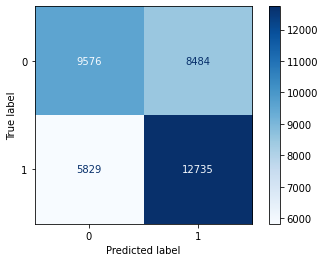

Regresion Logistica Validation


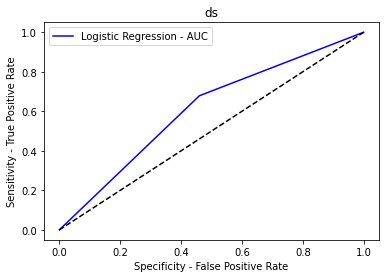

AUC: 0.60920302482264
Confusion Matrix : 
 [[ 9396  8014]
 [ 5706 12054]]
Accuracy :  0.6098947967017344
Sensitivity :  0.5396898334290637
Specificity :  0.6787162162162163


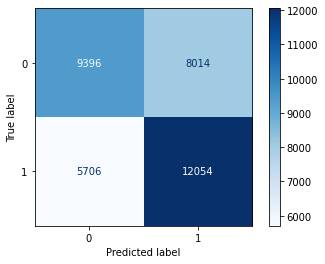

[[-461.9256     37.986633   14.340712]
 [-453.95935    40.84214    13.285265]
 [-441.73483    48.792828   16.774529]
 ...
 [-288.80374   133.47595    64.27397 ]
 [-312.29477   145.09683    46.839935]
 [-330.2163    145.90912    39.09671 ]]
(179136, 3)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 390.805006
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.55      0.60     18060
           1       0.62      0.71      0.66     18564

    accuracy                           0.63     36624
   macro avg       0.63      0.63      0.63     36624
weighted avg       0.63      0.63      0.63     36624

Test time: 0.995398
              precision    recall  f1-score   support

           0       0.63      0.54      0.58     17410
           1       0.60      0.69      0.64     17760

    accuracy                           0.61     35170
   macro avg       0.62      0.61      0.61     35170
weighted avg       0

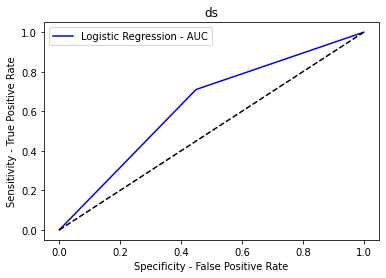

AUC: 0.6304266071365935
Confusion Matrix : 
 [[ 9943  8117]
 [ 5378 13186]]
Accuracy :  0.6315257754477938
Sensitivity :  0.5505537098560355
Specificity :  0.7102995044171515


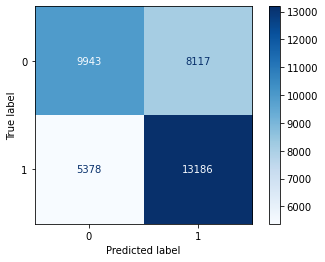

Regresion Logistica Validation


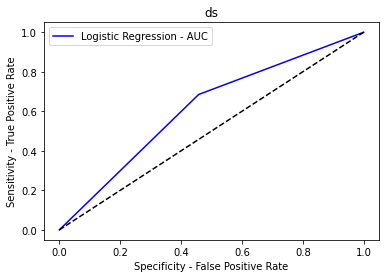

AUC: 0.613619819561089
Confusion Matrix : 
 [[ 9440  7970]
 [ 5594 12166]]
Accuracy :  0.6143303952232015
Sensitivity :  0.5422171165996553
Specificity :  0.6850225225225225


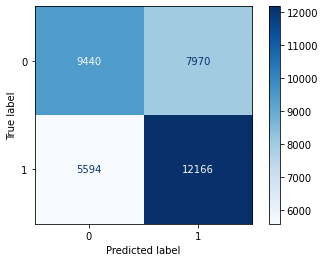

[[-461.9256       37.986633     14.340712      4.210198  ]
 [-453.95935      40.84214      13.285265      4.3595467 ]
 [-441.73483      48.792828     16.774529      6.6460085 ]
 ...
 [-288.80374     133.47595      64.27397      -0.57170194]
 [-312.29477     145.09683      46.839935      8.134534  ]
 [-330.2163      145.90912      39.09671       8.820234  ]]
(179136, 4)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 437.862158
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.65      0.56      0.61     18060
           1       0.63      0.71      0.66     18564

    accuracy                           0.64     36624
   macro avg       0.64      0.64      0.63     36624
weighted avg       0.64      0.64      0.64     36624

Test time: 1.000404
              precision    recall  f1-score   support

           0       0.62      0.54      0.58     17410
           1       0.60      0.68      0.64     17760

    accu

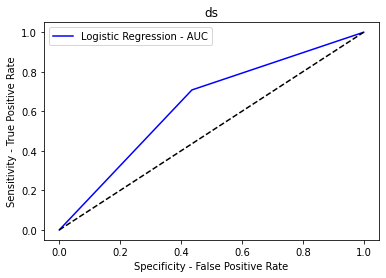

AUC: 0.6361875698401007
Confusion Matrix : 
 [[10190  7870]
 [ 5418 13146]]
Accuracy :  0.6371778069025775
Sensitivity :  0.5642303433001108
Specificity :  0.7081447963800905


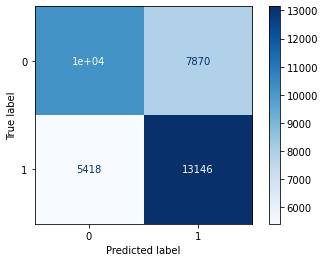

Regresion Logistica Validation


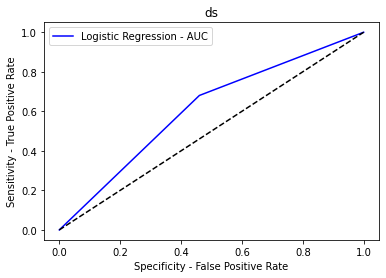

AUC: 0.6099631599577751
Confusion Matrix : 
 [[ 9396  8014]
 [ 5679 12081]]
Accuracy :  0.6106624964458345
Sensitivity :  0.5396898334290637
Specificity :  0.6802364864864865


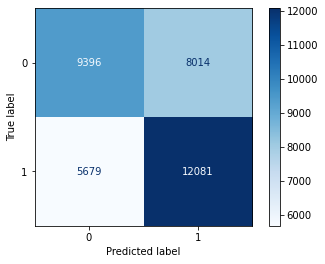

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01]]
(179136, 5)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 510.459661
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.68      0.59      0.63     18060
           1       0.65      0.72      0.68     18564

    accuracy                           0.66     36624
   macro avg       0.66      0.66      0.66     36624
weighted avg       0.66      0.66      0.66     36624

Test time: 1.164436
              precision    recall  f1-score   

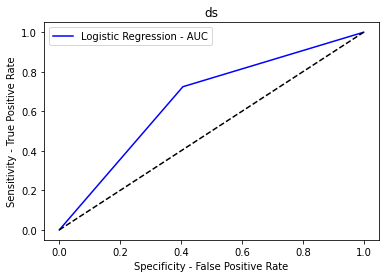

AUC: 0.6591879506722187
Confusion Matrix : 
 [[10726  7334]
 [ 5115 13449]]
Accuracy :  0.6600862822193098
Sensitivity :  0.5939091915836102
Specificity :  0.7244667097608274


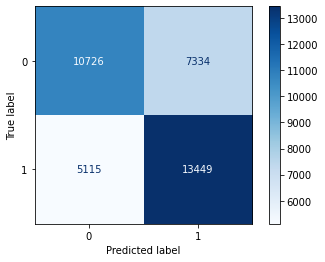

Regresion Logistica Validation


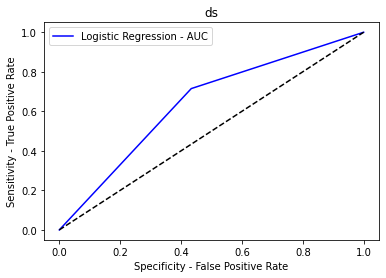

AUC: 0.6406880494796923
Confusion Matrix : 
 [[ 9861  7549]
 [ 5062 12698]]
Accuracy :  0.641427352857549
Sensitivity :  0.566398621481907
Specificity :  0.7149774774774775


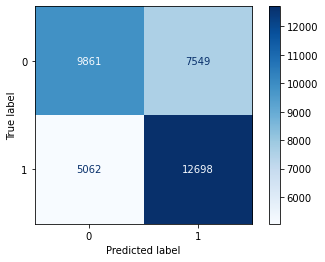

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01  4.2101980e+00
  -5.4178063e-02 -2.3872137e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01  4.3595467e+00
  -4.4440317e-01 -2.2336156e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01  6.6460085e+00
  -1.7909959e-01 -3.4468700e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 -5.7170194e-01
  -7.8325977e+00 -7.9153534e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01  8.1345340e+00
  -1.5897917e+01 -7.1443180e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01  8.8202340e+00
  -1.7901260e+01 -6.6536865e+01]]
(179136, 6)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 543.179274
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.69      0.60      0.64     18060
           1       0.66      0.73      0.69     18564

    accuracy                           0.67     36624
   macro avg       0.67      0.67      0.67     36624
weighted avg       0.67      0.

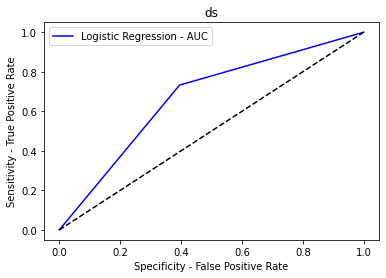

AUC: 0.6687643751597241
Confusion Matrix : 
 [[10925  7135]
 [ 4964 13600]]
Accuracy :  0.6696428571428571
Sensitivity :  0.6049280177187154
Specificity :  0.7326007326007326


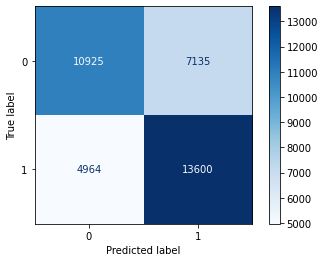

Regresion Logistica Validation


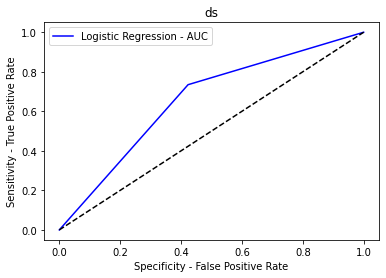

AUC: 0.6557972533130488
Confusion Matrix : 
 [[10044  7366]
 [ 4712 13048]]
Accuracy :  0.6565823144725619
Sensitivity :  0.5769098219414129
Specificity :  0.7346846846846847


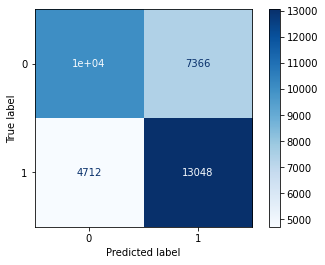

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -5.4178063e-02
  -2.3872137e+00 -6.9183330e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -4.4440317e-01
  -2.2336156e+00 -7.3383017e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -1.7909959e-01
  -3.4468700e+00 -1.0184973e+01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -7.8325977e+00
  -7.9153534e+01 -3.4108032e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -1.5897917e+01
  -7.1443180e+01 -3.5344510e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -1.7901260e+01
  -6.6536865e+01 -3.4597000e+01]]
(179136, 7)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 920.285225
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.67     18060
           1       0.68      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighte

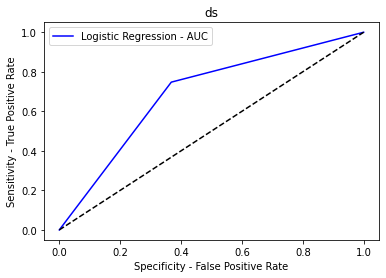

AUC: 0.6897901915685773
Confusion Matrix : 
 [[11414  6646]
 [ 4686 13878]]
Accuracy :  0.6905854084753167
Sensitivity :  0.6320044296788483
Specificity :  0.7475759534583064


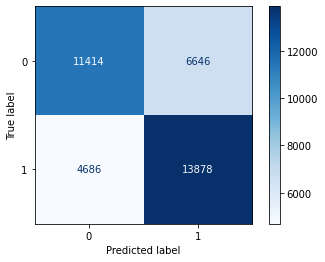

Regresion Logistica Validation


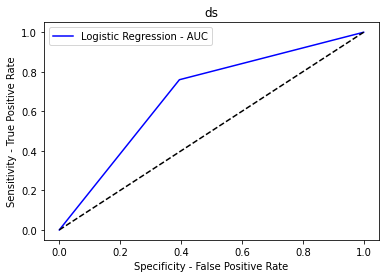

AUC: 0.6825982465808715
Confusion Matrix : 
 [[10540  6870]
 [ 4266 13494]]
Accuracy :  0.6833665055444982
Sensitivity :  0.6053991958644457
Specificity :  0.7597972972972973


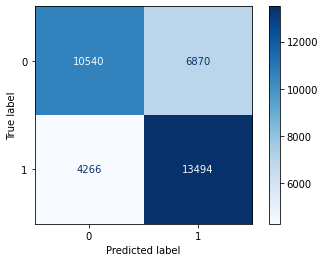

[[-461.9256      37.986633    14.340712  ...   -2.3872137   -6.918333
    -9.676699 ]
 [-453.95935     40.84214     13.285265  ...   -2.2336156   -7.3383017
   -10.662281 ]
 [-441.73483     48.792828    16.774529  ...   -3.44687    -10.184973
   -14.396601 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -79.153534   -34.108032
    13.913701 ]
 [-312.29477    145.09683     46.839935  ...  -71.44318    -35.34451
    10.800596 ]
 [-330.2163     145.90912     39.09671   ...  -66.536865   -34.597
     6.568719 ]]
(179136, 8)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 866.768122
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 0.999689
             

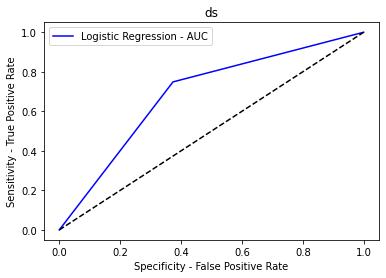

AUC: 0.6875865015057901
Confusion Matrix : 
 [[11313  6747]
 [ 4664 13900]]
Accuracy :  0.6884283529925732
Sensitivity :  0.6264119601328904
Specificity :  0.7487610428786899


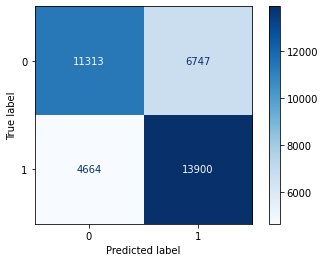

Regresion Logistica Validation


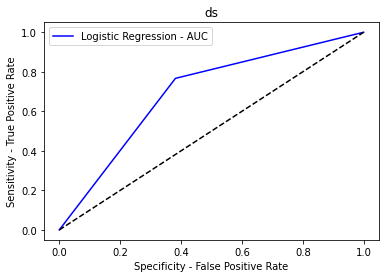

AUC: 0.6925791942861875
Confusion Matrix : 
 [[10765  6645]
 [ 4141 13619]]
Accuracy :  0.6933181688939437
Sensitivity :  0.6183228029867892
Specificity :  0.7668355855855856


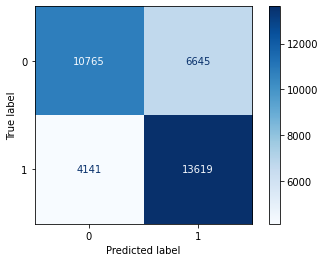

[[-461.9256      37.986633    14.340712  ...   -6.918333    -9.676699
    -7.8132167]
 [-453.95935     40.84214     13.285265  ...   -7.3383017  -10.662281
    -7.4927154]
 [-441.73483     48.792828    16.774529  ...  -10.184973   -14.396601
   -10.996808 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -34.108032    13.913701
   -29.214916 ]
 [-312.29477    145.09683     46.839935  ...  -35.34451     10.800596
   -21.054426 ]
 [-330.2163     145.90912     39.09671   ...  -34.597        6.568719
   -12.276783 ]]
(179136, 9)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1063.322783
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.71      0.63      0.66     18060
           1       0.67      0.75      0.71     18564

    accuracy                           0.69     36624
   macro avg       0.69      0.69      0.69     36624
weighted avg       0.69      0.69      0.69     36624

Test time: 1.004934
         

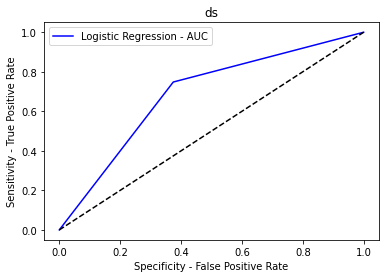

AUC: 0.6868195757730642
Confusion Matrix : 
 [[11296  6764]
 [ 4675 13889]]
Accuracy :  0.6876638269986893
Sensitivity :  0.6254706533776301
Specificity :  0.7481684981684982


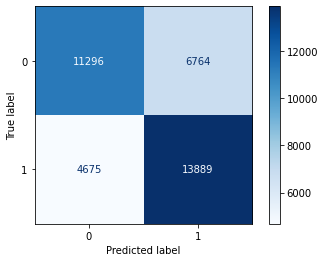

Regresion Logistica Validation


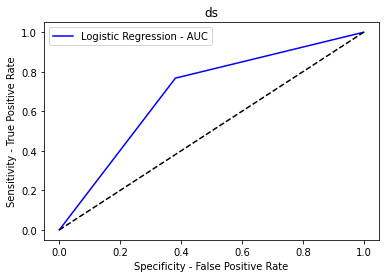

AUC: 0.6931726743975452
Confusion Matrix : 
 [[10769  6641]
 [ 4124 13636]]
Accuracy :  0.6939152686949104
Sensitivity :  0.6185525560022975
Specificity :  0.7677927927927928


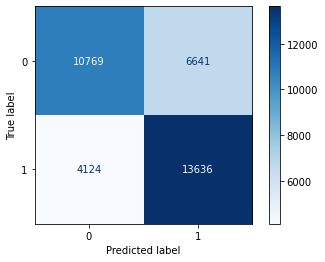

[[-461.9256      37.986633    14.340712  ...   -9.676699    -7.8132167
    -9.168781 ]
 [-453.95935     40.84214     13.285265  ...  -10.662281    -7.4927154
    -9.833818 ]
 [-441.73483     48.792828    16.774529  ...  -14.396601   -10.996808
   -13.579085 ]
 ...
 [-288.80374    133.47595     64.27397   ...   13.913701   -29.214916
   -29.069393 ]
 [-312.29477    145.09683     46.839935  ...   10.800596   -21.054426
   -36.612003 ]
 [-330.2163     145.90912     39.09671   ...    6.568719   -12.276783
   -43.515823 ]]
(179136, 10)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1237.536192
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.63      0.68     18060
           1       0.68      0.77      0.72     18564

    accuracy                           0.70     36624
   macro avg       0.70      0.70      0.70     36624
weighted avg       0.70      0.70      0.70     36624

Test time: 0.996113
      

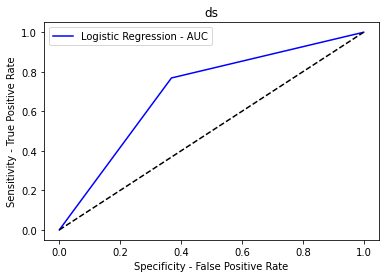

AUC: 0.7000990915149603
Confusion Matrix : 
 [[11405  6655]
 [ 4294 14270]]
Accuracy :  0.7010430318916557
Sensitivity :  0.6315060908084164
Specificity :  0.768692092221504


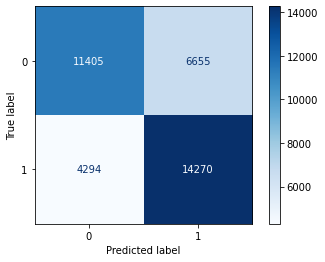

Regresion Logistica Validation


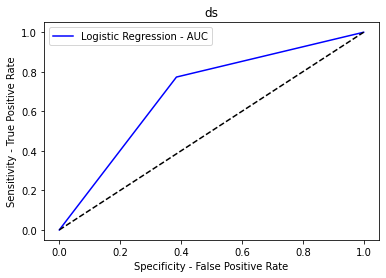

AUC: 0.6942085357902418
Confusion Matrix : 
 [[10709  6701]
 [ 4026 13734]]
Accuracy :  0.6949957350014216
Sensitivity :  0.6151062607696726
Specificity :  0.7733108108108108


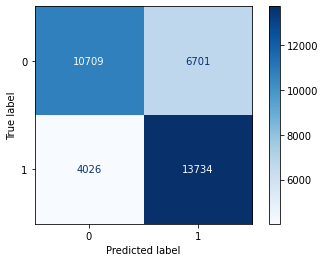

[[-461.9256      37.986633    14.340712  ...   -7.8132167   -9.168781
   -10.380377 ]
 [-453.95935     40.84214     13.285265  ...   -7.4927154   -9.833818
   -11.587559 ]
 [-441.73483     48.792828    16.774529  ...  -10.996808   -13.579085
   -16.023682 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.214916   -29.069393
   -48.466904 ]
 [-312.29477    145.09683     46.839935  ...  -21.054426   -36.612003
   -41.964684 ]
 [-330.2163     145.90912     39.09671   ...  -12.276783   -43.515823
   -35.94929  ]]
(179136, 11)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1698.231936
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.73      0.64      0.68     18060
           1       0.69      0.78      0.73     18564

    accuracy                           0.71     36624
   macro avg       0.71      0.71      0.71     36624
weighted avg       0.71      0.71      0.71     36624

Test time: 1.000166
        

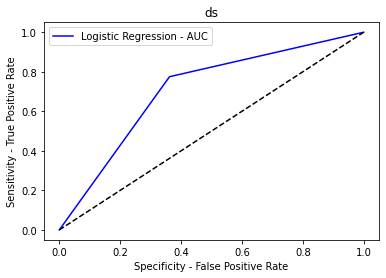

AUC: 0.7064603658994904
Confusion Matrix : 
 [[11519  6541]
 [ 4175 14389]]
Accuracy :  0.7074049803407602
Sensitivity :  0.6378183831672204
Specificity :  0.7751023486317604


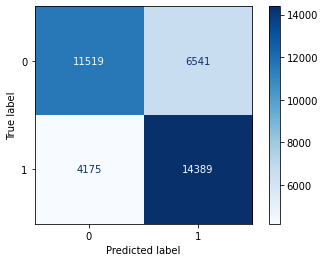

Regresion Logistica Validation


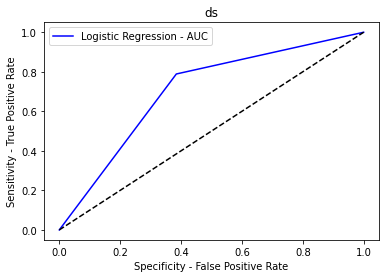

AUC: 0.7021511208221433
Confusion Matrix : 
 [[10715  6695]
 [ 3750 14010]]
Accuracy :  0.7030139323286893
Sensitivity :  0.6154508902929351
Specificity :  0.7888513513513513


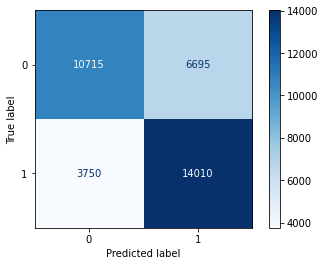

[[-461.9256      37.986633    14.340712  ...   -9.168781   -10.380377
    -8.284298 ]
 [-453.95935     40.84214     13.285265  ...   -9.833818   -11.587559
    -8.15322  ]
 [-441.73483     48.792828    16.774529  ...  -13.579085   -16.023682
   -11.017866 ]
 ...
 [-288.80374    133.47595     64.27397   ...  -29.069393   -48.466904
     5.8222713]
 [-312.29477    145.09683     46.839935  ...  -36.612003   -41.964684
     0.5614144]
 [-330.2163     145.90912     39.09671   ...  -43.515823   -35.94929
    -4.6305156]]
(179136, 12)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1754.460335
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.76      0.64      0.69     18060
           1       0.69      0.80      0.74     18564

    accuracy                           0.72     36624
   macro avg       0.72      0.72      0.72     36624
weighted avg       0.72      0.72      0.72     36624

Test time: 1.000166
         

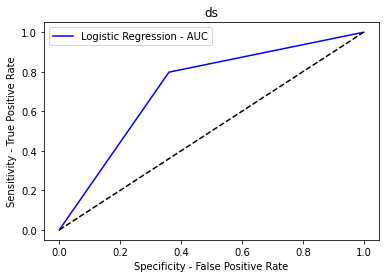

AUC: 0.7188470558169601
Confusion Matrix : 
 [[11551  6509]
 [ 3748 14816]]
Accuracy :  0.7199377457404981
Sensitivity :  0.6395902547065337
Specificity :  0.7981038569273864


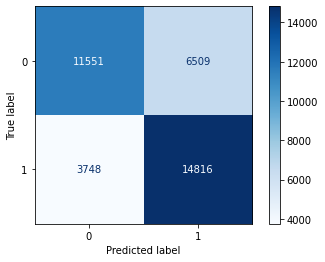

Regresion Logistica Validation


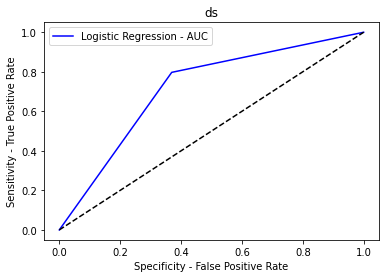

AUC: 0.7138433306942784
Confusion Matrix : 
 [[10979  6431]
 [ 3604 14156]]
Accuracy :  0.7146715951094683
Sensitivity :  0.6306145893164847
Specificity :  0.7970720720720721


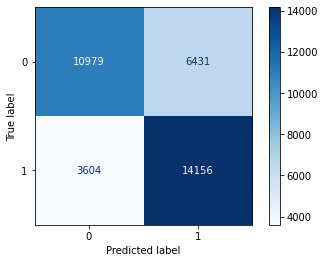

[[-461.9256       37.986633     14.340712   ...  -10.380377
    -8.284298     -7.0208225 ]
 [-453.95935      40.84214      13.285265   ...  -11.587559
    -8.15322      -7.858124  ]
 [-441.73483      48.792828     16.774529   ...  -16.023682
   -11.017866    -10.613985  ]
 ...
 [-288.80374     133.47595      64.27397    ...  -48.466904
     5.8222713    -4.2369475 ]
 [-312.29477     145.09683      46.839935   ...  -41.964684
     0.5614144    -0.96565664]
 [-330.2163      145.90912      39.09671    ...  -35.94929
    -4.6305156     1.540931  ]]
(179136, 13)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1920.389891
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     18060
           1       0.74      0.81      0.78     18564

    accuracy                           0.76     36624
   macro avg       0.77      0.76      0.76     36624
weighted avg       0.77      0.76      0.76     36624


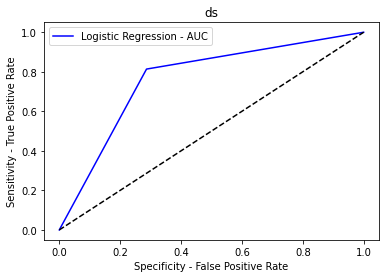

AUC: 0.7635357005056047
Confusion Matrix : 
 [[12884  5176]
 [ 3459 15105]]
Accuracy :  0.7642256443861949
Sensitivity :  0.7133997785160576
Specificity :  0.8136716224951519


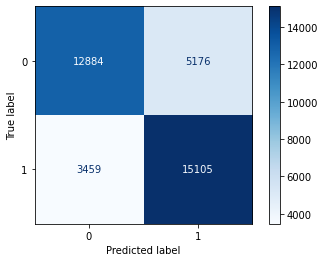

Regresion Logistica Validation


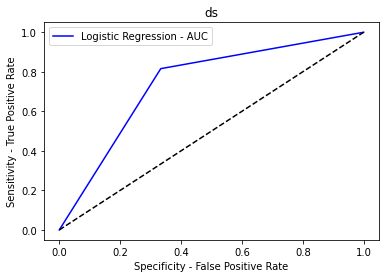

AUC: 0.7412252232847437
Confusion Matrix : 
 [[11606  5804]
 [ 3271 14489]]
Accuracy :  0.7419675860108047
Sensitivity :  0.6666283744974153
Specificity :  0.815822072072072


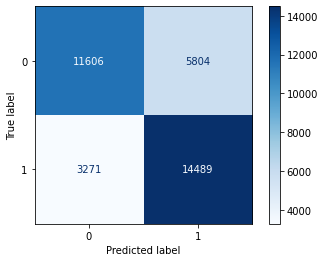

[[-461.9256       37.986633     14.340712   ...   -8.284298
    -7.0208225    -6.7342052 ]
 [-453.95935      40.84214      13.285265   ...   -8.15322
    -7.858124     -7.005454  ]
 [-441.73483      48.792828     16.774529   ...  -11.017866
   -10.613985     -8.312536  ]
 ...
 [-288.80374     133.47595      64.27397    ...    5.8222713
    -4.2369475    -9.252791  ]
 [-312.29477     145.09683      46.839935   ...    0.5614144
    -0.96565664  -12.189263  ]
 [-330.2163      145.90912      39.09671    ...   -4.6305156
     1.540931    -15.82521   ]]
(179136, 14)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2180.249929
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.71      0.75     18060
           1       0.75      0.82      0.78     18564

    accuracy                           0.77     36624
   macro avg       0.77      0.77      0.77     36624
weighted avg       0.77      0.77      0.77     366

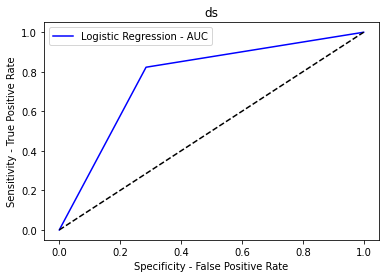

AUC: 0.7689973842846619
Confusion Matrix : 
 [[12912  5148]
 [ 3285 15279]]
Accuracy :  0.7697411533420708
Sensitivity :  0.7149501661129568
Specificity :  0.8230446024563671


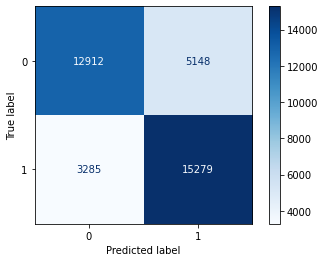

Regresion Logistica Validation


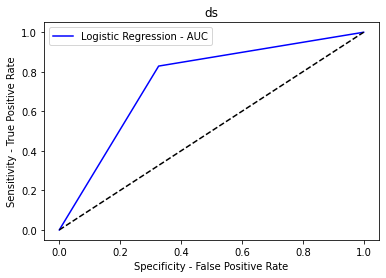

AUC: 0.7512036160226855
Confusion Matrix : 
 [[11727  5683]
 [ 3040 14720]]
Accuracy :  0.7519761160079613
Sensitivity :  0.6735784032165422
Specificity :  0.8288288288288288


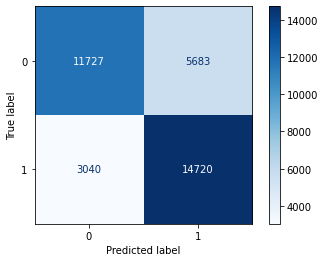

[[-461.9256       37.986633     14.340712   ...   -7.0208225
    -6.7342052    -5.565437  ]
 [-453.95935      40.84214      13.285265   ...   -7.858124
    -7.005454     -6.229723  ]
 [-441.73483      48.792828     16.774529   ...  -10.613985
    -8.312536     -6.4472723 ]
 ...
 [-288.80374     133.47595      64.27397    ...   -4.2369475
    -9.252791    -27.431974  ]
 [-312.29477     145.09683      46.839935   ...   -0.96565664
   -12.189263    -25.55872   ]
 [-330.2163      145.90912      39.09671    ...    1.540931
   -15.82521     -22.679249  ]]
(179136, 15)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2554.728985
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     18060
           1       0.75      0.83      0.79     18564

    accuracy                           0.78     36624
   macro avg       0.78      0.77      0.77     36624
weighted avg       0.78      0.78      0.77     3

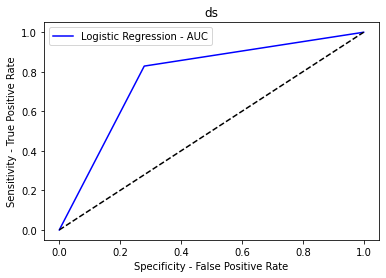

AUC: 0.7748147201635575
Confusion Matrix : 
 [[13019  5041]
 [ 3179 15385]]
Accuracy :  0.7755570117955439
Sensitivity :  0.720874861572536
Specificity :  0.8287545787545788


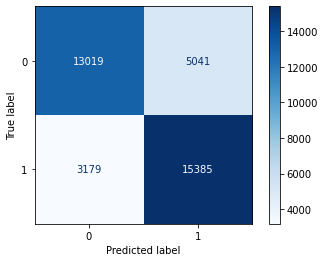

Regresion Logistica Validation


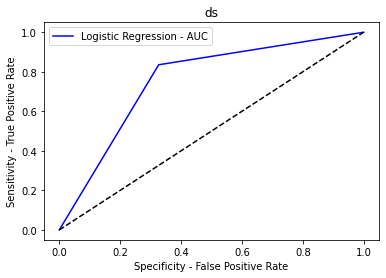

AUC: 0.7544389647401566
Confusion Matrix : 
 [[11723  5687]
 [ 2921 14839]]
Accuracy :  0.7552459482513506
Sensitivity :  0.6733486502010338
Specificity :  0.8355292792792792


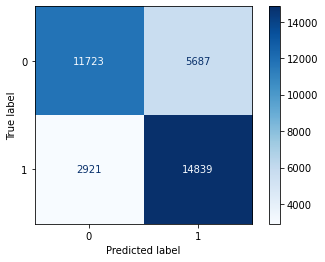

[[-461.9256      37.986633    14.340712  ...   -6.7342052   -5.565437
    -5.127263 ]
 [-453.95935     40.84214     13.285265  ...   -7.005454    -6.229723
    -4.7056503]
 [-441.73483     48.792828    16.774529  ...   -8.312536    -6.4472723
    -2.766725 ]
 ...
 [-288.80374    133.47595     64.27397   ...   -9.252791   -27.431974
     3.366393 ]
 [-312.29477    145.09683     46.839935  ...  -12.189263   -25.55872
     3.8001223]
 [-330.2163     145.90912     39.09671   ...  -15.82521    -22.679249
     3.110639 ]]
(179136, 16)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 1922.296286
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     18060
           1       0.80      0.84      0.82     18564

    accuracy                           0.81     36624
   macro avg       0.81      0.81      0.81     36624
weighted avg       0.81      0.81      0.81     36624

Test time: 1.000404
        

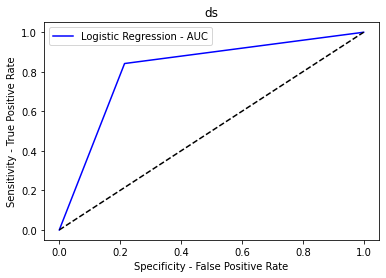

AUC: 0.8136424337176733
Confusion Matrix : 
 [[14187  3873]
 [ 2938 15626]]
Accuracy :  0.8140290519877675
Sensitivity :  0.7855481727574751
Specificity :  0.8417366946778712


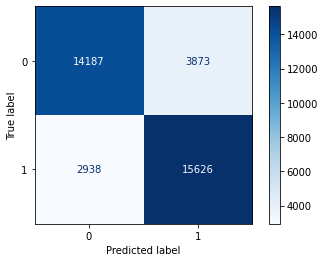

Regresion Logistica Validation


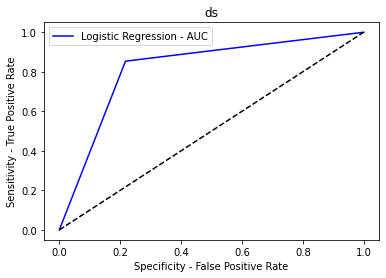

AUC: 0.8181269275450063
Confusion Matrix : 
 [[13623  3787]
 [ 2597 15163]]
Accuracy :  0.8184816605061132
Sensitivity :  0.78248133256749
Specificity :  0.8537725225225226


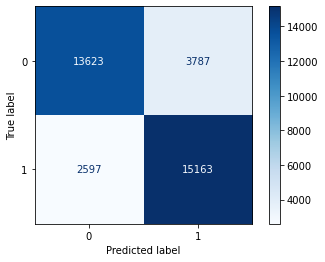

[[-461.9256      37.986633    14.340712  ...   -5.565437    -5.127263
    -8.357363 ]
 [-453.95935     40.84214     13.285265  ...   -6.229723    -4.7056503
    -8.663831 ]
 [-441.73483     48.792828    16.774529  ...   -6.4472723   -2.766725
    -6.69202  ]
 ...
 [-288.80374    133.47595     64.27397   ...  -27.431974     3.366393
    -1.1756334]
 [-312.29477    145.09683     46.839935  ...  -25.55872      3.8001223
    -4.477385 ]
 [-330.2163     145.90912     39.09671   ...  -22.679249     3.110639
    -7.3972797]]
(179136, 17)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2296.670914
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     18060
           1       0.82      0.86      0.84     18564

    accuracy                           0.84     36624
   macro avg       0.84      0.84      0.84     36624
weighted avg       0.84      0.84      0.84     36624

Test time: 0.997066
      

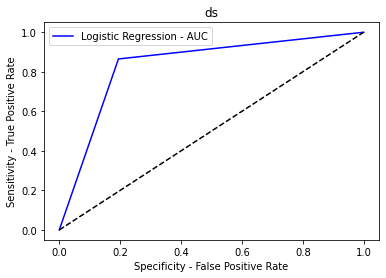

AUC: 0.8352738233039191
Confusion Matrix : 
 [[14550  3510]
 [ 2508 16056]]
Accuracy :  0.8356815203145478
Sensitivity :  0.8056478405315615
Specificity :  0.8648998060762767


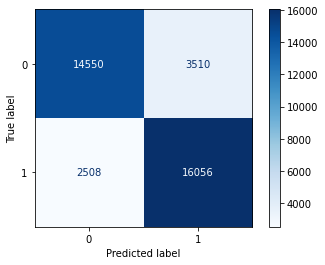

Regresion Logistica Validation


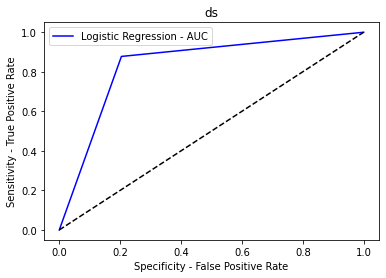

AUC: 0.8367554210586233
Confusion Matrix : 
 [[13856  3554]
 [ 2173 15587]]
Accuracy :  0.8371623542792153
Sensitivity :  0.7958644457208501
Specificity :  0.8776463963963964


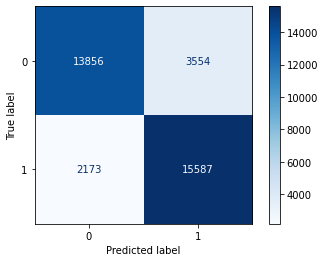

[[-461.9256      37.986633    14.340712  ...   -5.127263    -8.357363
    -7.4233713]
 [-453.95935     40.84214     13.285265  ...   -4.7056503   -8.663831
    -7.73197  ]
 [-441.73483     48.792828    16.774529  ...   -2.766725    -6.69202
    -5.436615 ]
 ...
 [-288.80374    133.47595     64.27397   ...    3.366393    -1.1756334
   -27.505428 ]
 [-312.29477    145.09683     46.839935  ...    3.8001223   -4.477385
   -24.265846 ]
 [-330.2163     145.90912     39.09671   ...    3.110639    -7.3972797
   -21.13058  ]]
(179136, 18)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2401.718616
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.84     18060
           1       0.82      0.88      0.85     18564

    accuracy                           0.84     36624
   macro avg       0.85      0.84      0.84     36624
weighted avg       0.85      0.84      0.84     36624

Test time: 1.996040
       

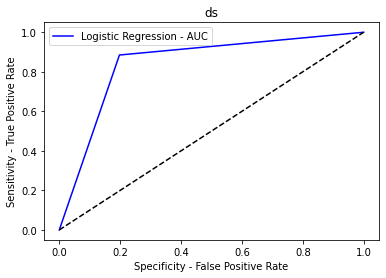

AUC: 0.8435789700495583
Confusion Matrix : 
 [[14491  3569]
 [ 2139 16425]]
Accuracy :  0.8441459152468327
Sensitivity :  0.8023809523809524
Specificity :  0.8847769877181642


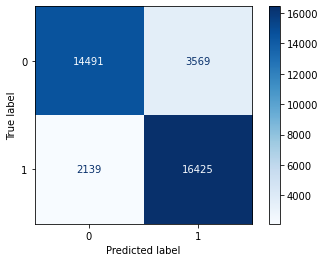

Regresion Logistica Validation


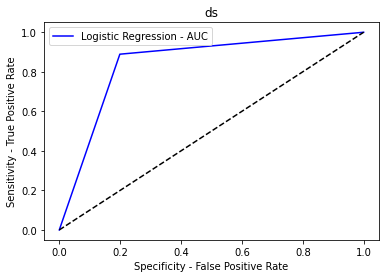

AUC: 0.8449989262668757
Confusion Matrix : 
 [[13946  3464]
 [ 1972 15788]]
Accuracy :  0.8454364515211829
Sensitivity :  0.8010338885697875
Specificity :  0.8889639639639639


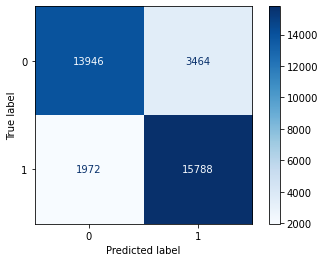

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -8.3573630e+00
  -7.4233713e+00 -4.1396527e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -8.6638310e+00
  -7.7319700e+00 -4.2945595e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -6.6920200e+00
  -5.4366150e+00 -1.8182391e+00]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -1.1756334e+00
  -2.7505428e+01  3.5549695e+00]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -4.4773850e+00
  -2.4265846e+01 -1.5246852e-01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -7.3972797e+00
  -2.1130580e+01 -4.1805015e+00]]
(179136, 19)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2732.274532
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     18060
           1       0.83      0.90      0.86     18564

    accuracy                           0.86     36624
   macro avg       0.86      0.86      0.86     36624
weigh

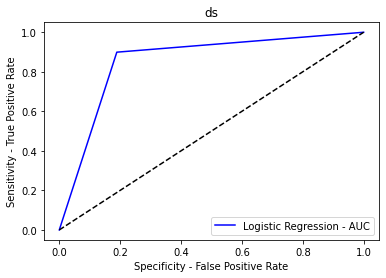

AUC: 0.8550892450003257
Confusion Matrix : 
 [[14647  3413]
 [ 1872 16692]]
Accuracy :  0.8556957186544343
Sensitivity :  0.8110188261351052
Specificity :  0.8991596638655462


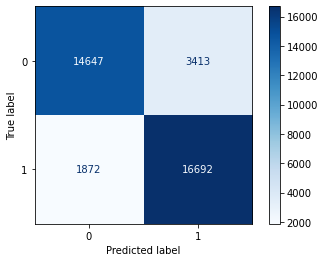

Regresion Logistica Validation


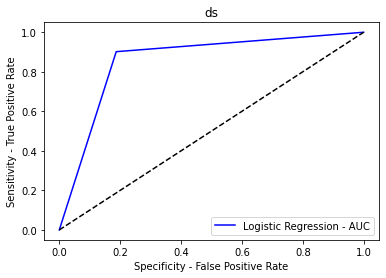

AUC: 0.8573351172827048
Confusion Matrix : 
 [[14154  3256]
 [ 1746 16014]]
Accuracy :  0.8577765140744953
Sensitivity :  0.8129810453762205
Specificity :  0.9016891891891892


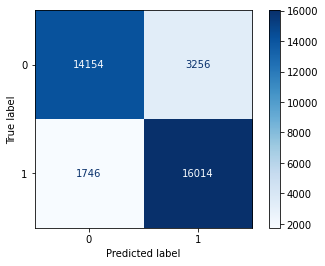

[[-4.6192560e+02  3.7986633e+01  1.4340712e+01 ... -7.4233713e+00
  -4.1396527e+00 -2.0040889e+00]
 [-4.5395935e+02  4.0842140e+01  1.3285265e+01 ... -7.7319700e+00
  -4.2945595e+00 -2.4416618e+00]
 [-4.4173483e+02  4.8792828e+01  1.6774529e+01 ... -5.4366150e+00
  -1.8182391e+00 -6.4428610e-01]
 ...
 [-2.8880374e+02  1.3347595e+02  6.4273970e+01 ... -2.7505428e+01
   3.5549695e+00  1.6328693e+01]
 [-3.1229477e+02  1.4509683e+02  4.6839935e+01 ... -2.4265846e+01
  -1.5246852e-01  1.8788227e+01]
 [-3.3021630e+02  1.4590912e+02  3.9096710e+01 ... -2.1130580e+01
  -4.1805015e+00  2.1952953e+01]]
(179136, 20)
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2277.044296
{'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     18060
           1       0.84      0.90      0.87     18564

    accuracy                           0.86     36624
   macro avg       0.86      0.86      0.86     36624
weigh

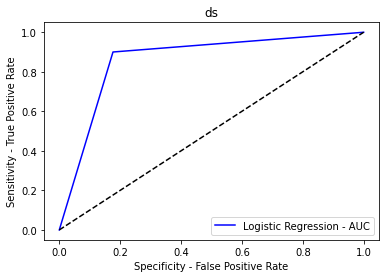

AUC: 0.8618317273242033
Confusion Matrix : 
 [[14874  3186]
 [ 1855 16709]]
Accuracy :  0.8623580166011359
Sensitivity :  0.8235880398671096
Specificity :  0.9000754147812972


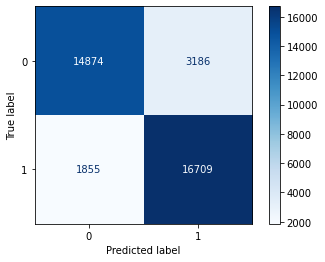

Regresion Logistica Validation


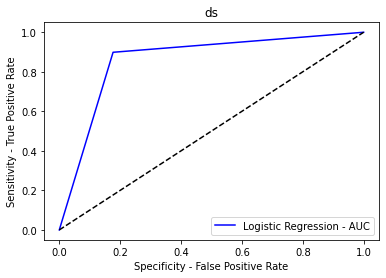

AUC: 0.860984289861372
Confusion Matrix : 
 [[14334  3076]
 [ 1800 15960]]
Accuracy :  0.8613591128802957
Sensitivity :  0.8233199310740954
Specificity :  0.8986486486486487


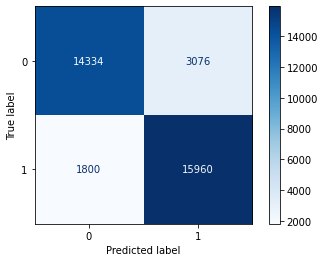

In [39]:
AUCFeaturesTest20MFCC, AUCFeaturesVal20MFCC = FeaturesFowardSelection(XE20MFCC, ygE20MFCC, XP20MFCC, ygP20MFCC, XV20MFCC, ygV20MFCC, 20)

In [40]:
print(AUCFeaturesTest20MFCC)

[0.5883808621838718, 0.6081188647194118, 0.6304266071365935, 0.6361875698401007, 0.6591879506722187, 0.6687643751597241, 0.6897901915685773, 0.6875865015057901, 0.6868195757730642, 0.7000990915149603, 0.7064603658994904, 0.7188470558169601, 0.7635357005056047, 0.7689973842846619, 0.7748147201635575, 0.8136424337176733, 0.8352738233039191, 0.8435789700495583, 0.8550892450003257, 0.8618317273242033]


In [41]:
print(AUCFeaturesVal20MFCC)

[0.5841068092791241, 0.60920302482264, 0.613619819561089, 0.6099631599577751, 0.6406880494796923, 0.6557972533130488, 0.6825982465808715, 0.6925791942861875, 0.6931726743975452, 0.6942085357902418, 0.7021511208221433, 0.7138433306942784, 0.7412252232847437, 0.7512036160226855, 0.7544389647401566, 0.8181269275450063, 0.8367554210586233, 0.8449989262668757, 0.8573351172827048, 0.860984289861372]


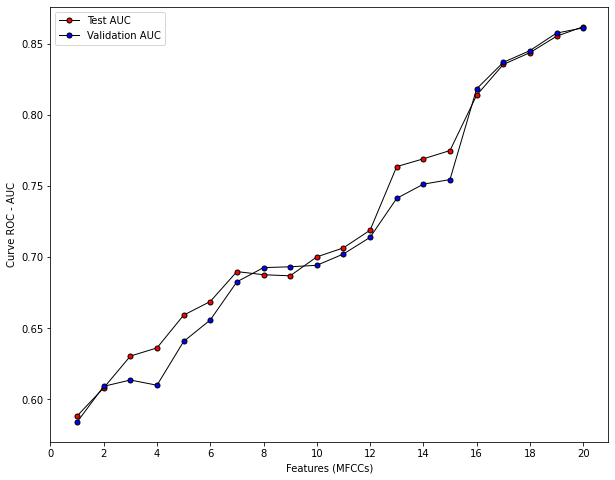

In [42]:
x = np.arange(1, len(AUCFeaturesTest20MFCC)+1)
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x, AUCFeaturesTest20MFCC, lw=1, c='black', marker='.', ms=10, mfc='red', label='Test AUC')
plt.plot(x, AUCFeaturesVal20MFCC, lw=1, c='black', marker='.', ms=10, mfc='blue', label='Validation AUC')
plt.xlabel('Features (MFCCs)')
plt.ylabel('Curve ROC - AUC')
plt.legend()
ax.set_xticks(range(0, 21, 2))
plt.show()

### Regresión logistica

In [43]:
def RLWithGridSearch(X_train, y_train, X_test, y_test, X_val, y_val, ctrl, titulo):
    #Se definen lo paramentros a probar para obtener el mejor modelo en base a los parametros 
    param_grid = {
        'solver': ['saga'],
        'penalty': ['l1'],
        'C': [0.01]
    }  
    #Se pasa como parametros el modelo, los parametros a probar, cross validation
    gridRL = GridSearchCV(LogisticRegression(), param_grid, verbose = 3, n_jobs=-1, cv=3) 
    #Tiempo de ejecucion 
    start_time = time()
    #Ajuste del modelo para la GridSearch
    gridRL.fit(X_train, y_train) 
    elapsed_time = (time() - start_time)*1000
    print("Training time: %f" % elapsed_time)
    #Imprime el mejor parámetro después del ajuste 
    print(gridRL.best_params_) 
    rlbest = gridRL.best_estimator_
    #Test
    start_time = time()
    grid_predictions_rl_T = rlbest.predict(X_test)
    elapsed_time = (time() - start_time)*1000
    # print classification report 
    print(classification_report(y_test, grid_predictions_rl_T))
    rep = classification_report(y_test, grid_predictions_rl_T)
    clasificacionPrueba = grid_predictions_rl_T
    print("Test time: %f" % elapsed_time)
    
    ##################################################Report classification algorithm
    #Imprimimos las métricas de nuestro algoritmo iumplementado
    #two classes
    if(ctrl==1):
        def plot_roc_curve(fper, tper, title):
            plt.plot(fper, tper, color='blue', label='Logistic regression - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title(str(title))
            plt.legend()
            plt.show()
        print("Regresion Logistica Test")
        fper, tper, thresholds = roc_curve(y_test, grid_predictions_rl_T)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_test, grid_predictions_rl_T)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_test, grid_predictions_rl_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        return clasificacionPrueba, accuracy1, sensitivity1, specificity1, metrics.auc(fper, tper)
    #Multiclass
    else:
        #Test
        print("AUC: "+str(roc_auc_score(y_test, rlbest.predict_proba(X_test), multi_class='ovr')))
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cnf_matrix  = confusion_matrix(y_test, grid_predictions_rl_T)
        rep = accuracy_score(y_test, grid_predictions_rl_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('Sensitivity: '+str(TPR))
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        print('Specificity: '+str(TNR))
        return clasificacionPrueba, rep, TPR, TNR, roc_auc_score(y_test, rlbest.predict_proba(X_test), multi_class='ovr')

### Ramdom Forest

In [44]:
def RFWithGridSearch(X_train, y_train, X_test, y_test, X_val, y_val, ctrl, titulo):
    #Se definen lo paramentros a probar para obtener el mejor modelo en base a los parametros 
    param_grid = {
        'n_estimators' : [1000],
        'max_features' : ['log2']
        
    }  
    #Se pasa como parametros el modelo, los parametros a probar, cross validation
    gridRF = GridSearchCV(RandomForestClassifier(), param_grid, verbose = 3, n_jobs=-1, cv=3) 
    start_time = time()
    #Ajuste del modelo para la GridSearch
    gridRF.fit(X_train, y_train)
    elapsed_time = (time() - start_time)*1000
    print("Training time: %f" % elapsed_time)
    #Imprime el mejor parámetro después del ajuste 
    print(gridRF.best_params_) 
    rfbest = gridRF.best_estimator_
    #Test
    start_time = time()
    grid_predictions_rf_T = rfbest.predict(X_test)
    elapsed_time = (time() - start_time)*1000
    # print classification report 
    print(classification_report(y_test, grid_predictions_rf_T)) 
    print("Test time: %f" % elapsed_time)
    rep = classification_report(y_test, grid_predictions_rf_T)
    clasificacionPrueba = grid_predictions_rf_T
    ##################################################Report classification algorithm
    #Imprimimos las métricas de nuestro algoritmo iumplementado
    #two classes
    if(ctrl==1):
        def plot_roc_curve(fper, tper, title):
            plt.plot(fper, tper, color='red', label='Random forest - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title(str(title))
            plt.legend()
            plt.show()
        print("Random Forest Test")
        fper, tper, thresholds = roc_curve(y_test, grid_predictions_rf_T)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_test, grid_predictions_rf_T)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_test, grid_predictions_rf_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        return clasificacionPrueba, accuracy1, sensitivity1, specificity1, metrics.auc(fper, tper)
    #Multiclass
    else:
        print("AUC: "+str(roc_auc_score(y_test, rfbest.predict_proba(X_test), multi_class='ovr')))
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cnf_matrix  = confusion_matrix(y_test, grid_predictions_rf_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        rep = accuracy_score(y_test, grid_predictions_rf_T)
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('Sensitivity: '+str(TPR))
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        print('Specificity: '+str(TNR))
        return clasificacionPrueba, rep, TPR, TNR, roc_auc_score(y_test, rfbest.predict_proba(X_test), multi_class='ovr')

### KNN

In [45]:
def KNNWithGridSearch(X_train, y_train, X_test, y_test, X_val, y_val, ctrl, titulo):
    #Definimos los vecinos con los que se va intentar trabajar
    #k_range = [13]
    #Se definen lo paramentros a probar para obtener el mejor modelo en base a los parametros 
    param_grid = {
        #'n_neighbors': [7,8,9],
        'n_neighbors': [9],
        'weights' : ['distance'],
        'metric' : ['manhattan']
    }  
    #Se pasa como parametros el modelo, los parametros a probar, cross validation
    gridKNN = GridSearchCV(KNeighborsClassifier(), param_grid, verbose = 3, cv=3) 
    start_time = time()
    #Ajuste del modelo para la GridSearch
    gridKNN.fit(X_train, y_train)
    elapsed_time = (time() - start_time)*1000
    print("Training time: %f" % elapsed_time)
    #Imprime el mejor parámetro después del ajuste 
    print(gridKNN.best_params_) 
    knnbest = gridKNN.best_estimator_
    
    
    #Test
    start_time = time()
    grid_predictions_knn_T = knnbest.predict(X_test)
    elapsed_time = (time() - start_time)*1000
    # print classification report 
    
    
    print(classification_report(y_test, grid_predictions_knn_T)) 
    print("Test time: %f" % elapsed_time)
    
    clasificacionPrueba = grid_predictions_knn_T
    
    
    
    if(ctrl==1):
        def plot_roc_curve(fper, tper, title):
            plt.plot(fper, tper, color='darkorange', label='K-nearest neighbors - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title(str(title))
            plt.legend()
            plt.show()
            
            
        print("KNN Test")
        fper, tper, thresholds = roc_curve(y_test, grid_predictions_knn_T)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_test, grid_predictions_knn_T)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_test, grid_predictions_knn_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
        return clasificacionPrueba, accuracy1, sensitivity1, specificity1, metrics.auc(fper, tper)
        
        
    #Multiclass
    else:
        print("AUC: "+str(roc_auc_score(y_test, knnbest.predict_proba(X_test), multi_class='ovr')))
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cnf_matrix  = confusion_matrix(y_test, grid_predictions_knn_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        rep = accuracy_score(y_test, grid_predictions_knn_T)
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('Sensitivity: '+str(TPR))
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        print('Specificity: '+str(TNR))
        return clasificacionPrueba, rep, TPR, TNR, roc_auc_score(y_test, knnbest.predict_proba(X_test), multi_class='ovr')

### SVM

In [46]:
def SVMWithGridSearch(X_train, y_train, X_test, y_test, X_val, y_val, ctrl, titulo):
    #Se definen lo paramentros a probar para obtener el mejor modelo en base a los parametros 
    param_grid = {
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'] #
    }  
    #Se pasa como parametros el modelo, los parametros a probar, cross validation
    gridSVM = GridSearchCV(SVC(probability=True), param_grid, cv=3) 
    #Ajuste del modelo para la GridSearch
    start_time = time()
    gridSVM.fit(X_train, y_train) 
    elapsed_time = (time() - start_time)*1000
    print("Training time: %f" % elapsed_time)
    #Imprime el mejor parámetro después del ajuste 
    print(gridSVM.best_params_) 
    smvbest = gridSVM.best_estimator_
    
    #Test
    start_time = time()
    grid_predictions_svm_T = smvbest.predict(X_test)
    elapsed_time = (time() - start_time)*1000
    # print classification report 
    print(classification_report(y_test, grid_predictions_svm_T)) 
    print("Test time: %f" % elapsed_time)
    
    #Validation
    start_time = time()
    grid_predictions_svm_V = smvbest.predict(X_val)
    elapsed_time = (time() - start_time)*1000
    # print classification report 
    print(classification_report(y_val, grid_predictions_svm_V)) 
    print("Validation time: %f" % elapsed_time)
    
    if(ctrl==1):
        def plot_roc_curve(fper, tper, title):
            plt.plot(fper, tper, color='blueviolet', label='Support Vector Machine - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title(str(title))
            plt.legend()
            plt.show()
        print("SVM Test")
        fper, tper, thresholds = roc_curve(y_test, grid_predictions_svm_T)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_test, grid_predictions_svm_T)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_test, grid_predictions_svm_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
        
        print("SVM Validation")
        fper, tper, thresholds = roc_curve(y_val, grid_predictions_svm_V)
        plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_val, grid_predictions_svm_V)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_val)
        cm = confusion_matrix(y_val, grid_predictions_svm_V)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
    #Multiclass
    else:
        print("AUC: "+str(roc_auc_score(y_test, smvbest.predict_proba(X_test), multi_class='ovr')))
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cnf_matrix  = confusion_matrix(y_test, grid_predictions_svm_T)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('Sensitivity: '+str(TPR))
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        print('Specificity: '+str(TNR))
        
        
        
        print("AUC: "+str(roc_auc_score(y_val, smvbest.predict_proba(X_val), multi_class='ovr')))
        le = preprocessing.LabelEncoder()
        le.fit(y_val)
        cnf_matrix  = confusion_matrix(y_val, grid_predictions_svm_V)
        disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
        FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
        TP = np.diag(cnf_matrix)
        TN = cnf_matrix.sum() - (FP + FN + TP)
        FP = FP.astype(float)
        FN = FN.astype(float)
        TP = TP.astype(float)
        TN = TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        print('Sensitivity: '+str(TPR))
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        print('Specificity: '+str(TNR))

### Red Neuronal

In [77]:
def neuronalNetwork(X_train, y_train, X_test, y_test, X_val, y_val, ctrl):
    start_time = time()
    aUnique = y_train
    unique, counts = np.unique(aUnique, return_counts=True)
    network = models.Sequential()
    network.add(layers.Dense(2048, activation='relu', input_shape=(X_train.shape[1],)))
    network.add(layers.Dense(unique.shape[0], activation='softmax'))
    network.compile(optimizer='Adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy', 'AUC', 'Recall', tf.keras.metrics.SpecificityAtSensitivity(0.5), 
                             tf.keras.metrics.SensitivityAtSpecificity(0.5)])
    train_labels = to_categorical(y_train)
    test_labels = to_categorical(y_test)
    val_labels = to_categorical(y_val)
    start_time = time()
    history = network.fit(X_train, train_labels, epochs=20, batch_size=40, validation_split = 0.3, verbose=1) 
    elapsed_time = (time() - start_time)*1000
    print("Training time: %f" % elapsed_time)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    
    
    
    def plot_loss(history):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.ylim([0, 2])
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.grid(True)
        plt.show()
    #plot_loss(history)
    elapsed_time = (time() - start_time)*1000
    print("Time:"+str(elapsed_time))
    
    start_time = time()
    X = network.evaluate(X_test, test_labels)
    y_pred = network.predict(X_test)
    print(X)
    elapsed_time = (time() - start_time)*1000
    print("Time test:"+str(elapsed_time))
    
    
    
   
   
    
    if(ctrl==1):
        start_time = time()
        X = network.evaluate(X_test, test_labels)
        y_pred = network.predict(X_test)
        elapsed_time = (time() - start_time)*1000
        
        #score = model.evaluate(input_test, target_test, verbose=0)
        print('Metrics:'+str(X))
        #print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
        
        print("Test time: %f" % elapsed_time)
        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred[:,1])
        df_fpr_tpr = pd.DataFrame({'FPR':nn_fpr_keras, 'TPR':nn_tpr_keras, 'Threshold':nn_thresholds_keras})
        print('--------------------------')
        print(df_fpr_tpr.head())
        print('--------------------------')
        
        
        def plot_roc_curve(fpr, tpr):
            plt.plot(fpr, tpr, color='cyan', label='Neural network - AUC')
            plt.plot([0, 1], [0, 1], color='black', linestyle='--')
            plt.xlabel('Specificity - False Positive Rate')
            plt.ylabel('Sensitivity - True Positive Rate')
            plt.title('Neural network - AUC')
            plt.legend()
            plt.show()

        y_true = y_test
        y_scores = y_pred[:,1]

        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        print(tpr)
        print(fpr)
        print(thresholds)
        print(roc_auc_score(y_true, y_scores))
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        print("Threshold value is:", optimal_threshold)
        plot_roc_curve(fpr, tpr)
        
        y_s = []
        for y in  y_scores: 
            if(y>optimal_threshold):
                y_s.append(1)
            else:
                y_s.append(0)
        y_scores = y_s   
        
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        print(tpr)
        print(fpr)
        print(thresholds)
        print(roc_auc_score(y_true, y_scores))
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        print("Threshold value is:", optimal_threshold)
        plot_roc_curve(fpr, tpr)
        
        
        
        print("RN Test")
        fper, tper, thresholds = roc_curve(y_true, y_scores)
        #plot_roc_curve(fper, tper, titulo)
        cm1 = confusion_matrix(y_true, y_scores)
        print("AUC: "+str(metrics.auc(fper, tper)))
        print('Confusion Matrix : \n', cm1)
        total1=sum(sum(cm1))
        accuracy1=(cm1[0,0]+cm1[1,1])/total1
        print ('Accuracy : ', accuracy1)
        sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        print('Sensitivity : ', sensitivity1 )
        specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        print('Specificity : ', specificity1)
        le = preprocessing.LabelEncoder()
        le.fit(y_test)
        cm = confusion_matrix(y_true, y_scores)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(le.classes_))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
        
        return y_true, y_scores
    return y_test, y_pred

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 4816.465378
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     18060
           1       0.84      0.90      0.87     18564

    accuracy                           0.86     36624
   macro avg       0.86      0.86      0.86     36624
weighted avg       0.86      0.86      0.86     36624

Test time: 0.999689
Regresion Logistica Test


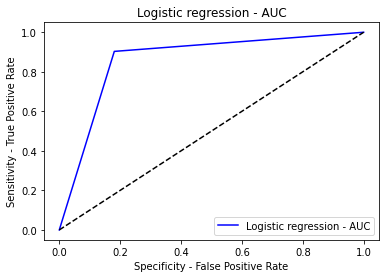

AUC: 0.8612074883620711
Confusion Matrix : 
 [[14796  3264]
 [ 1798 16766]]
Accuracy :  0.861784622105723
Sensitivity :  0.8192691029900332
Specificity :  0.903145873734109


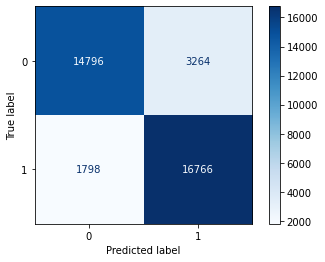

In [48]:
clasificacionPruebaRLG, accuracyRLG, sensitivityRLG, specificityRLG, AUCRLG = RLWithGridSearch(XE20MFCC, ygE20MFCC, XP20MFCC, ygP20MFCC, XV20MFCC, ygV20MFCC, 1, 'Logistic regression - AUC') #Genero

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 281071.896553
{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       421
           1       0.94      0.77      0.85       358
           2       0.94      0.82      0.87       445
           3       0.72      0.80      0.76       845
           4       0.81      0.70      0.75       945
           5       1.00      0.95      0.97       408
           6       0.97      0.86      0.91       448
           7       0.92      0.95      0.93       382
           8       0.81      0.53      0.64       573
           9       0.84      0.82      0.83       483
          10       0.98      0.90      0.94       562
          11       0.89      0.90      0.89       604
          12       0.79      0.61      0.69       391
          13       0.79      0.57      0.66       414
          14       0.74      0.80      0.77       333


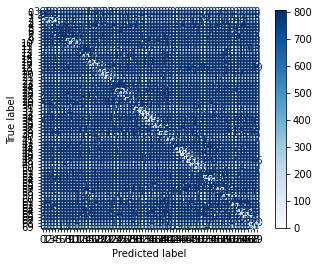

Sensitivity: [0.87648456 0.77094972 0.81573034 0.8035503  0.7026455  0.95098039
 0.85714286 0.95026178 0.53403141 0.81780538 0.89679715 0.89569536
 0.61381074 0.57004831 0.7987988  0.87238494 0.71611253 0.89177489
 0.72318339 0.84653465 0.91886792 0.89473684 0.91447368 0.77754678
 0.90639269 0.71594203 0.88152327 0.91498881 0.91586538 0.67665418
 0.67908309 0.73282443 0.93401015 0.90322581 0.81818182 0.7520938
 0.93555094 0.94602273 0.83854167 0.70355731 0.67393939 0.80260304
 0.94726166 0.91034483 0.93968254 0.91698113 0.99795082 0.96084829
 0.77808599 0.98272553 0.96494157 0.84962406 0.82318841 0.89018692
 0.8877193  0.88876404 0.79879276 0.71865443 0.7792     0.67843137
 0.84684685 0.67446043 0.75806452 0.86344538 0.46875    0.79089376
 0.97908745 0.88580247 0.83333333 0.87478261]
Specificity: [0.99892274 0.99947609 0.99936427 0.99273317 0.99568374 1.
 0.99966829 0.99908945 0.99800283 0.99795246 0.99975043 0.99813992
 0.99820606 0.99831538 0.99738227 0.99360925 0.99569453 0.99861733

In [49]:
clasificacionPruebaRLl, accuracyRLl, sensitivityRLl, specificityRLl, AUCRLl = RLWithGridSearch(XE20MFCC, ylE20MFCC, XP20MFCC, ylP20MFCC, XV20MFCC, ylV20MFCC, 0, 'Logistic Regression - AUC Curve') #Locutor

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 912581.430197
{'max_features': 'log2', 'n_estimators': 1000}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18060
           1       1.00      1.00      1.00     18564

    accuracy                           1.00     36624
   macro avg       1.00      1.00      1.00     36624
weighted avg       1.00      1.00      1.00     36624

Test time: 2928.055525
Random Forest Test


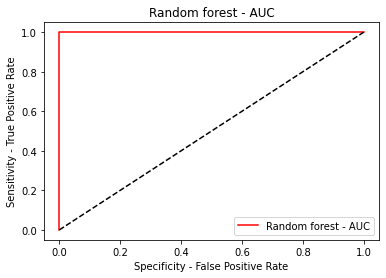

AUC: 1.0
Confusion Matrix : 
 [[18060     0]
 [    0 18564]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0


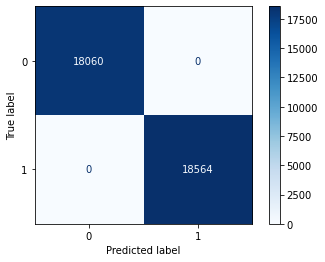

In [50]:
clasificacionPruebaRFG, accuracyRFG, sensitivityRFG, specificityRFG, AUCRFG = RFWithGridSearch(XE20MFCC, ygE20MFCC, XP20MFCC, ygP20MFCC, XV20MFCC, ygV20MFCC, 1, 'Random forest - AUC')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Training time: 2201182.092428
{'max_features': 'log2', 'n_estimators': 1000}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       421
           1       1.00      1.00      1.00       358
           2       1.00      1.00      1.00       445
           3       1.00      1.00      1.00       845
           4       1.00      1.00      1.00       945
           5       1.00      1.00      1.00       408
           6       1.00      1.00      1.00       448
           7       1.00      1.00      1.00       382
           8       1.00      1.00      1.00       573
           9       1.00      1.00      1.00       483
          10       1.00      1.00      1.00       562
          11       1.00      1.00      1.00       604
          12       1.00      1.00      1.00       391
          13       1.00      1.00      1.00       414
          14       1.00      1.00      1.00       333

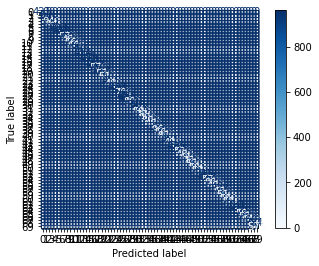

Sensitivity: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Specificity: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [51]:
clasificacionPruebaRFl, accuracyRFl, sensitivityRFl, specificityRFl, AUCRFl = RFWithGridSearch(XE20MFCC, ylE20MFCC, XP20MFCC, ylP20MFCC, XV20MFCC, ylV20MFCC, 0, 'Random forest - AUC')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.770 total time= 1.8min
[CV 2/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.843 total time= 1.8min
[CV 3/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.746 total time= 1.8min
Training time: 329598.710537
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18060
           1       1.00      1.00      1.00     18564

    accuracy                           1.00     36624
   macro avg       1.00      1.00      1.00     36624
weighted avg       1.00      1.00      1.00     36624

Test time: 131836.583614
KNN Test


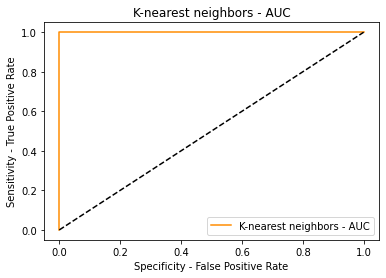

AUC: 1.0
Confusion Matrix : 
 [[18060     0]
 [    0 18564]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0


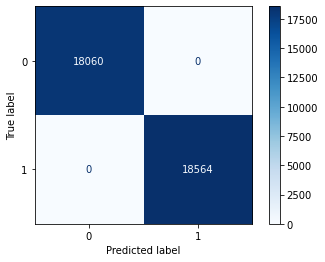

In [52]:
clasificacionPruebaKNNG, accuracyKNNG, sensitivityKNNG, specificityKNNG, AUCKNNG = KNNWithGridSearch(XE20MFCC, ygE20MFCC, XP20MFCC, ygP20MFCC, XV20MFCC, ygV20MFCC, 1, 'K-nearest neighbors - AUC')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.838 total time= 1.8min
[CV 2/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.881 total time= 1.9min
[CV 3/3] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.865 total time= 1.8min
Training time: 326722.896814
{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       421
           1       1.00      1.00      1.00       358
           2       1.00      1.00      1.00       445
           3       1.00      1.00      1.00       845
           4       1.00      1.00      1.00       945
           5       1.00      1.00      1.00       408
           6       1.00      1.00      1.00       448
           7       1.00      1.00      1.00       382
           8       1.00      1.00      1.00       573
           9      

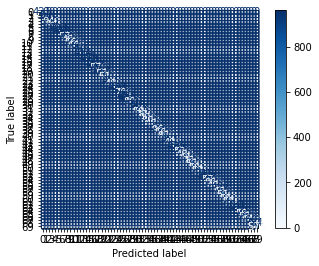

Sensitivity: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Specificity: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [53]:
clasificacionPruebaKNNl, accuracyKNNl, sensitivityKNNl, specificityKNNl, AUCKNNl = KNNWithGridSearch(XE20MFCC, ylE20MFCC, XP20MFCC, ylP20MFCC, XV20MFCC, ylV20MFCC, 0, 'K-nearest neighbors - AKNN')

Epoch 1/20
3135/3135 [==============================] - 11s 3ms/step - loss: 0.1594 - accuracy: 0.9610 - auc: 0.9874 - recall: 0.9610 - specificity_at_sensitivity_4: 0.9917 - sensitivity_at_specificity_4: 0.9917 - val_loss: 1.7141 - val_accuracy: 0.7503 - val_auc: 0.8042 - val_recall: 0.7503 - val_specificity_at_sensitivity_4: 0.8841 - val_sensitivity_at_specificity_4: 0.8841
Epoch 2/20
3135/3135 [==============================] - 10s 3ms/step - loss: 0.0517 - accuracy: 0.9822 - auc: 0.9976 - recall: 0.9822 - specificity_at_sensitivity_4: 0.9988 - sensitivity_at_specificity_4: 0.9988 - val_loss: 1.2018 - val_accuracy: 0.8058 - val_auc: 0.8580 - val_recall: 0.8058 - val_specificity_at_sensitivity_4: 0.9162 - val_sensitivity_at_specificity_4: 0.9162
Epoch 3/20
3135/3135 [==============================] - 10s 3ms/step - loss: 0.0391 - accuracy: 0.9869 - auc: 0.9984 - recall: 0.9869 - specificity_at_sensitivity_4: 0.9992 - sensitivity_at_specificity_4: 0.9992 - val_loss: 2.5505 - val_accur

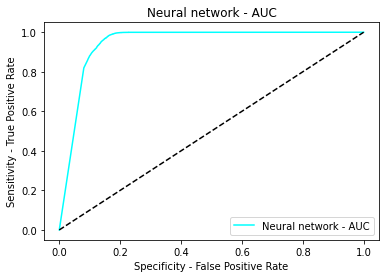

[0.         0.98190045 1.        ]
[0.         0.16129568 1.        ]
[2 1 0]
0.9103023857127824
Threshold value is: 1


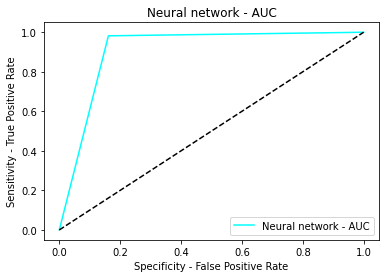

RN Test
AUC: 0.9103023857127824
Confusion Matrix : 
 [[15147  2913]
 [  336 18228]]
Accuracy :  0.9112876802096985
Sensitivity :  0.838704318936877
Specificity :  0.9819004524886877


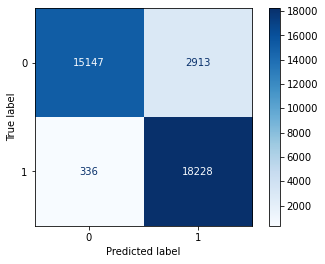

In [76]:
PRED1G, PRED2G = neuronalNetwork(XE20MFCC, ygE20MFCC, XP20MFCC, ygP20MFCC, XV20MFCC, ygV20MFCC, 1) #Genero

In [78]:
PRED1L, PRED2L = neuronalNetwork(XE20MFCC, ylE20MFCC, XP20MFCC, ylP20MFCC, XV20MFCC, ylV20MFCC, 0) #Locutor

Epoch 1/20
3135/3135 [==============================] - 5s 2ms/step - loss: 0.5543 - accuracy: 0.8848 - auc: 0.9847 - recall: 0.8716 - specificity_at_sensitivity_5: 0.9999 - sensitivity_at_specificity_5: 0.9711 - val_loss: 46.5757 - val_accuracy: 0.0116 - val_auc: 0.4837 - val_recall: 0.0109 - val_specificity_at_sensitivity_5: 0.0423 - val_sensitivity_at_specificity_5: 0.0133
Epoch 2/20
3135/3135 [==============================] - 5s 1ms/step - loss: 0.1903 - accuracy: 0.9477 - auc: 0.9965 - recall: 0.9390 - specificity_at_sensitivity_5: 1.0000 - sensitivity_at_specificity_5: 0.9935 - val_loss: 56.5401 - val_accuracy: 0.0123 - val_auc: 0.4879 - val_recall: 0.0120 - val_specificity_at_sensitivity_5: 0.1153 - val_sensitivity_at_specificity_5: 0.0133
Epoch 3/20
3135/3135 [==============================] - 5s 1ms/step - loss: 0.1341 - accuracy: 0.9620 - auc: 0.9976 - recall: 0.9567 - specificity_at_sensitivity_5: 1.0000 - sensitivity_at_specificity_5: 0.9955 - val_loss: 63.3539 - val_accur

### Scores

In [56]:
print("LOGISTIC REGRESSION GENDER:")
print('Accuracy')
print(accuracyRLG)
print('Sensitivity')
print(sensitivityRLG)
print('Specificity')
print(specificityRLG)
print('AUC')
print(AUCRLG)
print('\n')
print("LOGISTIC REGRESSION SPEAKER:")
print('Accuracy')
print(np.mean(accuracyRLl))
print('Sensitivity')
print(np.mean(specificityRLl))
print('Specificity')
print(np.mean(sensitivityRLl))
print('AUC')
print(AUCRLl)
print('\n')

print("Random Forest GENDER:")
print('Accuracy')
print(accuracyRFG)
print('Sensitivity')
print(sensitivityRFG)
print('Specificity')
print(specificityRFG)
print('AUC')
print(AUCRFG)
print('\n')
print("Random Forest SPEAKER:")
print('Accuracy')
print(np.mean(accuracyRFl))
print('Sensitivity')
print(np.mean(sensitivityRFl))
print('Specificity')
print(np.mean(specificityRFl))
print('AUC')
print(AUCRFl)
print('\n')

print("KNN GENDER:")
print('Accuracy')
print(accuracyKNNG)
print('Sensitivity')
print(sensitivityKNNG)
print('Specificity')
print(specificityKNNG)
print('AUC')
print(AUCKNNG)
print('\n')
print("KNN SPEAKER:")
print('Accuracy')
print(np.mean(accuracyKNNl))
print('Sensitivity')
print(np.mean(sensitivityKNNl))
print('Specificity')
print(np.mean(specificityKNNl))
print('AUC')
print(AUCKNNl)
print('\n')

LOGISTIC REGRESSION GENDER:
Accuracy
0.861784622105723
Sensitivity
0.8192691029900332
Specificity
0.903145873734109
AUC
0.8612074883620711


LOGISTIC REGRESSION SPEAKER:
Accuracy
0.8267529488859764
Sensitivity
0.9974860092559549
Specificity
0.8261457033927013
AUC
0.9936299813894854


Random Forest GENDER:
Accuracy
1.0
Sensitivity
1.0
Specificity
1.0
AUC
1.0


Random Forest SPEAKER:
Accuracy
1.0
Sensitivity
1.0
Specificity
1.0
AUC
1.0


KNN GENDER:
Accuracy
1.0
Sensitivity
1.0
Specificity
1.0
AUC
1.0


KNN SPEAKER:
Accuracy
1.0
Sensitivity
1.0
Specificity
1.0
AUC
1.0




In [57]:
print('Predicciones Regresion Logistica')
print(clasificacionPruebaRLG)
print(clasificacionPruebaRLl)
print(clasificacionPruebaRFG)
print(clasificacionPruebaRFl)
print(clasificacionPruebaKNNG)
print(clasificacionPruebaKNNl)
print(PRED1G)
print(PRED2G)
print(PRED1L)
print(PRED2L)

Predicciones Regresion Logistica
[1 1 1 ... 0 0 0]
[40 40 40 ... 34 34 34]
[1 1 1 ... 0 0 0]
[35 35 35 ... 34 34 34]
[1 1 1 ... 0 0 0]
[35 35 35 ... 34 34 34]
[1 1 1 ... 0 0 0]
[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

### Voto mayoritario

In [58]:
print("Regresion logistica")
print(len(clasificacionPruebaRLG))
print(len(ygP20MFCC))
print(len(clasificacionPruebaRLl))
print(len(ylP20MFCC))
print('\n')
print("Random Forest")
print(len(clasificacionPruebaRFG))
print(len(ygP20MFCC))
print(len(clasificacionPruebaRFl))
print(len(ylP20MFCC))
print('\n')
print("KNN")
print(len(clasificacionPruebaKNNG))
print(len(ygP20MFCC))
print(len(clasificacionPruebaKNNl))
print(len(ylP20MFCC))
print('\n')
print("Red neuronal")
print(len(PRED1G))
print(len(PRED2G))
print(len(PRED1L))
print(len(PRED2L))
PRED2LF = []
for i in range(len(PRED2L)):
    PRED2LF.append(PRED2L[i].argmax())

Regresion logistica
36624
36624
36624
36624


Random Forest
36624
36624
36624
36624


KNN
36624
36624
36624
36624


Red neuronal
36624
36624
36624
36624


### Voto mayoritario genero

In [59]:
def votoMayoritariosGenero(clasificaciones, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP):
    def votoMayoritario(classificaciones, EtiquetaAudio, Genero, Locutor):
        lista = EtiquetaAudio
        repeticiones = {}
        for n in lista:
            if lista.count(n) != 1:
                if n in repeticiones:
                    repeticiones[n] += 1
                else:
                    repeticiones[n] = 0
        return repeticiones
    def matching(repeticiones, EtClasificacion, EtVerdadera):
        values= repeticiones.values()
        isCorrects = []
        count = 0
        for v in values:
            Correct = []
            #print(v)
            #print("GenC\tGenP\tres")
            for indx in range(v+1):
                #print(str(EtVerdadera[count])+'\t'+str(EtClasificacion[count])+'\t'+str(EtVerdadera[count]==EtClasificacion[count]))
                if(EtVerdadera[count]==EtClasificacion[count]):
                    Correct.append(1)
                else:
                    Correct.append(0)
                count += 1
            isCorrects.append(Correct)
            #print(count)
        return isCorrects
    def findMajority(arr, n):
        candidate = -1
        votes = 0
        for i in range(n):
            if (votes == 0):
                candidate = arr[i]
                votes = 1
            else:
                if (arr[i] == candidate):
                    votes += 1
                else:
                    votes -= 1
        count = 0
        for i in range (n):
            if (arr[i] == candidate):
                count += 1
        if (count > n // 2):
            return candidate
        else:
            return -1
    def Voto(isCorrects):
        audiosClas = []
        for c in isCorrects:
            arr = c
            n = len(arr)
            majority = findMajority(arr, n)
            if(majority==True):
                audiosClas.append(1)
            else:
                audiosClas.append(0)
        return audiosClas
    print(len(clasificaciones))
    print(len(yAP20MFCC))
    print(len(ygP20MFCC))
    print(len(ylP20MFCC))
    EtClasificacion = []
    EtAudio = []
    EtGenero = []
    EtLocutor = []
    for i in range(len(clasificaciones)):
        EtClasificacion.append(clasificaciones[i])
        EtAudio.append(yAP20MFCC[i])
        EtGenero.append(ygP20MFCC[i])    
        EtLocutor.append(ylP20MFCC[i])
    repeticiones = votoMayoritario(EtClasificacion, EtAudio, EtGenero, EtLocutor)
    print(repeticiones)
    isCorrects = matching(repeticiones, EtClasificacion, EtGenero)
    print(isCorrects)
    audiosClass = Voto(isCorrects)
    print(audiosClass)
    print(ThombresP)
    print(TmujeresP)
    prediccionesAudio = []
    prediccionesHombre = []
    prediccionesMujer = []
    c = 0
    for h in range(ThombresP):
        prediccionesHombre.append(1)
        if(audiosClass[c]==0):
            prediccionesAudio.append(0)
        else:
            prediccionesAudio.append(1)
        c += 1
    for m in range(c, ThombresP+TmujeresP):
        prediccionesMujer.append(0)
        if(audiosClass[c]==0):
            prediccionesAudio.append(0)
        else:
            prediccionesAudio.append(0)
        c += 1
    print(prediccionesAudio)
    realAudio = prediccionesHombre + prediccionesMujer
    print(realAudio)
    fper, tper, thresholds = roc_curve(realAudio, prediccionesAudio)
    cm1 = confusion_matrix(realAudio, prediccionesAudio)
    print("AUC: "+str(metrics.auc(fper, tper)))
    print('Confusion Matrix : \n', cm1)
    total1=sum(sum(cm1))
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)
    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

In [60]:
votoMayoritariosGenero(clasificacionPruebaRLG, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

In [61]:
votoMayoritariosGenero(clasificacionPruebaRFG, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

In [62]:
votoMayoritariosGenero(clasificacionPruebaKNNG, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

In [63]:
votoMayoritariosGenero(PRED2G, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

### Voto mayoritario locutor

In [66]:
def votoMayoritariosLocutor(clasificaciones, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP):
    
    def votoMayoritarioLocutor(classificaciones, EtiquetaAudio, Genero, Locutor):
        lista = EtiquetaAudio
        repeticiones = {}
        for n in lista:
            if lista.count(n) != 1:
                if n in repeticiones:
                    repeticiones[n] += 1
                else:
                    repeticiones[n] = 0
        return repeticiones
    
    def matchingLocutor(repeticiones, EtClasificacion, EtVerdadera):
        values= repeticiones.values()
        isCorrects = []
        count = 0
        for v in values:
            Correct = []
            #print(v)
            #print("GenC\tGenP\tres")
            for indx in range(v+1):
                #print(str(EtVerdadera[count])+'\t'+str(EtClasificacion[count])+'\t'+str(EtVerdadera[count]==EtClasificacion[count]))
                if(EtVerdadera[count]==EtClasificacion[count]):
                    Correct.append(1)
                else:
                    Correct.append(0)
                count += 1
            isCorrects.append(Correct)
            #print(count)
        return isCorrects
    
    def findMajorityLocutor(arr, n):
        candidate = -1
        votes = 0
        for i in range(n):
            if (votes == 0):
                candidate = arr[i]
                votes = 1
            else:
                if (arr[i] == candidate):
                    votes += 1
                else:
                    votes -= 1
        count = 0
        for i in range (n):
            if (arr[i] == candidate):
                count += 1
        if (count > n // 2):
            return candidate
        else:
            return -1

    def VotoLocutor(isCorrects):
        audiosClas = []
        for c in isCorrects:
            arr = c
            n = len(arr)
            majority = findMajorityLocutor(arr, n)
            if(majority==True):
                audiosClas.append(1)
            else:
                audiosClas.append(0)
        return audiosClas
    
    print(len(clasificaciones))
    print(len(yAP20MFCC))
    print(len(ygP20MFCC))
    print(len(ylP20MFCC))

    EtClasificacionL = []
    EtAudioL = []
    EtGeneroL = []
    EtLocutorL = []

    for i in range(len(clasificaciones)):
        EtClasificacionL.append(clasificaciones[i])
        EtAudioL.append(yAP20MFCC[i])
        EtGeneroL.append(ygP20MFCC[i])    
        EtLocutorL.append(ylP20MFCC[i])
        
    repeticionesL = votoMayoritarioLocutor(EtClasificacionL, EtAudioL, EtGeneroL, EtLocutorL)
    print(repeticionesL)

    isCorrectsL = matchingLocutor(repeticionesL, EtClasificacionL, EtLocutorL)
    print(isCorrectsL)

    audiosClassL = VotoLocutor(isCorrectsL)
    print(audiosClassL)
    
    print(len(audiosClassL))
    
    print(ThombresP)
    print(TmujeresP)
    
    print(audiosClassL)
    
    def votoMayoritarioLocutorL(Locutor):
        lista = Locutor
        repeticiones = {}
        for n in lista:
            if lista.count(n) != 1:
                if n in repeticiones:
                    repeticiones[n] += 1
                else:
                    repeticiones[n] = 0
        return repeticiones

    F = votoMayoritarioLocutorL(EtLocutorL)
    
    archivos = []
    for i in F.keys():
        for j in range(0, 4):
            archivos.append(i)
    print(archivos)
    
    
    prediccionesAudioL = []
    c = 0

    for h in range(ThombresP):
        if(audiosClassL[c]==0):
            prediccionesAudioL.append(0)
        else:
            prediccionesAudioL.append(archivos[c])
        c += 1

    for m in range(c, ThombresP+TmujeresP):
        if(audiosClassL[c]==0):
            prediccionesAudioL.append(0)
        else:
            prediccionesAudioL.append(archivos[c])
        c += 1
        
    print(len(prediccionesAudioL))
    print(len(archivos))
    print(archivos)
    print(prediccionesAudioL)
    
    verdadero = np.array(archivos)
    predicciones = np.array(prediccionesAudioL)
    
    
    le = preprocessing.LabelEncoder()
    le.fit(verdadero)
    cnf_matrix  = confusion_matrix(verdadero, predicciones)
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=list(le.classes_))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    rep = accuracy_score(verdadero, predicciones)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    print('Accuracy: '+str(accuracy_score(verdadero, predicciones)))
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print('Sensitivity: '+str(np.mean(TPR)))
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print('Specificity: '+str(np.mean(TNR)))
    
    def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
        lb = preprocessing.LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)
        return roc_auc_score(y_test, y_pred, average=average)

    auc = multiclass_roc_auc_score(verdadero, predicciones)
    print('AUC:' +str(auc))

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

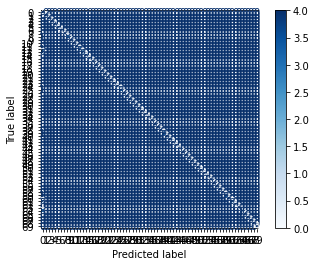

Accuracy: 0.9571428571428572
Sensitivity: 0.9571428571428572
Specificity: 0.9993788819875776
AUC:0.9782608695652174


In [67]:
votoMayoritariosLocutor(clasificacionPruebaRLl, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

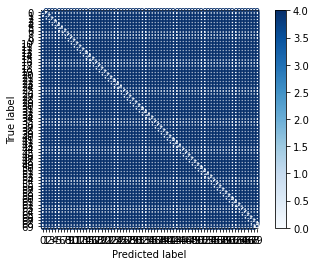

Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
AUC:1.0


In [68]:
votoMayoritariosLocutor(clasificacionPruebaRFl, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

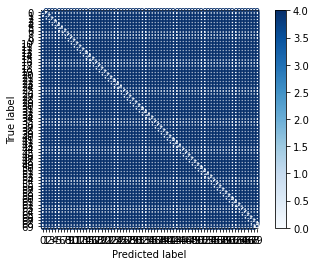

Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
AUC:1.0


In [69]:
votoMayoritariosLocutor(clasificacionPruebaKNNl, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)

36624
36624
36624
36624
{0: 86, 1: 192, 2: 201, 3: 114, 4: 91, 5: 181, 6: 91, 7: 114, 8: 95, 9: 80, 10: 88, 11: 85, 12: 274, 13: 271, 14: 120, 15: 291, 16: 163, 17: 72, 18: 84, 19: 183, 20: 142, 21: 157, 22: 350, 23: 172, 24: 110, 25: 134, 26: 85, 27: 128, 28: 163, 29: 75, 30: 67, 31: 184, 32: 82, 33: 155, 34: 73, 35: 121, 36: 89, 37: 75, 38: 67, 39: 80, 40: 106, 41: 104, 42: 224, 43: 92, 44: 98, 45: 105, 46: 189, 47: 92, 48: 194, 49: 92, 50: 158, 51: 165, 52: 114, 53: 121, 54: 232, 55: 250, 56: 135, 57: 135, 58: 128, 59: 119, 60: 116, 61: 260, 62: 116, 63: 103, 64: 112, 65: 167, 66: 166, 67: 83, 68: 62, 69: 139, 70: 78, 71: 62, 72: 105, 73: 117, 74: 92, 75: 110, 76: 199, 77: 102, 78: 99, 79: 166, 80: 242, 81: 149, 82: 251, 83: 244, 84: 116, 85: 123, 86: 128, 87: 126, 88: 78, 89: 82, 90: 85, 91: 78, 92: 91, 93: 94, 94: 203, 95: 233, 96: 207, 97: 94, 98: 138, 99: 67, 100: 103, 101: 182, 102: 166, 103: 100, 104: 208, 105: 96, 106: 68, 107: 180, 108: 70, 109: 65, 110: 90, 111: 81, 112: 11

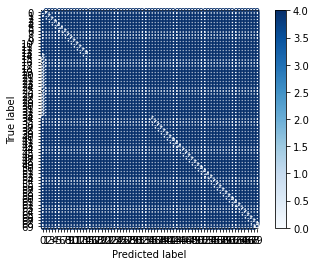

Accuracy: 0.7142857142857143
Sensitivity: 0.7142857142857143
Specificity: 0.9958592132505176
AUC:0.855072463768116


In [70]:
votoMayoritariosLocutor(PRED2LF, yAP20MFCC, ygP20MFCC, ylP20MFCC, ThombresP, TmujeresP)